# TAHAP PERSIAPAN


## Import Library

In [1]:
%pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import pandas as pd
import Bio
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random

from tqdm.auto import tqdm 
from matplotlib.ticker import FuncFormatter
from sklearn.feature_extraction.text import CountVectorizer
from Bio import SeqIO
from IPython.display import display
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid
pd.set_option('display.max_columns', None)

# Perbaikan 1: Setiap print di baris baru
print(f"(a) Python {sys.version.split()[0]}") 

# Perbaikan 2: Menggunakan __version__ (double underscore)
print(f"(b) Pandas {pd.__version__}")
print(f"(c) Biopython {Bio.__version__}")
print(f"(d) NumPy {np.__version__}")
print(f"(e) Scikit-learn (sklearn) {sklearn.__version__}")
print(f"(f) Matplotlib {matplotlib.__version__}")
print(f"(g) Seaborn {sns.__version__}")

print("=================================")

(a) Python 3.11.13
(b) Pandas 2.2.3
(c) Biopython 1.86
(d) NumPy 1.26.4
(e) Scikit-learn (sklearn) 1.2.2
(f) Matplotlib 3.7.2
(g) Seaborn 0.12.2


## Persiapan Data Fasta

In [3]:
print("TAHAP 1: PERSIAPAN DATA FASTA (LOAD & PREVIEW HEAD-TAIL)")
# 1. Mulai Timer
start_time = time.time()
# 2. Definisi Path File
fasta_file = '/kaggle/input/datamentah/0_dna-sequences-silva-v3-v4.fasta'
# 3. Proses Loading (List Comprehension)
data_fasta = [{
    'feature_id': record.id,
    'sequence': str(record.seq),
    'seq_length': len(record.seq)
} for record in SeqIO.parse(fasta_file, "fasta")]
# 4. Buat DataFrame
df_seq = pd.DataFrame(data_fasta)
# 5. Laporan Output Linear
print(f"-> Total Baris  : {len(df_seq):,} sekuens")
print("-" * 60)
# 6. Preview Data (Mempercantik Tampilan)
#    Copy dataframe agar data asli aman
df_preview = df_seq.copy()
#    Format string: potong sekuens panjang jadi "ATCG...ATCG"
df_preview['sequence'] = df_preview['sequence'].apply(
    lambda s: f"{s[:6]}...{s[-6:]}"
)
# --- MENGGUNAKAN DISPLAY ---
print("\n[TOP 5 DATA AWAL (HEAD)]")
display(df_preview.head(5))
print("\n[BOTTOM 5 DATA AKHIR (TAIL)]")
display(df_preview.tail(5))
# ---------------------------

print("-" * 60)

# 7. Statistik Panjang Sekuens
stats_len = df_seq['seq_length'].describe()
print("STATISTIK PANJANG SEKUENS:")
print(f"-> Terpendek : {stats_len['min']:.0f} bp")
print(f"-> Terpanjang: {stats_len['max']:.0f} bp")
print(f"-> Rata-rata : {stats_len['mean']:.2f} bp")

# 8. Selesai
end_time = time.time()
print("="*60)
print(f"Waktu eksekusi total: {end_time - start_time:.2f} detik")
print("="*60)

TAHAP 1: PERSIAPAN DATA FASTA (LOAD & PREVIEW HEAD-TAIL)
-> Total Baris  : 398,508 sekuens
------------------------------------------------------------

[TOP 5 DATA AWAL (HEAD)]


,feature_id,sequence,seq_length
0,CP013078.2406498.2408039,TGGGGA...CAAACA,427
1,CP015924.1224168.1225721,TGGGGA...CAAACA,427
2,CP003278.287486.289015,TGGGGA...CAAACA,427
3,LS483321.16842.18378,TAGGGA...CAAACA,427
4,CP012870.431955.433510,TGGGGA...CAAACA,427



[BOTTOM 5 DATA AKHIR (TAIL)]


,feature_id,sequence,seq_length
398503,X80629.1.1463,TGGGGA...CGAACA,410
398504,X89947.1.1450,TGGGGA...CGAACA,403
398505,ABCY02000001.445842.447355,CTAAGA...CAAACA,428
398506,Y10757.1.1502,TGGGGA...CAAACA,427
398507,Z76660.1.1493,TGGGGA...CAAACA,427


------------------------------------------------------------
STATISTIK PANJANG SEKUENS:
-> Terpendek : 51 bp
-> Terpanjang: 464 bp
-> Rata-rata : 416.31 bp
Waktu eksekusi total: 3.36 detik


## Persiapan Data Taxon

In [4]:
print("TAHAP 2: PENGOLAHAN DATA TAKSONOMI (SPLIT & CLEANING)")

# 1. Mulai Timer
start_time = time.time()
# 2. Definisi Path File TSV
tsv_file = '/kaggle/input/datamentah/0_taxonomy.tsv'
# 3. Load Data
df_tax = pd.read_csv(tsv_file, sep='\t')
# 4. Rename Kolom
#    Fungsi rename aman digunakan tanpa if. Jika kolom tidak ada, dia skip otomatis.
df_tax.rename(columns={'Feature ID': 'feature_id'}, inplace=True)
# 5. PREVIEW SEBELUM DIPECAH (RAW DATA)
print(f"-> Status Load    : Berhasil")
print(f"-> Total Baris    : {len(df_tax):,} data")
print("-" * 60)

#Menampilkan Data
display(df_tax.head(5))
display(df_tax.tail(5))

# 6. PROSES Memecah Kolom
print("Sedang memproses pemecahan kolom 'Taxon'...")
# A. Bersihkan prefix (d__, p__, c__) menggunakan Regex secara langsung
df_tax['Taxon_Clean'] = df_tax['Taxon'].astype(str).str.replace(r'[a-z]__', '', regex=True)
# B. Pecah string berdasarkan '; ' menjadi kolom-kolom terpisah
df_split = df_tax['Taxon_Clean'].str.split('; ', expand=True)
# C. Beri nama kolom (Domain s/d Species)
col_names = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
df_split.columns = col_names[:df_split.shape[1]]
# D. Gabungkan kembali: Feature ID + Kolom Taksonomi Baru
df_final_tax = pd.concat([df_tax[['feature_id']], df_split], axis=1)

# 7. PREVIEW SETELAH DIPECAH (FINAL DATA)
print(f"-> Status Proses  : Berhasil memecah menjadi {df_split.shape[1]} tingkatan.")
print("-" * 60)
print("PREVIEW DATA HASIL DIPECAH :")

display(df_final_tax.head(5))
display(df_final_tax.tail(5))

print("-" * 60)

# 8. Selesai
end_time = time.time()
print(f"Waktu eksekusi total: {end_time - start_time:.2f} detik")

TAHAP 2: PENGOLAHAN DATA TAKSONOMI (SPLIT & CLEANING)
-> Status Load    : Berhasil
-> Total Baris    : 436,680 data
------------------------------------------------------------


,feature_id,Taxon
0,CP013078.2406498.2408039,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
1,CP015924.1224168.1225721,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
2,CP003278.287486.289015,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
3,LS483321.16842.18378,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...
4,CP012870.431955.433510,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


,feature_id,Taxon
436675,X90756.1.1769,d__Eukaryota; p__Ascomycota; c__Saccharomycete...
436676,X97777.1.1771,d__Eukaryota; p__Ascomycota; c__Saccharomycete...
436677,ABCY02000001.445842.447355,d__Bacteria; p__Spirochaetota; c__Spirochaetia...
436678,Y10757.1.1502,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
436679,Z76660.1.1493,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


Sedang memproses pemecahan kolom 'Taxon'...
-> Status Proses  : Berhasil memecah menjadi 7 tingkatan.
------------------------------------------------------------
PREVIEW DATA HASIL DIPECAH :


,feature_id,Domain,Phylum,Class,Order,Family,Genus,Species
0,CP013078.2406498.2408039,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella_pertussis
1,CP015924.1224168.1225721,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
2,CP003278.287486.289015,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
3,LS483321.16842.18378,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_pyogenes
4,CP012870.431955.433510,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia-Shigella,Escherichia_coli


,feature_id,Domain,Phylum,Class,Order,Family,Genus,Species
436675,X90756.1.1769,Eukaryota,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Torulaspora,Torulaspora_microellipsoides
436676,X97777.1.1771,Eukaryota,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces,Saccharomyces_bayanus
436677,ABCY02000001.445842.447355,Bacteria,Spirochaetota,Spirochaetia,Spirochaetales,Spirochaetaceae,Borreliella,Borreliella_valaisiana
436678,Y10757.1.1502,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas_arboricola
436679,Z76660.1.1493,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas_coronafaciens


------------------------------------------------------------
Waktu eksekusi total: 4.32 detik


## Merge Data

In [5]:
print("TAHAP 3: INTEGRASI DATA (MERGING FASTA + TAXONOMY)")
# 1. Mulai Timer
start_time = time.time()

print("Sedang melakukan proses penggabungan data (Inner Join)...")

# 2. Proses Merging (Inner Join)
#    Inner join hanya menyimpan data yang ID-nya ada di KEDUA tabel.
#    Data yang tidak punya pasangan akan otomatis terbuang.
df_merged = pd.merge(df_seq, df_final_tax, on='feature_id', how='inner')

# 3. Laporan Statistik Merging
n_seq = len(df_seq)
n_tax = len(df_final_tax)
n_merged = len(df_merged)

print(f"-> Data Sekuens (FASTA) : {n_seq:,} baris")
print(f"-> Data Taksonomi (TSV) : {n_tax:,} baris")
print(f"-> HASIL MERGE (MATCH)  : {n_merged:,} baris")
print(f"-> Data Hilang (Unmatched): {n_seq - n_merged:,} baris dari FASTA tidak punya taksonomi")
print("PREVIEW DATASET TERINTEGRASI (SIAP FILTERING):")

# 4. Tampilkan Hasil (Head & Tail)
display(df_merged.head(5))
display(df_merged.tail(5))

# 5. Cek Info Kolom
print("STRUKTUR DATA FINAL:")
print(df_merged.info())

# 6. MENYIMPAN KE FILE CSV (BAGIAN BARU)
output_filename = 'datamerge.csv'
print(f"Sedang menyimpan hasil ke file '{output_filename}'...")

# index=False agar nomor baris (0, 1, 2...) tidak ikut tersimpan sebagai kolom
df_merged.to_csv(output_filename, index=False)
print(f"-> SUKSES! File berhasil disimpan.")

# 7. Selesai
end_time = time.time()
print(f"Waktu eksekusi total: {end_time - start_time:.2f} detik")

TAHAP 3: INTEGRASI DATA (MERGING FASTA + TAXONOMY)
Sedang melakukan proses penggabungan data (Inner Join)...
-> Data Sekuens (FASTA) : 398,508 baris
-> Data Taksonomi (TSV) : 436,680 baris
-> HASIL MERGE (MATCH)  : 398,508 baris
-> Data Hilang (Unmatched): 0 baris dari FASTA tidak punya taksonomi
PREVIEW DATASET TERINTEGRASI (SIAP FILTERING):


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
0,CP013078.2406498.2408039,TGGGGAATTTTGGACAATGGGGGCAACCCTGATCCAGCCATCCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella_pertussis
1,CP015924.1224168.1225721,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
2,CP003278.287486.289015,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
3,LS483321.16842.18378,TAGGGAATCTTCGGCAATGGGGGCAACCCTGACCGAGCAACGCCGC...,427,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_pyogenes
4,CP012870.431955.433510,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia-Shigella,Escherichia_coli


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
398503,X80629.1.1463,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCGACCCCGC...,410,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium_glutamicum
398504,X89947.1.1450,TGGGGAATATTGCGCAATGGGCGAAAGCCTGACGCAGCGACGCCGC...,403,Bacteria,Actinobacteriota,Actinobacteria,Streptosporangiales,Streptosporangiaceae,Streptosporangium,Streptosporangium_roseum
398505,ABCY02000001.445842.447355,CTAAGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCGACACTGC...,428,Bacteria,Spirochaetota,Spirochaetia,Spirochaetales,Spirochaetaceae,Borreliella,Borreliella_valaisiana
398506,Y10757.1.1502,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas_arboricola
398507,Z76660.1.1493,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas_coronafaciens


STRUKTUR DATA FINAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398508 entries, 0 to 398507
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_id  398508 non-null  object
 1   sequence    398508 non-null  object
 2   seq_length  398508 non-null  int64 
 3   Domain      398508 non-null  object
 4   Phylum      398508 non-null  object
 5   Class       398508 non-null  object
 6   Order       398508 non-null  object
 7   Family      398508 non-null  object
 8   Genus       398508 non-null  object
 9   Species     398508 non-null  object
dtypes: int64(1), object(9)
memory usage: 30.4+ MB
None
Sedang menyimpan hasil ke file 'datamerge.csv'...
-> SUKSES! File berhasil disimpan.
Waktu eksekusi total: 7.41 detik


# TAHAP PREPROCESSING DATA Awal

## Memuat Data Merge

In [6]:
print("TAHAP INISIASI: MEMUAT DATA GABUNGAN & CEK TOTAL KELAS")
start_time = time.time()

# 1. Definisi Path File
merge_file = '/kaggle/input/datasetmergefinal/datamerge.csv'
# 2. Proses Load Data
print(f"Sedang membaca file: {merge_file.split('/')[-1]}...")
df_processed = pd.read_csv(merge_file)
# 3. Hitung Statistik Awal
total_baris = len(df_processed)
dimensi = df_processed.shape
# Menghitung jumlah unik pada kolom 'Phylum'
total_kelas = df_processed['Phylum'].nunique()
# 4. Laporan Status
print(f"-> Status Load      : Berhasil")
print(f"-> Total Baris      : {total_baris:,} data")
print(f"-> Dimensi Data     : {dimensi}")
print(f"-> TOTAL KELAS (PHYLUM) AWAL : {total_kelas} kelas")
# --- A. PROSES HEAD (5 DATA AWAL) ---
print("PREVIEW 5 DATA AWAL:")
df_head = df_processed.head(5).copy()
df_head['sequence'] = df_head['sequence'].apply(lambda s: f"{str(s)[:3]}...{str(s)[-3:]}")
display(df_head)
# --- B. PROSES TAIL (5 DATA AKHIR) ---
print("\nPREVIEW 5 DATA AKHIR:")
df_tail = df_processed.tail(5).copy()
df_tail['sequence'] = df_tail['sequence'].apply(lambda s: f"{str(s)[:3]}...{str(s)[-3:]}")
display(df_tail)
# 5. CEK DISTRIBUSI KELAS
#    Menampilkan 10 Phylum terbanyak agar kita tahu dominasi data
print("[Distribusi Kelas]")
print(df_processed['Phylum'].value_counts())
print("-" * 80)
# 6. Selesai
end_time = time.time()
print(f"Waktu eksekusi: {end_time - start_time:.2f} detik")

TAHAP INISIASI: MEMUAT DATA GABUNGAN & CEK TOTAL KELAS
Sedang membaca file: datamerge.csv...
-> Status Load      : Berhasil
-> Total Baris      : 398,508 data
-> Dimensi Data     : (398508, 10)
-> TOTAL KELAS (PHYLUM) AWAL : 198 kelas
PREVIEW 5 DATA AWAL:


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
0,CP013078.2406498.2408039,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella_pertussis
1,CP015924.1224168.1225721,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
2,CP003278.287486.289015,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
3,LS483321.16842.18378,TAG...ACA,427,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_pyogenes
4,CP012870.431955.433510,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia-Shigella,Escherichia_coli



PREVIEW 5 DATA AKHIR:


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
398503,X80629.1.1463,TGG...ACA,410,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium_glutamicum
398504,X89947.1.1450,TGG...ACA,403,Bacteria,Actinobacteriota,Actinobacteria,Streptosporangiales,Streptosporangiaceae,Streptosporangium,Streptosporangium_roseum
398505,ABCY02000001.445842.447355,CTA...ACA,428,Bacteria,Spirochaetota,Spirochaetia,Spirochaetales,Spirochaetaceae,Borreliella,Borreliella_valaisiana
398506,Y10757.1.1502,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas_arboricola
398507,Z76660.1.1493,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas_coronafaciens


[Distribusi Kelas]
Phylum
Proteobacteria      106470
Firmicutes          100595
Bacteroidota         43912
Actinobacteriota     35165
Cyanobacteria         9134
                     ...  
Picozoa                  1
Pavlovophyceae           1
Archaea                  1
Microsporidia            1
Lophotrochozoa           1
Name: count, Length: 198, dtype: int64
--------------------------------------------------------------------------------
Waktu eksekusi: 3.79 detik


## Visualisasi Deskripsi Data

VISUALISASI DISTRIBUSI KELAS PHYLUM
-> Total Kelas Ditemukan: 198 Kelas
NAMA PHYLUM                    | JUMLAH    
Proteobacteria                 | 106470    
Firmicutes                     | 100595    
Bacteroidota                   | 43912     
Actinobacteriota               | 35165     
Cyanobacteria                  | 9134      
Acidobacteriota                | 8841      
Chloroflexi                    | 8700      
Planctomycetota                | 8138      
Desulfobacterota               | 7559      
Crenarchaeota                  | 6979      
Verrucomicrobiota              | 6291      
Halobacterota                  | 4892      
Patescibacteria                | 4422      
Campilobacterota               | 3899      
Spirochaetota                  | 3819      
Myxococcota                    | 2950      
Thermoplasmatota               | 2740      
Gemmatimonadota                | 2052      
Euryarchaeota                  | 1769      
Basidiomycota                  | 1663      
Fuso

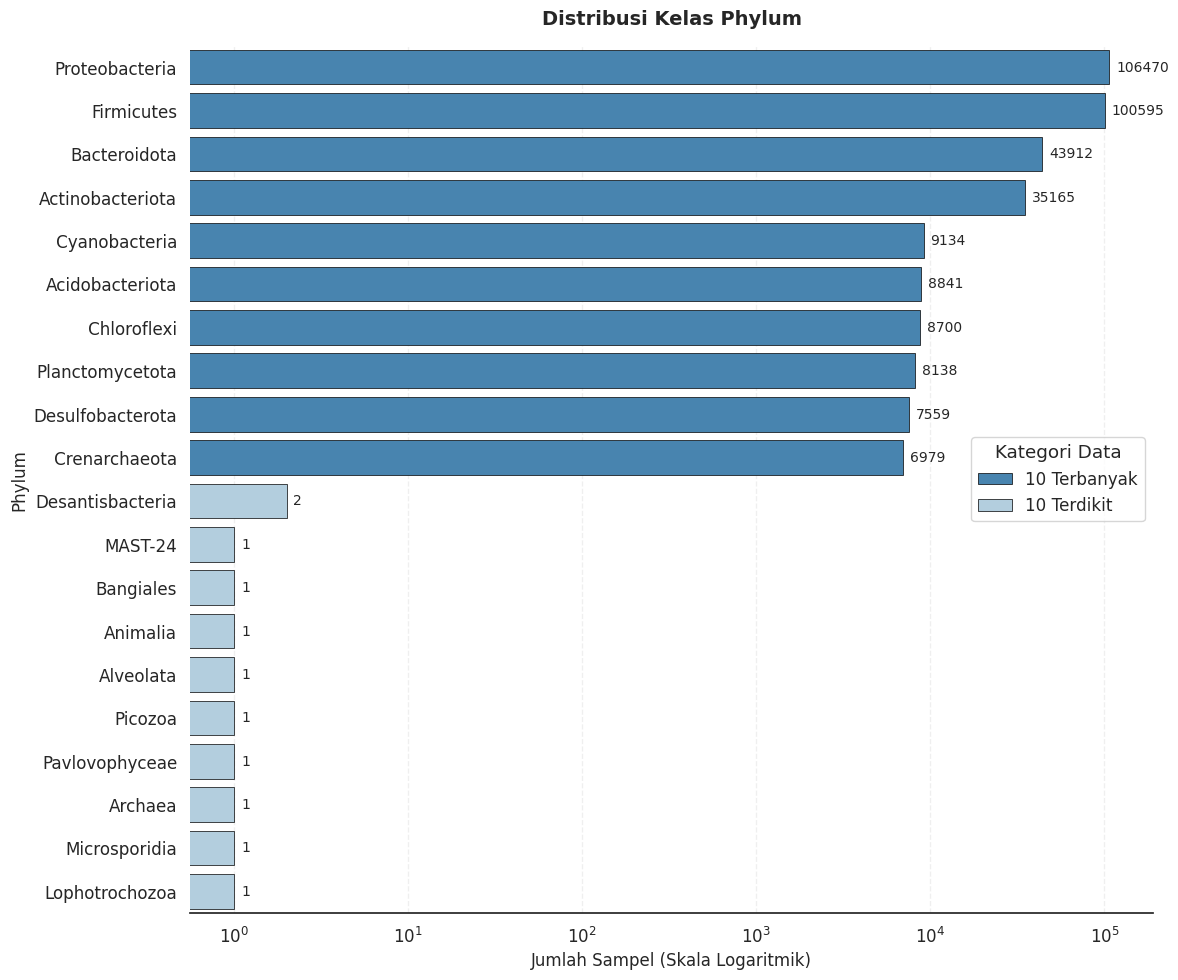

Membuat Plot Panjang Sekuens


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


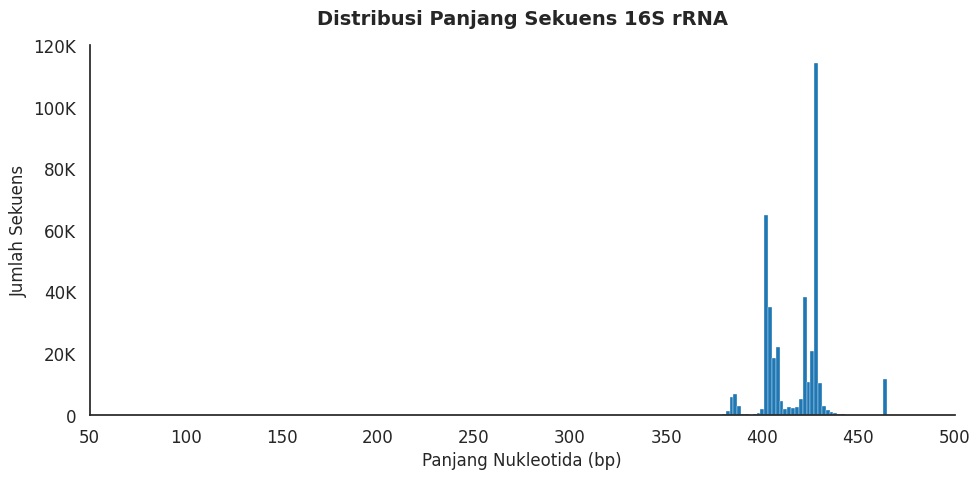

Selesai!
LAPORAN STATISTIK DESKRIPTIF
A. STATISTIK PANJANG SEKUENS (Gambar 3.1)
   -> Minimum Panjang (Min) : 51 bp
   -> Maksimum Panjang (Max): 464 bp
   -> Rata-rata (Mean)      : 416.31 bp
   -> Modus (Terbanyak)     : 427 bp
   -> Rentang Data          : 51 - 464 bp
B. STATISTIK DISTRIBUSI PHYLUM
   -> Total Sampel          : 398,508 baris
   -> Total Label Unik      : 198 Phylum
   -> Phylum Mayoritas      : Proteobacteria (106,470 sampel)
   -> Phylum Minoritas      : MAST-24 (1 sampel)
   -> Rasio (Max/Min)       : 106470.00x lipat (Imbalanced Data)
Statistik Panjang Sekuens:
count    398508.000000
mean        416.307299
std          17.141723
min          51.000000
25%         403.000000
50%         422.000000
75%         427.000000
max         464.000000
Name: seq_length, dtype: float64

Jumlah data dibawah 400 bp: 21,260 baris
Jumlah data dibawah 300 bp: 583 baris


In [7]:
print("VISUALISASI DISTRIBUSI KELAS PHYLUM")

# 1. Hitung Frekuensi tiap Phylum
# .value_counts() otomatis mengurutkan dari terbanyak ke paling sedikit
phylum_counts = df_processed['Phylum'].value_counts()
total_kelas_real = len(phylum_counts)
# 2. Tampilkan Tabel Rincian Angka
print(f"-> Total Kelas Ditemukan: {total_kelas_real} Kelas")
print(f"{'NAMA PHYLUM':<30} | {'JUMLAH':<10}")
for phylum, count in phylum_counts.items():
    print(f"{phylum:<30} | {count:<10}")
# Setup Style
sns.set_style("white") # Background putih bersih
sns.set_context("notebook", font_scale=1.1)
print("VISUALISASI Data")
# DISTRIBUSI PHYLUM (TOP 10 & BOTTOM 10)
print("[Membuat Plot kelas Phylum (10 Atas & 10 Bawah)")
# 1. Persiapan Data
raw_phylum_counts = df_processed['Phylum'].value_counts()
# Ambil 10 Teratas dan 10 Terbawah
top_10 = raw_phylum_counts.head(10).to_frame(name='Jumlah Sampel')
top_10['Kelompok'] = '10 Terbanyak'
bottom_10 = raw_phylum_counts.tail(10).to_frame(name='Jumlah Sampel')
bottom_10['Kelompok'] = '10 Terdikit'
# Gabungkan
df_viz_phylum = pd.concat([top_10, bottom_10])

# 2. Plotting
plt.figure(figsize=(12, 10)) # Tinggi disesuaikan agar muat 20 batang

# Plot Bar Chart Horizontal
# Kita gunakan palette 'Blues_r' (Biru terbalik) agar yang banyak warnanya biru tua, 
# yang sedikit biru muda, tapi tetap nuansa biru.
ax = sns.barplot(
    data=df_viz_phylum,
    x='Jumlah Sampel',
    y=df_viz_phylum.index,
    hue='Kelompok',
    palette='Blues_r', 
    dodge=False,
    edgecolor='black',
    linewidth=0.5
)

# 3. PENTING: Skala Logaritmik
# Tanpa ini, batang '10 Teredikit' akan hilang karena terlalu kecil dibanding Top 10
plt.xscale('log')
# 4. Tambahkan Angka di Ujung Batang (Agar jelas)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=10)
# 5. Alat Visualisasi
plt.title('Distribusi Kelas Phylum', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Jumlah Sampel (Skala Logaritmik)', fontsize=12)
plt.ylabel('Phylum', fontsize=12)
plt.legend(title='Kategori Data')
sns.despine(left=True, bottom=False)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Simpan
plt.tight_layout()
plt.savefig("Distribusi_Phylum_TopBot10.png", dpi=300, bbox_inches='tight')
plt.show()

# BAGIAN 2: DISTRIBUSI PANJANG SEKUENS (BIRU POLOS)
print("Membuat Plot Panjang Sekuens")
# 1. Hitung Panjang
seq_lengths = df_processed['sequence'].astype(str).apply(len)
# 2. Plotting
plt.figure(figsize=(10, 5))
# Histogram Polos (Biru)
ax = sns.histplot(
    seq_lengths, 
    binwidth=2,           # Lebar batang
    color='#1f77b4',      # Warna Biru Standar Matplotlib (Professional Blue)
    edgecolor=None,       # Hilangkan garis pinggir batang agar mulus
    alpha=1.0             # Warna solid (tidak transparan)
)
# 3. Fokus Area (Zoom In ke area data menumpuk)
# Sesuaikan angka ini dengan data Anda, biasanya V3-V4 di 350-500
plt.xlim(50, 500)
# 4. Format Angka Ribuan (20000 -> 20K)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))
# 5. Alat Visualisasi
plt.title('Distribusi Panjang Sekuens 16S rRNA', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Panjang Nukleotida (bp)', fontsize=12)
plt.ylabel('Jumlah Sekuens', fontsize=12)
sns.despine() # Hapus garis kotak atas dan kanan
# Simpan
plt.tight_layout()
plt.savefig("Panjang_Sekuens_Clean.png", dpi=300, bbox_inches='tight')
plt.show()
print("Selesai!")

# BAGIAN 3: STATISTIK Data
print("LAPORAN STATISTIK DESKRIPTIF")

# --- A. STATISTIK PANJANG SEKUENS ---
min_len = seq_lengths.min()
max_len = seq_lengths.max()
mean_len = seq_lengths.mean()
mode_len = seq_lengths.mode()[0] # Ambil modus pertama

print(f"A. STATISTIK PANJANG SEKUENS (Gambar 3.1)")
print(f"   -> Minimum Panjang (Min) : {min_len} bp")
print(f"   -> Maksimum Panjang (Max): {max_len} bp")
print(f"   -> Rata-rata (Mean)      : {mean_len:.2f} bp")
print(f"   -> Modus (Terbanyak)     : {mode_len} bp")
print(f"   -> Rentang Data          : {min_len} - {max_len} bp")

# --- B. STATISTIK DISTRIBUSI KELAS (PHYLUM) ---
total_samples = len(df_processed)
total_phylum = df_processed['Phylum'].nunique()
phylum_counts = df_processed['Phylum'].value_counts()

# Mengambil Mayoritas (Terbanyak) dan Minoritas (Teredikit)
majority_phylum = phylum_counts.idxmax()
majority_count = phylum_counts.max()
minority_phylum = phylum_counts.idxmin()
minority_count = phylum_counts.min()

print(f"B. STATISTIK DISTRIBUSI PHYLUM")
print(f"   -> Total Sampel          : {total_samples:,} baris")
print(f"   -> Total Label Unik      : {total_phylum} Phylum")
print(f"   -> Phylum Mayoritas      : {majority_phylum} ({majority_count:,} sampel)")
print(f"   -> Phylum Minoritas      : {minority_phylum} ({minority_count} sampel)")
print(f"   -> Rasio (Max/Min)       : {majority_count/minority_count:.2f}x lipat (Imbalanced Data)")

# Cek sebaran panjang sekuens di data Anda
print("Statistik Panjang Sekuens:")
print(df_processed['seq_length'].describe())

# Simulasi Filter
cutoff_400 = df_processed[df_processed['seq_length'] < 400].shape[0]
cutoff_300 = df_processed[df_processed['seq_length'] < 300].shape[0]

print(f"\nJumlah data dibawah 400 bp: {cutoff_400:,} baris")
print(f"Jumlah data dibawah 300 bp: {cutoff_300:,} baris")

# Cek Data Uncultured

In [8]:
import pandas as pd
print("Cek Data Uncultured")

# 1. Load Data
file_path = '/kaggle/input/datasetmergefinal/datamerge.csv'
df_investigasi = pd.read_csv(file_path)
# 2. Ambil hanya data dengan Phylum 'uncultured'
# Kita gunakan str.contains untuk menangkap 'uncultured', 'Uncultured', atau variasinya
df_uncultured = df_investigasi[df_investigasi['Phylum'].astype(str).str.contains('uncultured', case=False, na=False)]

print(f"-> Total sampel 'uncultured' ditemukan: {len(df_uncultured)} baris")
# 3. Analisis
print("A. DISTRIBUSI BERDASARKAN DOMAIN :")
domain_counts = df_uncultured['Domain'].value_counts()
print(domain_counts)

# 4. Tampilkan Detail Sampel
# Menampilkan kolom-kolom taksonomi untuk melihat apakah ada info Class/Order/Family
print("B. 10 Sampel Pertama :")
# Coba deteksi kolom taksonomi yang tersedia
cols_to_show = [col for col in ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus'] if col in df_uncultured.columns]
if not cols_to_show:
    cols_to_show = df_uncultured.columns # Tampilkan semua jika nama kolom beda
display(df_uncultured[cols_to_show].head(10))

print("KESIMPULAN:")
if 'Bacteria' in domain_counts:
    print(f"- Ada {domain_counts.get('Bacteria', 0)} sampel 'uncultured' yang masuk Domain Bacteria.")
    print("  (Ini yang tersisa 5 tadi, tapi dibuang karena jumlahnya sedikit).")
    
non_bacteria = len(df_uncultured) - domain_counts.get('Bacteria', 0)
if non_bacteria > 0:
    print(f"- Sebanyak {non_bacteria} sampel berasal dari Domain NON-BACTERIA (Archaea/Eukaryota/dll).")
    print("  (Ini alasan kenapa jumlahnya turun drastis saat Anda filter Domain=='Bacteria').")

Cek Data Uncultured
-> Total sampel 'uncultured' ditemukan: 37 baris
A. DISTRIBUSI BERDASARKAN DOMAIN :
Domain
Eukaryota    24
Archaea       8
Bacteria      5
Name: count, dtype: int64
B. 10 Sampel Pertama :


,Domain,Phylum,Class,Order,Family,Genus
10799,Archaea,uncultured,uncultured,uncultured,uncultured,uncultured
13452,Archaea,uncultured,uncultured,uncultured,uncultured,uncultured
20908,Eukaryota,uncultured,uncultured,uncultured,uncultured,uncultured
23766,Eukaryota,uncultured,uncultured,uncultured,uncultured,uncultured
30880,Bacteria,uncultured,uncultured,uncultured,uncultured,uncultured
36105,Eukaryota,uncultured,uncultured,uncultured,uncultured,uncultured
52256,Eukaryota,uncultured,uncultured,uncultured,uncultured,uncultured
59566,Eukaryota,uncultured,uncultured,uncultured,uncultured,uncultured
80443,Archaea,uncultured,uncultured,uncultured,uncultured,uncultured
83578,Bacteria,uncultured,uncultured,uncultured,uncultured,uncultured


KESIMPULAN:
- Ada 5 sampel 'uncultured' yang masuk Domain Bacteria.
  (Ini yang tersisa 5 tadi, tapi dibuang karena jumlahnya sedikit).
- Sebanyak 32 sampel berasal dari Domain NON-BACTERIA (Archaea/Eukaryota/dll).
  (Ini alasan kenapa jumlahnya turun drastis saat Anda filter Domain=='Bacteria').


# Preprocessing Data

## Penyaringan dan Pembersihan Data

TAHAP 2: PREPROCESSING DATA
-> 1-2. Filter Bacteria & Drop NaN: 368,859 baris
-> 3. Standardisasi Teks: 368,859 baris

[PROSES Eliminasi Data Duplikat & Simpan Data]
   -> BERHASIL! File 'Cek_Data_Duplikat.csv' disimpan.
      (Silakan buka file ini untuk melihat sekuens yang sama persis bersebelahan)
-> 4. Eliminasi Duplikat: 281,864 baris (Dihapus: 86,995 sekuens kembar)
-> 5. Filter n >= 25: 281,737 baris
-> Total Phylum Final: 72 kelas.
TABEL 1: DAMPAK ELIMINASI& FILTERING DATA


,1. Raw (Sebelum Eliminasi),2. Unik (Sesudah Eliminasi),Duplikat Dibuang,% Redundansi,3. Final,Status
Phylum,,,,,,
Proteobacteria,106470,76485,29985,28.16,76485,Lolos
Firmicutes,100595,69818,30777,30.59,69818,Lolos
Bacteroidota,43912,36760,7152,16.29,36760,Lolos
Actinobacteriota,35165,23671,11494,32.69,23671,Lolos
Cyanobacteria,9134,7834,1300,14.23,7834,Lolos
...,...,...,...,...,...,...
Calescamantes,3,3,0,0.00,0,Dibuang
Thermosulfidibacterota,3,2,1,33.33,0,Dibuang
TX1A-33,3,3,0,0.00,0,Dibuang


-> Grafik 1 Tersimpan: Dampak_Eliminasi.png


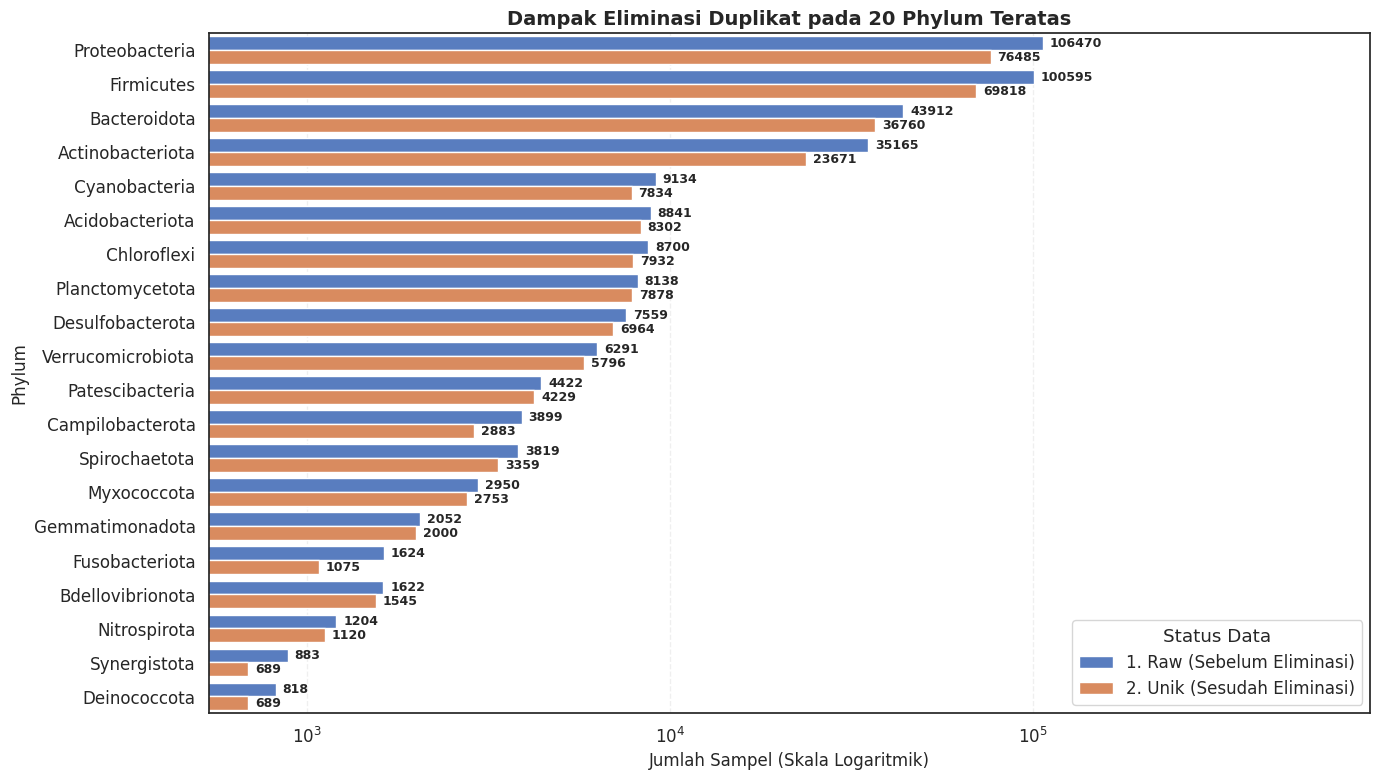

-> Grafik 2 Tersimpan: Distribusi Kelas Filtering & Penghapusan Data.png


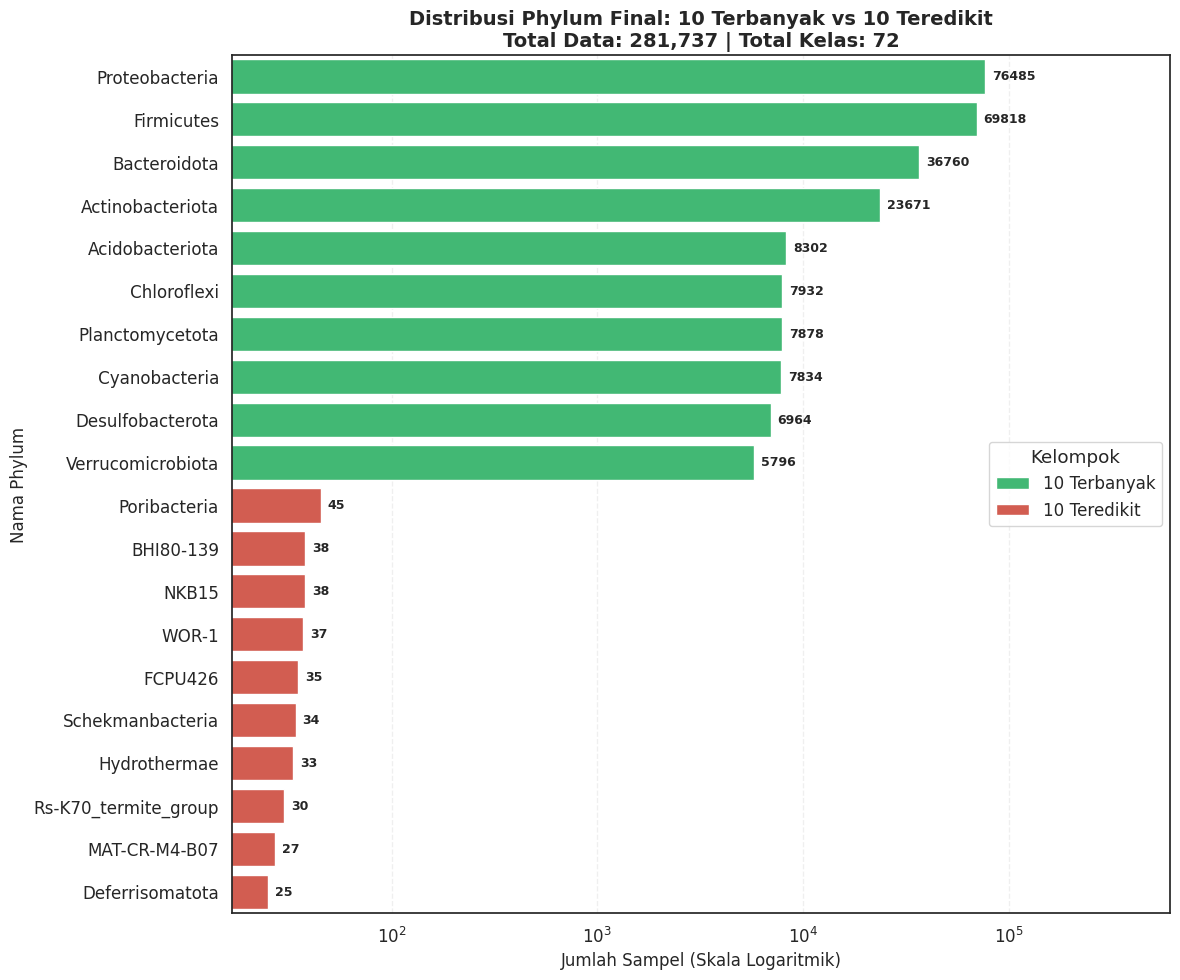

MENYIMPAN DATA FINAL...
-> File 'DATA_FILTERING_DAN_PENGHAPUSAN.csv' berhasil disimpan!
PREVIEW DATA FINAL ('df_final'):


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
0,CP013078.2406498.2408039,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella_pertussis
1,CP015924.1224168.1225721,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
3,LS483321.16842.18378,TAG...ACA,427,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_pyogenes
4,CP012870.431955.433510,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia-Shigella,Escherichia_coli
5,CP014215.3774401.3775944,TGG...ACA,428,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,Acinetobacter_baumannii
8,CP013137.1735609.1737165,TAG...ACA,427,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,Staphylococcus_aureus
9,CP013963.1400445.1401937,TGG...ACA,402,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Rhizobiaceae,Brucella,Brucella_suis
10,CP013245.3226579.3228122,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas_aeruginosa
11,CP013289.1712880.1714440,TAG...ACA,427,Bacteria,Firmicutes,Bacilli,Lactobacillales,Listeriaceae,Listeria,Listeria_monocytogenes
18,CP014004.4881510.4883063,TGG...ACA,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella_pneumoniae



Waktu eksekusi total: 12.96 detik


In [9]:
print("TAHAP 2: PREPROCESSING DATA")
start_time = time.time()
# 1. FILTER DOMAIN & HAPUS MISSING VALUES
df_processed = df_processed[df_processed['Domain'] == 'Bacteria'].copy()
df_processed = df_processed.dropna(subset=['Phylum', 'sequence']).copy()
print(f"-> 1-2. Filter Bacteria & Drop NaN: {len(df_processed):,} baris")
# 2. STANDARDISASI TEKS
df_processed['sequence'] = df_processed['sequence'].astype(str).str.upper().str.strip()
print(f"-> 3. Standardisasi Teks: {len(df_processed):,} baris")
# [SNAPSHOT 1] Data Mentah
count_raw = df_processed['Phylum'].value_counts().rename('1. Raw (Sebelum Eliminasi)')
# 4. ELIMINASI DATA DUPLIKAT & EXPORT CSV
print("\n[PROSES Eliminasi Data Duplikat & Simpan Data]")
n_before = len(df_processed)
# SIMPAN DATA 
df_cek_duplikat = df_processed[df_processed.duplicated(subset=['sequence'], keep=False)].copy()
if not df_cek_duplikat.empty:
    # Urutkan berdasarkan sequence agar yang sama nempel atas-bawah
    df_cek_duplikat = df_cek_duplikat.sort_values(by='sequence')
    nama_file_cek = 'Cek_Data_Duplikat.csv'
    df_cek_duplikat.to_csv(nama_file_cek, index=False)
    print(f"   -> BERHASIL! File '{nama_file_cek}' disimpan.")
    print(f"      (Silakan buka file ini untuk melihat sekuens yang sama persis bersebelahan)")
else:
    print("   -> Tidak ada duplikat yang ditemukan.")
# EKSEKUSI PENGHAPUSAN
df_processed = df_processed.drop_duplicates(subset=['sequence'], keep='first')
n_after = len(df_processed)
n_removed = n_before - n_after
print(f"-> 4. Eliminasi Duplikat: {n_after:,} baris (Dihapus: {n_removed:,} sekuens kembar)")
# [SNAPSHOT 2] Data Unik
count_dedup = df_processed['Phylum'].value_counts().rename('2. Unik (Sesudah Eliminasi)')

# 5. FILTER KELAS MINORITAS (n >= 25)
MINIMUM_SAMPEL = 25
class_counts = df_processed['Phylum'].value_counts()
class_to_keep = class_counts[class_counts >= MINIMUM_SAMPEL].index
df_final = df_processed[df_processed['Phylum'].isin(class_to_keep)].copy()
n_phylum_akhir = len(class_to_keep)
print(f"-> 5. Filter n >= {MINIMUM_SAMPEL}: {len(df_final):,} baris")
print(f"-> Total Phylum Final: {n_phylum_akhir} kelas.")
# [SNAPSHOT 3] Final
count_final = df_final['Phylum'].value_counts().rename('3. Final')

# A. TABEL PERBANDINGAN LENGKAP
print("TABEL 1: DAMPAK ELIMINASI& FILTERING DATA")

comparison_df = pd.concat([count_raw, count_dedup, count_final], axis=1).fillna(0).astype(int)
comparison_df['Duplikat Dibuang'] = comparison_df['1. Raw (Sebelum Eliminasi)'] - comparison_df['2. Unik (Sesudah Eliminasi)']
comparison_df['% Redundansi'] = (comparison_df['Duplikat Dibuang'] / comparison_df['1. Raw (Sebelum Eliminasi)'] * 100).round(2)
comparison_df['Status'] = comparison_df['3. Final'].apply(lambda x: 'Lolos' if x > 0 else 'Dibuang')
comparison_df = comparison_df.sort_values(by='1. Raw (Sebelum Eliminasi)', ascending=False)

cols_show = ['1. Raw (Sebelum Eliminasi)', '2. Unik (Sesudah Eliminasi)', 'Duplikat Dibuang', '% Redundansi', '3. Final', 'Status']
display(comparison_df[cols_show])

# B. VISUALISASI Dampak Eliminasi Data Duplikat
plt.figure(figsize=(14, 8))
top_20 = comparison_df.head(20).reset_index().rename(columns={'index': 'Phylum'})
melted_plot = top_20.melt(id_vars='Phylum', 
                          value_vars=['1. Raw (Sebelum Eliminasi)', '2. Unik (Sesudah Eliminasi)'], 
                          var_name='Kondisi Data', 
                          value_name='Jumlah Sampel')

ax = sns.barplot(data=melted_plot, x='Jumlah Sampel', y='Phylum', hue='Kondisi Data', palette='muted')

plt.title(f'Dampak Eliminasi Duplikat pada 20 Phylum Teratas', fontsize=14, fontweight='bold')
plt.ylabel('Phylum', fontsize=12)
plt.xlabel('Jumlah Sampel (Skala Logaritmik)', fontsize=12)
plt.xscale('log') 
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.legend(title='Status Data', loc='lower right', frameon=True)
# Label Angka
max_val = melted_plot['Jumlah Sampel'].max()
plt.xlim(right=max_val * 8)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=9, fontweight='bold')
plt.tight_layout()
nama_file_1 = "Dampak_Eliminasi.png"
plt.savefig(nama_file_1, dpi=300, bbox_inches='tight')
print(f"-> Grafik 1 Tersimpan: {nama_file_1}")
plt.show()

# Visualisasi Distribusi Final
final_counts_sorted = count_final.sort_values(ascending=False)
if len(final_counts_sorted) > 20:
    top_10 = final_counts_sorted.head(10).reset_index()
    top_10.columns = ['Phylum', 'Jumlah']; top_10['Kelompok'] = '10 Terbanyak'
    bot_10 = final_counts_sorted.tail(10).reset_index()
    bot_10.columns = ['Phylum', 'Jumlah']; bot_10['Kelompok'] = '10 Teredikit'
    plot_data = pd.concat([top_10, bot_10])
else:
    plot_data = final_counts_sorted.reset_index()
    plot_data.columns = ['Phylum', 'Jumlah']; plot_data['Kelompok'] = 'Semua Kelas'

plt.figure(figsize=(12, 10))
ax = sns.barplot(data=plot_data, y='Phylum', x='Jumlah', hue='Kelompok', 
                 palette={'10 Terbanyak': '#2ecc71', '10 Teredikit': '#e74c3c', 'Semua Kelas': '#3498db'}, 
                 dodge=False)

plt.xscale('log') 
plt.title(f'Distribusi Phylum Final: 10 Terbanyak vs 10 Teredikit\nTotal Data: {len(df_final):,} | Total Kelas: {n_phylum_akhir}', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Sampel (Skala Logaritmik)', fontsize=12)
plt.ylabel('Nama Phylum', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Label Angka
max_val_2 = plot_data['Jumlah'].max()
plt.xlim(right=max_val_2 * 8)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5, fontsize=9, fontweight='bold')
plt.tight_layout()
nama_file_2 = "Distribusi Kelas Filtering & Penghapusan Data.png"
plt.savefig(nama_file_2, dpi=300, bbox_inches='tight')
print(f"-> Grafik 2 Tersimpan: {nama_file_2}")
plt.show()

# OUTPUT FINAL KE CSV
print("MENYIMPAN DATA FINAL...")
nama_file_final = 'DATA_FILTERING_DAN_PENGHAPUSAN.csv'
df_final.to_csv(nama_file_final, index=False)
print(f"-> File '{nama_file_final}' berhasil disimpan!")

print("PREVIEW DATA FINAL ('df_final'):")
df_preview = df_final.copy()
df_preview['sequence'] = df_preview['sequence'].apply(lambda s: f"{str(s)[:3]}...{str(s)[-3:]}")
display(df_preview.head(10))

end_time = time.time()
print(f"\nWaktu eksekusi total: {end_time - start_time:.2f} detik")

## Penanganan Ambiguitas Code menggunakan Random Replacement

### Periksa Character Unik awal

In [10]:
# Melihat karakter unik di kolom 'sequence'
unique_characters = set("".join(df_final['sequence'].dropna()))  # Gabungkan semua sekuens dan ambil karakter unik
print("Karakter unik di kolom 'sequence':")
print(unique_characters)

Karakter unik di kolom 'sequence':
{'T', 'Y', 'V', 'D', 'G', 'R', 'W', 'H', 'C', 'N', 'K', 'A', 'S', 'B', 'M'}


PENANGANAN KODE AMBIGUITAS
Proses cleaning sedang berjalan...


100%|██████████| 281737/281737 [00:07<00:00, 38790.83it/s]


STATISTIK HASIL CLEANING
----------------------------------------
Total Sekuens Awal          : 281,737
Sekuens yang Berubah        : 11,402 (4.05%)
Total Karakter Ambiguitas   : 16,415
Detail Ambiguitas Ditemukan :
Counter({'N': 11525, 'R': 1476, 'Y': 995, 'S': 925, 'K': 623, 'M': 399, 'W': 391, 'H': 26, 'V': 20, 'D': 19, 'B': 16})


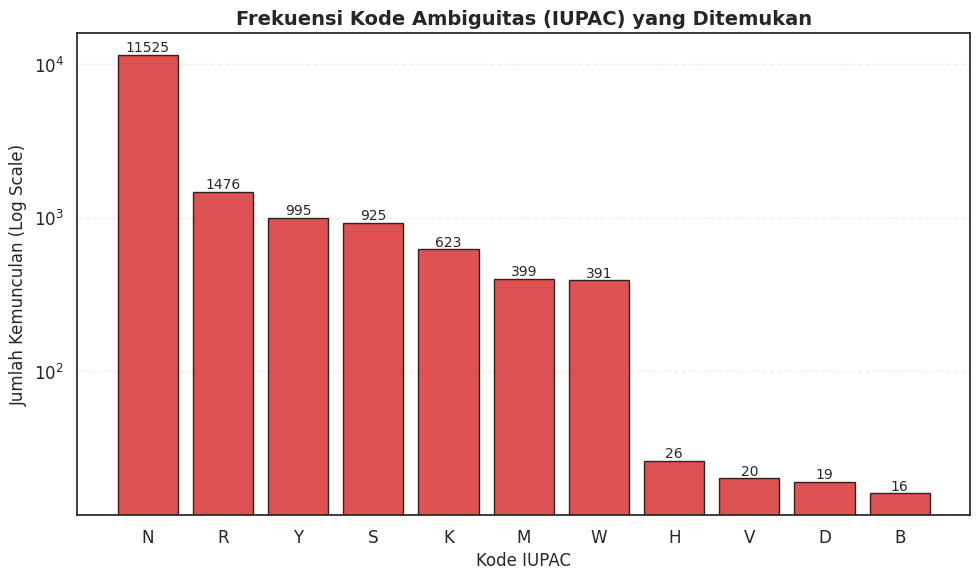

Grafik Tersimpan

[SELESAI] Waktu Eksekusi: 8.52 detik
Total Data Bersih di df_final: 281,737 baris


In [11]:
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

print("PENANGANAN KODE AMBIGUITAS")
# 1. SETUP & DEFINISI RULES
tqdm.pandas()
start_time = time.time()
random.seed(42)

# Dictionary IUPAC (Sesuai kode lama Anda)
iupac_random = {
    'N': ['A', 'C', 'G', 'T'], 'R': ['A', 'G'], 'Y': ['C', 'T'],
    'S': ['G', 'C'], 'W': ['A', 'T'], 'K': ['G', 'T'],
    'M': ['A', 'C'], 'B': ['C', 'G', 'T'], 'D': ['A', 'G', 'T'],
    'H': ['A', 'C', 'T'], 'V': ['A', 'C', 'G']
}
good_bases = {'A', 'T', 'G', 'C'}

# Variabel Global untuk menampung hitungan agar bisa divisualisasikan
global_ambiguity_counts = Counter()

# 2. FUNGSI Random Replacement
def random_clean(seq):
    if not isinstance(seq, str):
        return ""    
    
    seq = seq.upper()
    cleaned_seq = []    
    
    for base in seq:
        if base in good_bases:
            cleaned_seq.append(base)
        elif base in iupac_random:
            # [BARU] Tambahkan baris ini untuk mencatat statistik
            global_ambiguity_counts[base] += 1 
            
            # Logika lama Anda (tidak berubah)
            cleaned_seq.append(random.choice(iupac_random[base]))
        # else: Karakter lain dibuang (sesuai logika lama)
            
    return "".join(cleaned_seq)

# 3. EKSEKUSI CLEANING
print("Proses cleaning sedang berjalan...")
# Kita copy dulu agar bisa dibandingkan before-after
df_final_clean = df_final.copy() 
df_final_clean['sequence_cleaned'] = df_final_clean['sequence'].progress_apply(random_clean)

# 4. HITUNG STATISTIK PERUBAHAN
# Cek baris mana saja yang berubah (Before vs After)
mask_changed = df_final_clean['sequence'] != df_final_clean['sequence_cleaned']
total_sequences_changed = mask_changed.sum()
total_ambiguous_chars = sum(global_ambiguity_counts.values())

print("STATISTIK HASIL CLEANING")
print("-" * 40)
print(f"Total Sekuens Awal          : {len(df_final_clean):,}")
print(f"Sekuens yang Berubah        : {total_sequences_changed:,} ({(total_sequences_changed/len(df_final_clean)*100):.2f}%)")
print(f"Total Karakter Ambiguitas   : {total_ambiguous_chars:,}")
print("Detail Ambiguitas Ditemukan :")
print(global_ambiguity_counts)

# 5. VISUALISASI
# A. Grafik Distribusi Ambiguitas (Bar Chart)
if total_ambiguous_chars > 0:
    plt.figure(figsize=(10, 6))
    # Ambil data dari Counter
    labels, values = zip(*global_ambiguity_counts.most_common())
    # Gambar Grafik
    bars = plt.bar(labels, values, color='#d62728', alpha=0.8, edgecolor='black')
    plt.title('Frekuensi Kode Ambiguitas (IUPAC) yang Ditemukan', fontsize=14, fontweight='bold')
    plt.xlabel('Kode IUPAC', fontsize=12)
    plt.ylabel('Jumlah Kemunculan (Log Scale)', fontsize=12)
    plt.yscale('log') # Log scale agar grafik terbaca jika 'N' sangat banyak
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # Label angka di atas batang
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig('Distribusi_Ambiguitas.png', dpi=300)
    plt.show()
    print("Grafik Tersimpan")

# 6. FINALISASI DATA
# Update kolom sequence utama dengan yang sudah bersih
df_final['sequence'] = df_final_clean['sequence_cleaned']
end_time = time.time()

print(f"\n[SELESAI] Waktu Eksekusi: {end_time - start_time:.2f} detik")
print(f"Total Data Bersih di df_final: {len(df_final):,} baris")

### Periksa Character Unik Akhir

In [12]:
# Melihat karakter unik di kolom 'sequence'
unique_characters = set("".join(df_final['sequence'].dropna()))  # Gabungkan semua sekuens dan ambil karakter unik
print("Karakter unik di kolom 'sequence':")
print(unique_characters)
df_final.head(100)

Karakter unik di kolom 'sequence':
{'T', 'G', 'A', 'C'}


,feature_id,sequence,seq_length,Domain,Phylum,Class,Order,Family,Genus,Species
0,CP013078.2406498.2408039,TGGGGAATTTTGGACAATGGGGGCAACCCTGATCCAGCCATCCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella_pertussis
1,CP015924.1224168.1225721,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica
3,LS483321.16842.18378,TAGGGAATCTTCGGCAATGGGGGCAACCCTGACCGAGCAACGCCGC...,427,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_pyogenes
4,CP012870.431955.433510,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia-Shigella,Escherichia_coli
5,CP014215.3774401.3775944,TGGGGAATATTGGACAATGGGGGGAACCCTGATCCAGCCATGCCGC...,428,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,Acinetobacter_baumannii
...,...,...,...,...,...,...,...,...,...,...
291,CP014643.245388.246944,TAGGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGC...,427,Bacteria,Firmicutes,Bacilli,Bacillales,Planococcaceae,Lysinibacillus,Lysinibacillus_sphaericus
297,CP022508.192175.193708,TAGGGAATTTTTCACAATGGACGAAAGTCTGATGAAGCAATGCCGC...,426,Bacteria,Firmicutes,Bacilli,Entomoplasmatales,Entomoplasmataceae,Mesoplasma,Mesoplasma_florum
306,CP001157.4279431.4280965,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Azotobacter,Azotobacter_vinelandii
308,CP002773.5261764.5263293,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,427,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia_plymuthica


## Ekstraksi Fitur K-mer

In [13]:
tqdm.pandas()
K_VALUE = 4
print(f"STEP 8: EKSTRAKSI FITUR K-MER (K={K_VALUE})")

start_time = time.time()
# 1. DEFINISI FUNGSI EKSTRAKSI
def get_kmers(sequence, k):
    # Validasi input harus string
    if not isinstance(sequence, str) or len(sequence) < k: 
        return ""
    # List comprehension (Sliding Window)
    # Contoh: "ATCG", k=3 -> ["ATC", "TCG"]
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    # Gabungkan jadi string dengan spasi ("ATC TCG")
    return " ".join(kmers)

# 2. EKSEKUSI PADA DATAFRAME
print(f"[PROCESS] Mengonversi DNA ke string K-mer (k={K_VALUE})...")
df_final['kmers'] = df_final['sequence'].progress_apply(lambda x: get_kmers(x, k=K_VALUE))

# 3. LAPORAN STATISTIK
n_samples = len(df_final)
theoretical_features = 4 ** K_VALUE  # Kombinasi A,T,C,G pangkat K
print("STATISTIK EKSTRAKSI FITUR:")
print(f"-> Jumlah Sampel         : {n_samples:,} baris")
print(f"-> Panjang K-mer (K)     : {K_VALUE}")
print(f"-> Dimensi Fitur Yang Terbentuk   : {theoretical_features:,} fitur (4^{K_VALUE})")

# 4. PREVIEW HASIL
print("[PREVIEW HASIL K-MER]")
pd.set_option('display.max_colwidth', None)
# Menampilkan kolom ID, Phylum (Target), dan K-mers (Fitur)
cols_preview = ['feature_id', 'Phylum', 'kmers']
display(df_final[cols_preview].head(3))
print("...")
display(df_final[cols_preview].tail(3))

# 5. MENYIMPAN HASIL KE CSV
print("MENYIMPAN DATASET")
output_filename = f'DATA_KMER_K{K_VALUE}.csv'
cols_to_save = ['feature_id', 'sequence', 'kmers', 'Phylum']
df_final[cols_to_save].to_csv(output_filename, index=False)
print(f"-> SUKSES! File '{output_filename}' berhasil disimpan.")
end_time = time.time()
print(f"Waktu Eksekusi Total: {end_time - start_time:.2f} detik")

STEP 8: EKSTRAKSI FITUR K-MER (K=4)
[PROCESS] Mengonversi DNA ke string K-mer (k=4)...


100%|██████████| 281737/281737 [00:13<00:00, 20389.14it/s]

STATISTIK EKSTRAKSI FITUR:
-> Jumlah Sampel         : 281,737 baris
-> Panjang K-mer (K)     : 4
-> Dimensi Fitur Yang Terbentuk   : 256 fitur (4^4)
[PREVIEW HASIL K-MER]


,feature_id,Phylum,kmers
0,CP013078.2406498.2408039,Proteobacteria,TGGG GGGG GGGA GGAA GAAT AATT ATTT TTTT TTTG TTGG TGGA GGAC GACA ACAA CAAT AATG ATGG TGGG GGGG GGGG GGGC GGCA GCAA CAAC AACC ACCC CCCT CCTG CTGA TGAT GATC ATCC TCCA CCAG CAGC AGCC GCCA CCAT CATC ATCC TCCC CCCG CCGC CGCG GCGT CGTG GTGT TGTG GTGC TGCG GCGA CGAT GATG ATGA TGAA GAAG AAGG AGGC GGCC GCCT CCTT CTTC TTCG TCGG CGGG GGGT GGTT GTTG TTGT TGTA GTAA TAAA AAAG AAGC AGCA GCAC CACT ACTT CTTT TTTT TTTG TTGG TGGC GGCA GCAG CAGG AGGA GGAA GAAA AAAG AAGA AGAA GAAA AAAC AACG ACGG CGGC GGCA GCAC CACG ACGG CGGG GGGC GGCT GCTA CTAA TAAT AATA ATAT TATC ATCC TCCT CCTG CTGT TGTG GTGC TGCA GCAA CAAC AACT ACTG CTGA TGAC GACG ACGG CGGT GGTA GTAC TACC ACCT CCTG CTGC TGCA GCAG CAGA AGAA GAAT AATA ATAA TAAG AAGC AGCA GCAC CACC ACCG CCGG CGGC GGCT GCTA CTAA TAAC AACT ACTA CTAC TACG ACGT CGTG GTGC TGCC GCCA CCAG CAGC AGCA GCAG CAGC AGCC GCCG CCGC CGCG GCGG CGGT GGTA GTAA TAAT AATA ATAC TACG ACGT CGTA GTAG TAGG AGGG GGGT GGTG GTGC TGCA GCAA CAAG AAGC AGCG GCGT CGTT GTTA TTAA TAAT AATC ATCG TCGG CGGA GGAA GAAT AATT ATTA TTAC TACT ACTG CTGG TGGG GGGC GGCG GCGT CGTA GTAA TAAA AAAG AAGC AGCG GCGT CGTG GTGC TGCG GCGC CGCA GCAG CAGG AGGC GGCG GCGG CGGT GGTT GTTC TTCG TCGG CGGA GGAA GAAA AAAG AAGA AGAA GAAA AAAG AAGA AGAT GATG ATGT TGTG GTGA TGAA GAAA AAAT AATC ATCC TCCC CCCA CCAG CAGG AGGG GGGC GGCT GCTT CTTA TTAA TAAC AACC ACCT CCTT CTTG TTGG TGGA GGAA GAAC AACT ACTG CTGC TGCA GCAT CATT ATTT TTTT TTTT TTTA TTAA TAAC AACT ACTA CTAC TACC ACCG CCGG CGGG GGGC GGCT GCTA CTAG TAGA AGAG GAGT AGTG GTGT TGTG GTGT TGTC GTCA TCAG CAGA AGAG GAGG AGGG GGGA GGAG GAGG AGGT GGTG GTGG TGGA GGAA GAAT AATT ATTC TTCC TCCG CCGC CGCG GCGT CGTG GTGT TGTA GTAG TAGC AGCA GCAG CAGT AGTG GTGA TGAA GAAA AAAT AATG ATGC TGCG GCGT CGTA GTAG TAGA AGAT GATA ATAT TATG ATGC TGCG GCGG CGGA GGAG GAGG AGGA GGAA GAAC AACA ACAC CACC ACCG CCGA CGAT GATG ATGG TGGC GGCG GCGA CGAA GAAG AAGG AGGC GGCA GCAG CAGC AGCC GCCT CCTC CTCC TCCT CCTG CTGG TGGG GGGA GGAT GATA ATAA TAAC AACA ACAC CACT ACTG CTGA TGAC GACG ACGC CGCT GCTC CTCA TCAT CATG ATGC TGCA GCAC CACG ACGA CGAA GAAA AAAG AAGT AGTG GTGT TGTG GTGG TGGG GGGG GGGA GGAG GAGC AGCA GCAA CAAA AAAC AACA
1,CP015924.1224168.1225721,Proteobacteria,TGGG GGGG GGGA GGAA GAAT AATA ATAT TATT ATTG TTGC TGCA GCAC CACA ACAA CAAT AATG ATGG TGGG GGGC GGCG GCGC CGCA GCAA CAAG AAGC AGCC GCCT CCTG CTGA TGAT GATG ATGC TGCA GCAG CAGC AGCC GCCA CCAT CATG ATGC TGCC GCCG CCGC CGCG GCGT CGTG GTGT TGTA GTAT TATG ATGA TGAA GAAG AAGA AGAA GAAG AAGG AGGC GGCC GCCT CCTT CTTC TTCG TCGG CGGG GGGT GGTT GTTG TTGT TGTA GTAA TAAA AAAG AAGT AGTA GTAC TACT ACTT CTTT TTTC TTCA TCAG CAGC AGCG GCGG CGGG GGGG GGGA GGAG GAGG AGGA GGAA GAAG AAGG AGGT GGTG GTGT TGTT GTTG TTGT TGTG GTGG TGGT GGTT GTTA TTAA TAAT AATA ATAA TAAC AACC ACCG CCGC CGCA GCAG CAGC AGCA GCAA CAAT AATT ATTG TTGA TGAC GACG ACGT CGTT GTTA TTAC TACC ACCC CCCG CCGC CGCA GCAG CAGA AGAA GAAG AAGA AGAA GAAG AAGC AGCA GCAC CACC ACCG CCGG CGGC GGCT GCTA CTAA TAAC AACT ACTC CTCC TCCG CCGT CGTG GTGC TGCC GCCA CCAG CAGC AGCA GCAG CAGC AGCC GCCG CCGC CGCG GCGG CGGT GGTA GTAA TAAT AATA ATAC TACG ACGG CGGA GGAG GAGG AGGG GGGT GGTG GTGC TGCA GCAA CAAG AAGC AGCG GCGT CGTT GTTA TTAA TAAT AATC ATCG TCGG CGGA GGAA GAAT AATT ATTA TTAC TACT ACTG CTGG TGGG GGGC GGCG GCGT CGTA GTAA TAAA AAAG AAGC AGCG GCGC CGCA GCAC CACG ACGC CGCA GCAG CAGG AGGC GGCG GCGG CGGT GGTC GTCT TCTG CTGT TGTC GTCA TCAA CAAG AAGT AGTC GTCG TCGG CGGA GGAT GATG ATGT TGTG GTGA TGAA GAAA AAAT AATC ATCC TCCC CCCC CCCG CCGG CGGG GGGC GGCT GCTC CTCA TCAA CAAC AACC ACCT CCTG CTGG TGGG GGGA GGAA GAAC AACT ACTG CTGC TGCA GCAT CATT ATTC TTCG TCGA CGAA GAAA AAAC AACT ACTG CTGG TGGC GGCA GCAG CAGG AGGC GGCT GCTT CTTG TTGA TGAG GAGT AGTC GTCT TCTT CTTG TTGT TGTA GTAG TAGA AGAG GAGG AGGG GGGG GGGG GGGG GGGT GGTA GTAG TAGA AGAA GAAT AATT ATTC TTCC TCCA CCAG CAGG AGGT GGTG GTGT TGTA GTAG TAGC AGCG GCGG CGGT GGTG GTGA TGAA GAAA AAAT AATG ATGC TGCG GCGT CGTA GTAG TAGA AGAG GAGA AGAT GATC ATCT TCTG CTGG TGGA GGAG GAGG A

...


,feature_id,Phylum,kmers
397640,Z96097.1.1471,Proteobacteria,TGGG GGGG GGGA GGAA GAAT AATA ATAT TATT ATTG TTGC TGCA GCAC CACA ACAA CAAT AATG ATGG TGGG GGGG GGGG GGGA GGAA GAAA AAAC AACC ACCC CCCT CCTG CTGA TGAT GATG ATGC TGCA GCAG CAGC AGCC GCCA CCAT CATG ATGC TGCC GCCG CCGC CGCG GCGT CGTG GTGT TGTG GTGT TGTG GTGA TGAA GAAG AAGA AGAA GAAG AAGG AGGC GGCC GCCT CCTT CTTC TTCG TCGG CGGG GGGT GGTT GTTG TTGT TGTA GTAA TAAA AAAG AAGC AGCA GCAC CACT ACTT CTTT TTTC TTCA TCAG CAGC AGCG GCGG CGGG GGGG GGGA GGAG GAGG AGGA GGAA GAAG AAGG AGGC GGCG GCGA CGAT GATA ATAA TAAA AAAC AACT ACTT CTTA TTAA TAAT AATA ATAA TAAG AAGT AGTT GTTT TTTG TTGT TGTT GTTG TTGA TGAT GATT ATTG TTGA TGAC GACG ACGT CGTT GTTA TTAC TACC ACCC CCCG CCGC CGCA GCAG CAGA AGAA GAAG AAGA AGAA GAAG AAGC AGCA GCAC CACC ACCG CCGG CGGC GGCT GCTA CTAA TAAC AACT ACTC CTCC TCCG CCGT CGTG GTGC TGCC GCCA CCAG CAGC AGCA GCAG CAGC AGCC GCCG CCGC CGCG GCGG CGGT GGTA GTAA TAAT AATA ATAC TACG ACGG CGGA GGAG GAGG AGGG GGGT GGTG GTGC TGCA GCAA CAAG AAGC AGCG GCGT CGTT GTTA TTAA TAAT AATC ATCG TCGG CGGA GGAA GAAT AATG ATGA TGAC GACT ACTG CTGG TGGG GGGC GGCG GCGT CGTA GTAA TAAA AAAG AAGC AGCG GCGC CGCA GCAC CACG ACGC CGCA GCAG CAGG AGGC GGCG GCGG CGGT GGTG GTGT TGTG GTGT TGTT GTTA TTAA TAAG AAGT AGTT GTTG TTGG TGGA GGAT GATG ATGT TGTG GTGA TGAA GAAA AAAT AATC ATCC TCCC CCCC CCCG CCGG CGGG GGGC GGCT GCTC CTCA TCAA CAAC AACC ACCC CCCG CCGG CGGG GGGA GGAA GAAC AACA ACAG CAGC AGCA GCAT CATT ATTC TTCA TCAA CAAA AAAA AAAC AACT ACTG CTGA TGAC GACA ACAG CAGG AGGC GGCT GCTA CTAG TAGA AGAG GAGT AGTC GTCT TCTC CTCG TCGT CGTA GTAG TAGA AGAG GAGG AGGG GGGG GGGG GGGG GGGT GGTA GTAG TAGA AGAA GAAT AATT ATTC TTCC TCCA CCAG CAGG AGGT GGTG GTGT TGTA GTAG TAGC AGCG GCGG CGGT GGTG GTGA TGAA GAAA AAAT AATG ATGC TGCG GCGT CGTA GTAG TAGA AGAG GAGA AGAT GATC ATCT TCTG CTGG TGGA GGAG GAGG AGGA GGAA GAAT AATA ATAC TACC ACCG CCGG CGGT GGTG GTGG TGGC GGCG GCGA CGAA GAAG AAGG AGGC GGCG GCGG CGGC GGCC GCCC CCCC CCCC CCCT CCTG CTGG TGGA GGAC GACG ACGA CGAA GAAG AAGA AGAC GACT ACTG CTGA TGAC GACG ACGC CGCT GCTC CTCA TCAG CAGG AGGT GGTG GTGC TGCG GCGA CGAA GAAA AAAG AAGC AGCG GCGT CGTG GTGG TGGG GGGG GGGA GGAG GAGC AGCA GCAA CAAA AAAC AACA
397642,Z97069.1.1423,Actinobacteriota,TGGG GGGG GGGA GGAA GAAT AATA ATAT TATT ATTG TTGC TGCA GCAC CACA ACAA CAAT AATG ATGG TGGG GGGC GGCG GCGC CGCA GCAA CAAG AAGC AGCC GCCT CCTG CTGA TGAT GATG ATGC TGCA GCAG CAGC AGCG GCGA CGAC GACG ACGC CGCC GCCG CCGC CGCG GCGT CGTG GTGG TGGG GGGG GGGG GGGA GGAT GATT ATTG TTGA TGAA GAAG AAGG AGGC GGCT GCTT CTTC TTCG TCGG CGGG GGGT GGTT GTTG TTGT TGTA GTAA TAAA AAAC AACT ACTC CTCC TCCT CCTT CTTT TTTC TTCG TCGC CGCC GCCC CCCG CCGG CGGG GGGA GGAC GACG ACGA CGAA GAAG AAGC AGCC GCCC CCCA CCAC CACC ACCT CCTG CTGG TGGT GGTG GTGG TGGG GGGT GGTG GTGA TGAC GACG ACGG CGGT GGTA GTAC TACC ACCG CCGT CGTG GTGG TGGA GGAG GAGA AGAA GAAG AAGA AGAA GAAG AAGC AGCA GCAC CACC ACCG CCGG CGGC GGCT GCTA CTAA TAAC AACT ACTA CTAC TACG ACGT CGTG GTGC TGCC GCCA CCAG CAGC AGCA GCAG CAGC AGCC GCCG CCGC CGCG GCGG CGGT GGTA GTAA TAAT AATA ATAC TACG ACGT CGTA GTAG TAGG AGGG GGGT GGTG GTGC TGCA GCAA CAAG AAGC AGCG GCGT CGTT GTTG TTGT TGTC GTCC TCCG CCGG CGGA GGAT GATT ATTT TTTA TTAC TACT ACTG CTGG TGGG GGGC GGCG GCGT CGTA GTAA TAAA AAAG AAGA AGAG GAGC AGCT GCTC CTCG TCGT CGTA GTAG TAGG AGGT GGTG GTGG TGGT GGTG GTGT TGTG GTGT TGTC GTCG TCGC CGCG GCGT CGTC GTCG TCGT CGTC GTCT TCTG CTGT TGTG GTGA TGAA GAAA AAAT AATT ATTC TTCC TCCG CCGG CGGG GGGG GGGC GGCT GCTT CTTA TTAA TAAC AACT ACTC CTCC TCCG CCGG CGGG GGGC GGCG GCGT CGTG GTGC TGCA GCAG CAGG AGGC GGCG GCGA CGAT GATA ATAC TACG ACGG CGGG GGGC GGCA GCAC CACG ACGA CGAC GACT ACTA CTAG TAGA AGAG GAGT AGTG GTGC TGCT GCTG CTGT TGTA GTAG TAGG AGGG GGGG GGGT GGTA GTAA TAAC AACT ACTG CTGG TGGA GGAA GAAT AATT ATTC TTCC TCCT CCTG CTGG TGGT GGTG GTGT TGTA GTAG TAGC AGCG GCGG CGGT GGTG GTGA TGAA GAAA AAAT AATG ATGC TGCG GCGC CGCA GCAG CAGA AGAT GATA ATAT TATC ATCA TCAG CAGG AGGA GGAG GAGG AGGA GGAA GAAC AACA ACAC CACC ACCG CCGA CGAT GATG ATGG TGGC GGCG G

MENYIMPAN DATASET
-> SUKSES! File 'DATA_KMER_K4.csv' berhasil disimpan.
Waktu Eksekusi Total: 33.01 detik


## Split Data

In [14]:
from tqdm.auto import tqdm
tqdm.pandas()
#PEMBAGIAN DATA
print("Pembagian Data")
X = df_final['kmers'] 
y = df_final['Phylum']
total_data = X.shape[0]

# --- TAHAP 1: Pisahkan Data Uji (Test) 20% ---
# Stratify=y menjamin proporsi kelas di Test set sama dengan populasi asli
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # 20% untuk Testing
    random_state=42, 
    stratify=y
)
# --- TAHAP 2: Pisahkan Data Tuning 10% dari Total ---
# Kita ambil 12.5% dari SISA data (X_temp)
# Hitungan: 12.5% x 80% = 10% Total
X_train, X_tuning, y_train, y_tuning = train_test_split(
    X_temp, y_temp, 
    test_size=0.125,     
    random_state=42, 
    stratify=y_temp
)
# REKAPITULASI HASIL
print("STATISTIK DATASET SETELAH SPLIT")
print(f"Total Data Awal : {total_data:,} baris")
print(f"[1] Data Latih (70%) : {len(X_train):,} baris")
print(f"[2] Data Validasi (10%)   : {len(X_tuning):,} baris")
print(f"[3] Data Test (20%)  : {len(X_test):,} baris")

# SIMPAN DATA SPLIT KE CSV
print("\n Menyimpan Pembagian Data ke CSV...")
def save_split(X_data, y_data, name):
    df_temp = pd.DataFrame({'kmers': X_data, 'Phylum': y_data})
    df_temp.to_csv(f'DATA_{name}.csv', index=False)
    print(f"-> Tersimpan: DATA_{name}.csv")
save_split(X_train, y_train, "TRAIN")
save_split(X_tuning, y_tuning, "TUNING")
save_split(X_test, y_test, "TEST")

Pembagian Data
STATISTIK DATASET SETELAH SPLIT
Total Data Awal : 281,737 baris
[1] Data Latih (70%) : 197,215 baris
[2] Data Validasi (10%)   : 28,174 baris
[3] Data Test (20%)  : 56,348 baris

 Menyimpan Pembagian Data ke CSV...
-> Tersimpan: DATA_TRAIN.csv
-> Tersimpan: DATA_TUNING.csv
-> Tersimpan: DATA_TEST.csv


## Penghitungan Kmer menggunakan Countvectorizer

VEKTORISASI (COUNT VECTORIZER)
1. Fit & Transform X_train (197,215 sampel)...
2. Transform X_tuning (28,174 sampel)...
3. Transform X_test (56,348 sampel)...
-> Jumlah Fitur Unik (Vocabulary) : 256 k-mer

[PREVIEW] DATA TRAIN (5 Teratas & 5 Terbawah):


,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
84004,2,2,2,3,2,2,0,2,2,2,4,1,1,2,3,4,0,1,0,2,1,2,1,1,2,3,1,0,0,1,4,1,3,0,3,1,2,3,3,0,1,3,3,3,1,1,2,0,1,3,0,1,0,1,0,1,4,1,1,1,2,3,2,1,2,1,0,1,0,2,0,0,0,3,1,1,1,0,1,2,1,0,2,1,0,1,4,0,2,2,4,0,0,1,0,1,3,2,1,1,2,0,2,1,5,1,2,2,3,0,3,1,1,0,1,0,2,1,3,0,2,0,3,0,2,1,1,2,3,2,6,4,2,0,4,0,3,2,3,2,3,0,1,1,2,0,2,0,3,1,2,1,2,0,2,5,2,4,1,0,5,2,3,1,0,1,4,5,4,4,7,2,3,1,3,0,3,1,3,2,1,0,0,2,3,1,3,2,0,0,1,0,2,1,1,2,0,1,2,4,2,1,2,0,0,0,2,1,1,1,1,1,0,1,1,0,1,0,3,2,0,0,0,4,4,2,3,2,0,3,0,1,1,2,5,0,2,1,1,0,1,3,1,0,1,0,3,1,2,2,0,1,1,1,1,0
34895,5,2,5,2,1,1,0,4,3,5,4,1,3,1,5,2,1,2,0,0,1,0,1,2,1,0,3,0,3,1,2,0,3,0,2,2,4,2,3,2,4,4,6,1,0,1,3,0,2,2,0,1,1,1,1,1,2,2,1,1,0,1,1,1,0,2,2,2,0,1,0,1,0,2,3,2,0,1,0,0,0,0,2,0,0,0,0,0,0,5,1,1,0,1,3,0,4,0,0,0,3,0,2,1,3,1,1,3,2,0,2,2,1,2,5,1,2,1,0,3,4,1,1,1,0,0,1,1,5,1,4,6,1,0,3,0,0,2,6,1,2,0,1,1,4,0,3,1,1,0,2,1,3,1,2,5,4,3,1,0,8,1,4,1,0,1,4,4,6,2,3,3,3,1,3,1,4,1,3,0,0,1,0,1,2,2,3,1,2,1,1,0,4,1,2,1,1,2,1,1,4,2,2,0,0,2,1,0,1,0,2,0,0,0,4,1,0,0,2,0,2,1,1,2,1,3,3,1,1,1,2,1,1,2,4,1,3,0,0,1,1,0,0,1,0,2,1,1,0,0,2,1,0,2,0,2
117675,3,2,3,3,1,3,1,4,1,3,2,3,3,0,3,1,0,0,0,0,1,1,2,2,1,2,7,1,0,2,2,0,3,0,1,1,5,3,4,0,2,2,2,0,3,3,1,0,0,4,1,2,1,1,2,0,1,3,1,0,0,1,3,1,1,2,2,1,0,0,2,0,1,5,0,0,2,1,0,0,2,0,2,0,1,0,2,1,2,3,2,4,1,2,1,0,4,0,4,1,1,3,3,1,5,3,3,4,0,1,5,3,1,1,0,0,1,3,0,1,4,0,0,0,0,0,1,1,4,3,4,2,0,1,3,0,2,3,3,4,1,0,2,2,1,1,3,3,2,3,2,1,4,2,4,4,1,1,1,0,2,1,3,3,1,1,4,2,2,3,3,4,3,2,3,2,4,1,2,2,3,0,3,1,3,1,3,2,2,0,2,1,3,2,0,1,0,2,5,0,1,1,1,0,1,3,0,2,3,1,1,0,0,0,5,0,2,1,2,0,0,0,0,2,4,3,4,0,1,1,3,0,0,0,4,2,3,1,0,0,1,1,0,2,0,1,0,0,2,1,2,2,2,0,1,1
96647,1,3,3,2,2,2,1,3,1,4,3,2,2,1,3,2,0,2,0,0,0,5,0,0,2,2,2,2,1,0,5,0,1,0,3,1,2,3,3,2,2,2,4,3,0,0,4,1,1,1,0,2,0,0,1,2,2,1,1,0,1,0,2,0,2,1,2,1,0,1,0,1,1,4,2,1,0,0,0,0,0,0,3,0,1,2,4,1,0,3,2,2,0,0,1,1,4,2,2,0,4,1,2,0,3,3,1,3,4,0,4,1,1,1,1,0,0,0,3,1,4,3,3,0,1,1,0,2,4,2,4,4,1,2,4,1,2,1,3,2,1,1,1,0,5,0,4,0,2,1,3,1,4,1,4,4,2,2,2,3,6,1,2,2,1,1,4,4,3,4,6,3,3,1,4,2,3,1,4,1,1,0,0,0,2,4,4,2,0,1,2,1,2,2,1,1,0,0,3,1,1,1,3,0,1,1,0,1,1,0,1,0,0,0,0,0,2,1,2,1,0,2,2,0,3,5,1,0,2,2,4,3,3,1,5,1,2,0,0,0,1,1,0,0,1,0,2,1,1,3,1,0,0,2,1,0
175190,0,2,4,2,3,1,1,2,3,4,6,2,3,3,1,2,0,2,0,1,1,1,2,0,1,3,1,1,0,0,3,2,4,1,1,1,3,3,2,1,3,5,4,0,2,3,2,1,2,2,0,1,2,2,0,2,0,0,1,0,0,1,4,1,1,1,1,1,0,2,0,1,0,3,2,1,0,1,0,2,0,1,2,1,0,1,2,1,0,2,3,1,0,0,3,1,5,1,3,1,2,1,4,1,3,2,1,2,3,0,4,1,2,0,0,0,0,0,1,1,2,1,4,0,2,1,2,2,5,1,8,5,1,0,3,2,3,1,3,3,1,1,0,2,4,0,3,0,2,1,2,2,5,3,3,5,2,1,0,1,6,1,4,2,0,2,9,2,4,5,3,3,3,0,2,1,3,1,5,0,0,0,2,1,5,1,3,0,0,2,2,0,2,3,2,1,0,1,2,0,1,1,1,2,1,1,0,0,0,0,1,1,1,1,0,1,4,0,1,1,0,1,1,3,4,3,2,0,2,1,1,0,3,1,7,1,1,0,1,1,1,0,0,1,0,1,3,1,2,2,3,3,0,1,2,1
190115,0,2,4,2,2,0,1,4,1,4,4,1,3,0,4,1,1,1,0,0,1,2,1,0,2,2,2,2,1,0,4,1,2,0,3,2,3,3,4,1,5,4,0,1,1,0,4,0,1,2,0,3,0,0,0,1,2,3,2,1,

 Bentuk Matriks yang terbentuk: (197215, 256)

[PREVIEW] DATA TUNING (5 Teratas & 5 Terbawah):


,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
28945,0,3,5,2,2,3,1,2,4,5,2,0,2,1,1,6,1,2,1,0,2,1,3,0,3,2,4,0,0,1,2,1,5,1,6,1,2,3,3,2,2,2,1,4,2,0,1,0,0,3,0,1,0,0,1,1,1,1,1,1,1,3,4,2,2,0,1,1,0,1,2,1,1,2,1,1,0,0,1,0,1,1,2,0,0,0,1,1,2,2,2,1,0,0,1,1,5,2,2,1,1,1,2,1,4,1,1,5,3,0,2,2,2,0,2,0,0,1,0,2,3,2,1,1,1,1,2,2,6,3,5,3,2,0,5,0,6,2,4,2,2,0,1,2,2,0,1,1,2,0,2,1,4,0,2,4,4,1,1,2,4,1,3,2,0,0,4,4,4,1,3,0,2,2,4,1,3,2,3,2,2,0,1,1,3,1,2,3,0,2,1,1,2,2,0,4,1,2,1,1,2,1,2,0,0,1,1,2,0,1,1,0,0,1,1,0,1,1,3,2,0,1,3,2,3,3,3,1,1,1,1,1,0,4,3,0,3,2,2,1,3,0,0,1,0,1,4,2,3,0,3,3,2,1,2,1
15741,0,3,4,3,2,3,0,0,6,5,2,2,2,0,3,1,1,1,0,0,0,2,2,1,1,2,1,2,1,0,4,0,4,3,1,3,3,2,5,1,1,3,4,0,3,0,3,0,1,2,0,2,0,1,2,0,1,3,2,1,0,1,2,3,1,0,1,1,1,1,0,0,1,3,1,1,0,0,1,2,0,0,2,0,1,2,1,2,1,2,3,0,0,1,2,0,3,1,1,0,0,1,2,1,2,4,0,6,4,0,3,1,1,0,1,1,0,0,2,1,4,0,2,1,2,0,0,0,6,1,6,1,0,0,4,3,0,2,4,3,3,0,2,1,2,1,3,3,1,1,2,0,2,0,4,6,1,2,1,2,4,1,4,2,3,0,3,4,6,2,6,2,3,0,4,1,6,1,3,2,1,0,0,0,4,2,3,2,2,0,0,0,3,1,4,1,0,1,2,2,4,1,1,0,0,3,1,2,0,0,1,0,0,1,1,0,1,0,4,0,1,0,0,0,3,2,3,1,3,1,2,0,2,1,6,0,2,1,1,0,1,2,2,1,0,1,1,0,0,1,1,0,2,1,0,1
286024,0,1,4,2,2,2,1,2,1,3,3,2,2,0,3,2,0,1,0,0,1,1,0,1,2,3,2,2,2,0,4,1,1,0,3,2,2,3,3,1,6,3,2,2,0,1,3,0,1,2,0,3,0,0,0,1,2,1,1,1,1,2,2,3,0,2,0,1,0,1,2,0,1,3,1,1,0,0,0,1,0,1,2,0,0,0,1,2,0,2,2,0,1,0,3,0,3,1,0,1,2,1,2,1,3,1,2,3,4,0,3,1,1,1,4,0,1,0,0,0,3,1,4,2,0,2,0,1,5,2,4,2,0,0,4,2,2,2,4,0,4,0,2,3,2,1,3,1,2,1,2,0,3,1,4,6,1,1,2,0,6,2,4,4,1,0,6,2,4,3,4,3,2,1,5,0,4,1,4,0,1,1,0,2,3,3,5,1,0,0,1,0,2,2,1,2,0,0,2,3,2,1,5,1,0,1,0,2,1,0,1,0,0,1,1,1,0,0,1,0,2,0,1,2,3,3,1,2,2,1,3,0,3,2,6,0,3,2,1,0,1,1,1,0,0,2,1,2,1,1,0,2,2,1,1,0
297698,1,2,4,4,1,1,1,2,3,5,2,2,4,3,6,1,1,1,0,0,1,0,2,2,3,2,2,2,1,1,2,0,3,1,3,1,2,2,7,0,1,3,2,1,0,1,1,1,1,2,0,1,1,2,1,1,3,1,3,1,2,0,2,1,2,1,3,2,1,1,1,0,1,3,0,0,0,0,1,0,2,1,1,0,1,1,0,1,1,2,2,0,1,1,3,1,6,1,1,0,0,1,2,1,1,1,2,5,1,2,4,2,2,1,1,0,3,0,1,0,3,1,2,1,0,2,0,2,3,2,3,5,0,2,6,0,2,1,3,1,0,0,2,1,1,0,2,0,1,2,2,1,4,0,3,6,1,2,1,1,2,2,2,1,1,0,3,3,2,3,2,2,5,0,2,2,4,1,4,0,1,0,0,2,2,2,1,3,3,1,0,2,5,0,2,3,0,1,1,2,2,2,2,0,0,2,0,3,4,1,1,1,1,0,1,2,0,0,2,1,1,0,1,2,2,4,1,1,0,3,1,1,3,0,3,1,3,0,1,1,3,0,1,4,1,2,1,1,0,1,1,0,3,2,0,1
221004,1,2,3,1,2,1,3,3,1,2,3,1,2,0,3,2,1,1,2,0,0,0,3,1,1,2,5,2,1,0,1,2,3,1,0,1,2,2,6,1,4,3,4,1,1,0,2,0,0,2,0,2,1,1,0,0,1,1,1,1,1,2,2,0,0,3,0,1,0,1,0,0,3,4,2,1,0,0,0,1,1,0,2,0,0,0,0,0,3,2,3,0,0,1,3,2,5,1,1,1,1,2,2,1,2,2,3,7,3,1,3,1,0,1,0,0,0,0,1,2,3,0,2,2,2,3,1,1,4,3,4,4,1,1,4,1,1,4,4,1,2,1,1,0,1,0,3,1,2,0,2,3,4,2,4,5,0,1,1,2,5,2,5,1,2,2,5,1,6,4,3,2,3,2,5,2,3,2,4,0,0,3,1,1,5,2,3,2,0,1,3,0,2,1,0,1,2,1,3,0,0,1,3,0,0,1,0,2,1,0,3,0,1,0,3,2,0,0,2,1,0,1,2,1,2,3,4,1,0,1,2,1,1,1,5,2,2,2,2,1,1,1,0,1,3,2,1,1,1,1,2,2,0,1,0,0
230572,2,2,4,2,2,1,1,3,2,5,2,0,3,3,3,3,1,1,1,0,0,0,3,1,3,1,3,2,1,0,5,0,1,1,3,2,5,2,3,1,2,4,2,0,1,0,1,0,1,2,0,1,0,3,1,0,2,4,4,2

 Bentuk Matriks yang terbentuk: (28174, 256)

[PREVIEW] DATA TEST (5 Teratas & 5 Terbawah):


,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
45911,0,2,5,2,3,1,1,3,2,7,3,3,1,3,2,1,1,1,0,0,1,0,2,2,2,2,2,2,1,0,2,1,3,0,2,1,3,2,7,1,3,3,5,1,1,2,2,0,1,1,0,1,1,0,1,2,0,1,2,2,0,1,2,0,1,1,3,1,0,1,0,0,0,2,3,1,0,0,1,2,0,0,2,1,0,1,1,0,0,4,2,1,0,0,3,2,4,0,1,1,3,1,5,1,4,3,0,6,4,0,3,2,1,1,0,0,0,0,0,1,5,0,2,2,1,3,3,1,6,2,5,3,0,0,5,1,3,3,4,1,2,1,1,0,5,0,3,0,1,1,2,1,3,4,8,5,1,1,1,2,7,2,5,1,1,1,6,3,4,3,3,0,3,3,1,0,4,3,3,0,2,2,0,3,3,2,2,1,0,1,2,0,2,3,2,1,0,3,2,0,1,1,2,0,0,0,1,0,0,0,1,2,1,0,2,2,1,0,1,1,0,0,3,3,2,4,3,1,1,1,2,0,4,2,2,0,2,2,2,1,2,0,0,0,0,3,2,0,2,1,2,2,1,0,0,0
88926,2,5,2,1,5,2,1,5,2,2,4,4,1,1,3,2,4,1,1,0,2,2,0,0,1,2,2,2,1,2,5,0,2,0,1,2,1,2,4,0,4,3,1,3,1,0,5,1,1,0,0,2,1,0,1,0,1,2,2,0,1,1,2,0,2,4,4,1,2,2,1,0,1,2,0,1,0,0,1,0,2,1,1,0,1,1,1,1,0,2,3,0,1,0,2,0,3,1,0,0,1,1,2,1,3,2,2,4,2,0,2,1,1,2,0,0,2,1,1,0,3,1,3,2,0,1,0,1,3,3,6,4,0,0,4,0,1,1,5,1,2,0,1,1,2,2,2,0,1,0,3,1,2,1,4,3,1,2,1,1,10,0,5,1,1,1,3,3,5,2,3,2,4,2,3,0,3,1,6,0,1,1,0,1,2,2,4,3,0,0,4,1,3,1,0,1,0,0,1,3,1,2,2,1,0,1,0,1,3,1,0,1,0,1,1,1,1,0,2,0,0,0,1,1,1,3,2,1,3,1,1,1,4,1,6,0,3,1,1,3,0,1,0,0,1,1,1,1,1,1,1,3,0,2,0,2
36628,0,3,4,1,2,3,1,3,1,4,5,2,3,1,1,2,0,1,0,0,1,3,4,0,0,3,4,0,0,1,4,2,1,0,3,2,3,2,2,1,2,4,4,4,1,1,3,0,0,3,0,2,1,0,0,1,1,0,1,1,0,2,1,1,1,2,1,1,0,2,1,1,2,3,1,1,0,0,0,1,0,1,3,0,1,0,0,4,1,2,1,3,0,2,2,1,3,1,0,1,2,1,4,2,2,3,2,3,4,0,4,1,2,0,0,0,2,2,1,1,3,1,4,1,1,1,2,0,5,3,6,3,0,1,3,1,1,1,7,2,2,0,2,0,3,1,2,1,1,1,2,1,4,3,3,4,1,3,1,1,9,1,4,0,0,1,7,3,6,3,5,2,2,1,5,2,3,2,3,0,2,0,1,1,5,2,5,1,1,1,2,0,2,1,1,2,0,2,2,2,2,0,1,0,0,1,0,1,2,1,2,0,1,1,1,0,0,1,2,2,1,0,2,0,4,3,4,1,2,1,1,0,4,1,5,1,1,2,1,1,1,1,0,0,0,1,3,0,3,1,0,2,0,0,1,0
43629,1,2,3,1,2,2,2,3,0,3,4,2,2,1,2,3,0,0,2,1,1,1,0,3,1,4,1,1,0,1,4,0,1,1,5,1,3,3,2,0,2,3,4,2,2,0,3,0,0,2,0,0,0,2,2,0,1,1,1,2,1,3,1,1,1,1,1,2,0,1,1,0,2,3,1,2,0,2,0,1,0,2,3,0,1,2,2,1,0,2,3,0,0,0,5,0,4,0,0,0,2,1,4,2,2,2,1,6,4,1,2,1,1,0,1,0,0,0,0,1,3,1,5,2,1,1,1,0,3,3,4,4,1,0,4,1,3,0,5,1,0,1,3,0,5,0,2,1,2,1,2,1,3,3,4,5,2,0,1,2,6,2,3,2,1,1,7,3,4,5,3,3,4,2,5,1,4,2,5,0,2,0,1,1,2,2,7,3,1,0,1,1,2,3,1,1,1,2,0,1,3,2,1,0,0,0,0,2,0,0,1,1,1,2,1,0,0,0,3,2,0,0,1,1,3,3,1,1,2,1,2,0,5,2,7,1,1,1,4,1,2,0,0,2,0,2,2,0,2,1,1,0,1,0,1,2
350422,1,3,2,2,1,2,1,6,3,3,2,1,3,1,2,0,0,0,0,0,2,2,2,0,1,2,3,0,1,1,6,0,3,0,1,2,2,2,5,1,2,6,3,0,0,1,0,1,1,3,1,1,0,1,0,1,1,2,1,0,0,0,3,1,0,1,2,1,0,2,2,0,0,5,1,0,1,0,1,0,1,2,2,1,2,2,2,1,3,2,2,4,0,0,1,1,3,0,2,1,0,1,2,2,3,3,3,5,2,0,4,3,1,0,2,0,1,1,1,0,4,3,4,0,0,1,1,1,5,4,3,2,0,1,2,0,1,1,4,1,2,0,1,2,2,2,3,1,2,2,5,1,1,0,8,5,1,2,3,2,5,0,2,1,3,4,4,4,2,4,3,5,3,1,6,2,3,1,3,0,1,1,1,0,2,4,3,1,1,1,3,1,2,2,2,1,0,1,1,2,2,1,4,0,0,1,0,2,1,0,1,0,0,1,2,0,1,1,1,0,1,0,1,0,3,3,2,1,3,3,3,1,1,2,5,2,2,1,0,0,2,0,0,2,0,0,1,1,2,1,2,2,3,0,0,1
107563,0,1,5,1,3,2,1,2,2,8,4,0,3,1,2,2,0,3,1,0,2,2,1,2,0,0,2,1,0,2,4,1,3,0,2,2,4,3,6,0,5,3,2,3,0,0,4,0,2,2,1,2,0,1,1,0,0,2,1,1,

 Bentuk Matriks yang terbentuk: (56348, 256)
[STATISTIK MATRIKS GABUNGAN]
-> Total Sampel      : 281,737
-> Total Fitur       : 256
-> DENSITY (Isi)     : 75.1358%
-> SPARSITY (Kosong) : 24.8642%
Visualisasi K-mer Sparsity Analysis


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


-> Gambar disimpan: K-mer_Sparsity_Analysis.png


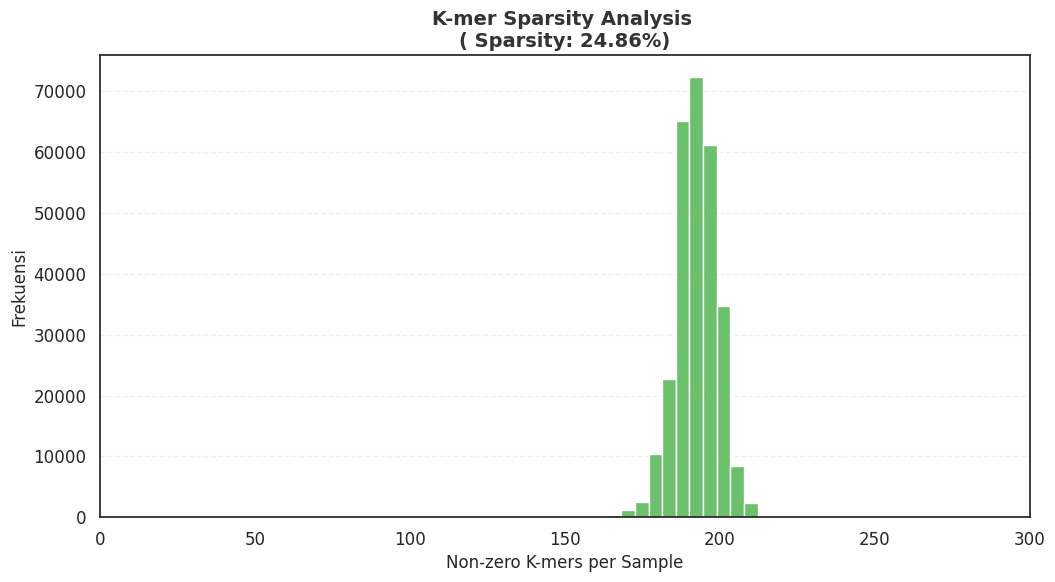

Total Waktu Proses: 55.77 detik


In [15]:
print("VEKTORISASI (COUNT VECTORIZER)")
start_time = time.time()
# 1. INISIALISASI & TRANSFORMASI
vectorizer = CountVectorizer()
# A. FIT & TRANSFORM DATA LATIH (X_train)
print(f"1. Fit & Transform X_train ({len(X_train):,} sampel)...")
X_train_vec = vectorizer.fit_transform(X_train)
# B. TRANSFORM DATA TUNING (X_tuning)
print(f"2. Transform X_tuning ({len(X_tuning):,} sampel)...")
X_tuning_vec = vectorizer.transform(X_tuning)
# C. TRANSFORM DATA UJI (X_test)
print(f"3. Transform X_test ({len(X_test):,} sampel)...")
X_test_vec = vectorizer.transform(X_test)
# Ambil nama fitur (K-mers)
feature_names = vectorizer.get_feature_names_out()
print(f"-> Jumlah Fitur Unik (Vocabulary) : {len(feature_names):,} k-mer")

# 2. PREVIEW Data
def preview_matrix(sparse_matrix, original_index, dataset_name):
    print(f"\n[PREVIEW] {dataset_name} (5 Teratas & 5 Terbawah):")    
    # Ambil 5 teratas
    head_data = sparse_matrix[:5].toarray()
    head_idx = original_index[:5]    
    # Ambil 5 terbawah
    tail_data = sparse_matrix[-5:].toarray()
    tail_idx = original_index[-5:]  
    # Gabungkan Data
    combined_data = np.vstack([head_data, tail_data])
    combined_idx = np.concatenate([head_idx, tail_idx])   
    # Buat DataFrame
    df_show = pd.DataFrame(combined_data, columns=feature_names, index=combined_idx)
    # Tampilkan
    display(df_show)
    print(f" Bentuk Matriks yang terbentuk: {sparse_matrix.shape}")

# Tampilkan Preview untuk semua set data
preview_matrix(X_train_vec, X_train.index, "DATA TRAIN")
preview_matrix(X_tuning_vec, X_tuning.index, "DATA TUNING")
preview_matrix(X_test_vec, X_test.index, "DATA TEST")

# 3. PERHITUNGAN SPARSITY (Gabungan)
print("[STATISTIK MATRIKS GABUNGAN]")
# Hitung statistik gabungan
total_nonzero = X_train_vec.nnz + X_tuning_vec.nnz + X_test_vec.nnz
total_samples = X_train_vec.shape[0] + X_tuning_vec.shape[0] + X_test_vec.shape[0]
n_features = X_train_vec.shape[1] 
total_elements = total_samples * n_features
density = (total_nonzero / total_elements) * 100
sparsity = 100 - density
print(f"-> Total Sampel      : {total_samples:,}")
print(f"-> Total Fitur       : {n_features:,}")
print(f"-> DENSITY (Isi)     : {density:.4f}%")
print(f"-> SPARSITY (Kosong) : {sparsity:.4f}%")

# 4. VISUALISASI HISTOGRAM (GABUNGAN)
print("Visualisasi K-mer Sparsity Analysis")
# 1. Ambil jumlah non-zero per baris dari masing-masing set
nnz_train = X_train_vec.getnnz(axis=1)
nnz_tune = X_tuning_vec.getnnz(axis=1)
nnz_test = X_test_vec.getnnz(axis=1)
# 2. Gabungkan list angkanya
all_nnz_counts = np.concatenate([nnz_train, nnz_tune, nnz_test])
# 3. Plotting
plt.figure(figsize=(12, 6))
sns.histplot(
    all_nnz_counts,
    bins=40,
    color='#5cb85c',
    edgecolor='white',
    alpha=0.9
)
plt.title(f'K-mer Sparsity Analysis \n( Sparsity: {sparsity:.2f}%)', 
          fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('Non-zero K-mers per Sample', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xlim(0, 300) 
plt.grid(axis='y', linestyle='--', alpha=0.3)
# 4. Simpan Gambar
nama_file_hist = "K-mer_Sparsity_Analysis.png"
plt.savefig(nama_file_hist, dpi=300, bbox_inches='tight')
print(f"-> Gambar disimpan: {nama_file_hist}")
plt.show()

end_time = time.time()
print(f"Total Waktu Proses: {end_time - start_time:.2f} detik")

# Pemodelan

## Encoding dan Set Up GPU

In [16]:
# Cek GPU yang aktif
!nvidia-smi

Sun Feb  1 20:31:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import cupy as cp
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix

print(f"Persiapan DATA ke GPU (Label Encoding via CPU)")
# 1. LABEL ENCODING (CPU)
print("Proses Mengubah Label Target (String) ke Angka di CPU...")
# Inisialisasi LabelEncoder CPU (Sklearn)
le = LabelEncoder()

# Fit & Transform dilakukan di RAM CPU (Aman untuk string banyak)
y_train_enc = le.fit_transform(y_train)
y_tuning_enc = le.transform(y_tuning)
y_test_enc = le.transform(y_test)

# Transfer Hasil (Angka Integer) ke GPU
y_train_gpu = cp.array(y_train_enc, dtype=cp.int32)
y_tuning_gpu = cp.array(y_tuning_enc, dtype=cp.int32)
y_test_gpu = cp.array(y_test_enc, dtype=cp.int32)

print(f"-> Label Encoding Selesai.")
# 2. KONVERSI FITUR (X) DARI CPU KE GPU
print("\nPROCESS Mengirim Matriks Fitur (X) ke GPU...")

def to_gpu_sparse(scipy_matrix):
    # Pastikan format CSR
    scipy_matrix = scipy_matrix.tocsr()
    
    # Ambil komponen data & ubah ke float32 saat transfer (hemat VRAM)
    data_gpu = cp.array(scipy_matrix.data.astype('float32'))
    indices_gpu = cp.array(scipy_matrix.indices)
    indptr_gpu = cp.array(scipy_matrix.indptr)
    
    # Rakit ulang di GPU
    mat_gpu = cp_csr_matrix(
        (data_gpu, indices_gpu, indptr_gpu), 
        shape=scipy_matrix.shape
    )
    
    # Bersihkan variabel temporary di GPU
    del data_gpu, indices_gpu, indptr_gpu
    return mat_gpu

# Eksekusi Transfer (Satu per satu agar antrian memori rapi)
X_train_gpu = to_gpu_sparse(X_train_vec)
X_tuning_gpu = to_gpu_sparse(X_tuning_vec)
X_test_gpu = to_gpu_sparse(X_test_vec)

print(f"-> X_train_gpu shape : {X_train_gpu.shape}")
print(f"-> Tipe Data         : {X_train_gpu.dtype}") 
print("Data Siap")

# 3. MENAMPILKAN MAPPING LABEL/KELAS LENGKAP
print("MAPPING LABEL LENGKAP (ENCODED VALUE <-> ORIGINAL CLASS)")

# Membuat DataFrame dari classes_ yang ada di CPU
df_mapping = pd.DataFrame({
    'Kode_Angka': range(len(le.classes_)),
    'Nama_Kelas': le.classes_
})

pd.set_option('display.max_rows', None)      
pd.set_option('display.max_colwidth', None)  

# Tampilkan
print(f"[INFO] Total Kelas Ditemukan: {len(df_mapping)}")
print(df_mapping)
df_mapping.to_csv('mapping_label_lengkap.csv', index=False)

Persiapan DATA ke GPU (Label Encoding via CPU)
Proses Mengubah Label Target (String) ke Angka di CPU...
-> Label Encoding Selesai.

PROCESS Mengirim Matriks Fitur (X) ke GPU...
-> X_train_gpu shape : (197215, 256)
-> Tipe Data         : float32
Data Siap
MAPPING LABEL LENGKAP (ENCODED VALUE <-> ORIGINAL CLASS)
[INFO] Total Kelas Ditemukan: 72
    Kode_Angka                     Nama_Kelas
0            0               Abditibacteriota
1            1                   Acetothermia
2            2                Acidobacteriota
3            3               Actinobacteriota
4            4                    Aerophobota
5            5                     Aquificota
6            6                 Armatimonadota
7            7                      BHI80-139
8            8                   Bacteroidota
9            9               Bdellovibrionota
10          10             Caldatribacteriota
11          11                  Caldisericota
12          12                  Calditrichota
13         

## Preview Data

In [18]:
import pandas as pd
import numpy as np
import cupy as cp
from IPython.display import display
print("PREVIEW DATA DARI DALAM GPU (HEAD & TAIL)")
# Ambil nama kolom (K-mers) dari vectorizer yang sudah dijalankan di Step sebelumnya
feature_names = vectorizer.get_feature_names_out()

def preview_gpu_data(gpu_X, gpu_y, original_index, dataset_name):
    print(f"\n {dataset_name}")
    print(f"   Shape: {gpu_X.shape}")
    print(f"   Tipe Data Fitur: {gpu_X.dtype}")
    print(f"   Tipe Data Label: {gpu_y.dtype}")

    # --- 1. PROSES HEAD (5 Data Teratas) ---
    # Kita ambil irisan (slicing) dulu di GPU, baru convert ke CPU
    # PENTING: Jangan .toarray() semua data, RAM akan meledak! Cukup irisannya saja.
    head_X = cp.asnumpy(gpu_X[:5].toarray()) 
    head_y = cp.asnumpy(gpu_y[:5])
    head_idx = original_index[:5]
    
    # --- 2. PROSES TAIL (5 Data Terbawah) ---
    tail_X = cp.asnumpy(gpu_X[-5:].toarray())
    tail_y = cp.asnumpy(gpu_y[-5:])
    tail_idx = original_index[-5:]
    
    # --- 3. GABUNGKAN UTK TAMPILAN ---
    combined_X = np.vstack([head_X, tail_X])
    combined_y = np.concatenate([head_y, tail_y])
    combined_idx = np.concatenate([head_idx, tail_idx])
    
    # --- 4. BUAT DATAFRAME ---
    df_preview = pd.DataFrame(combined_X, columns=feature_names, index=combined_idx)
    
    # Masukkan Label (Target) di kolom paling kiri agar mudah dilihat
    df_preview.insert(0, "TARGET_ENCODED", combined_y)
    
    # Tampilkan
    display(df_preview)

# PREVIEW DATA
preview_gpu_data(X_train_gpu, y_train_gpu, X_train.index, "DATA LATIH")
preview_gpu_data(X_tuning_gpu, y_tuning_gpu, X_tuning.index, "DATA TUNING")
preview_gpu_data(X_test_gpu, y_test_gpu, X_test.index, "DATA UJI")

PREVIEW DATA DARI DALAM GPU (HEAD & TAIL)

 DATA LATIH
   Shape: (197215, 256)
   Tipe Data Fitur: float32
   Tipe Data Label: int32


,TARGET_ENCODED,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
84004,55,2.0,2.0,2.0,3.0,2.0,2.0,0.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,3.0,4.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0,1.0,4.0,1.0,3.0,0.0,3.0,1.0,2.0,3.0,3.0,0.0,1.0,3.0,3.0,3.0,1.0,1.0,2.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,1.0,4.0,0.0,2.0,2.0,4.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,1.0,5.0,1.0,2.0,2.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,0.0,3.0,0.0,2.0,1.0,1.0,2.0,3.0,2.0,6.0,4.0,2.0,0.0,4.0,0.0,3.0,2.0,3.0,2.0,3.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,3.0,1.0,2.0,1.0,2.0,0.0,2.0,5.0,2.0,4.0,1.0,0.0,5.0,2.0,3.0,1.0,0.0,1.0,4.0,5.0,4.0,4.0,7.0,2.0,3.0,1.0,3.0,0.0,3.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,2.0,4.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,0.0,4.0,4.0,2.0,3.0,2.0,0.0,3.0,0.0,1.0,1.0,2.0,5.0,0.0,2.0,1.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0
34895,17,5.0,2.0,5.0,2.0,1.0,1.0,0.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,5.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,3.0,0.0,3.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,4.0,2.0,3.0,2.0,4.0,4.0,6.0,1.0,0.0,1.0,3.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,0.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0,0.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,5.0,1.0,4.0,6.0,1.0,0.0,3.0,0.0,0.0,2.0,6.0,1.0,2.0,0.0,1.0,1.0,4.0,0.0,3.0,1.0,1.0,0.0,2.0,1.0,3.0,1.0,2.0,5.0,4.0,3.0,1.0,0.0,8.0,1.0,4.0,1.0,0.0,1.0,4.0,4.0,6.0,2.0,3.0,3.0,3.0,1.0,3.0,1.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,4.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0
117675,8,3.0,2.0,3.0,3.0,1.0,3.0,1.0,4.0,1.0,3.0,2.0,3.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,2.0,7.0,1.0,0.0,2.0,2.0,0.0,3.0,0.0,1.0,1.0,5.0,3.0,4.0,0.0,2.0,2.0,2.0,0.0,3.0,3.0,1.0,0.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,5.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0,3.0,2.0,4.0,1.0,2.0,1.0,0.0,4.0,0.0,4.0,1.0,1.0,3.0,3.0,1.0,5.0,3.0,3.0,4.0,0.0,1.0,5.0,3.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,4.0,2.0,0.0,1.0,3.0,0.0,2.0,3.0,3.0,4.0,1.0,0.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,2.0,1.0,4.0,2.0,4.0,4.0,1.0,1


 DATA TUNING
   Shape: (28174, 256)
   Tipe Data Fitur: float32
   Tipe Data Label: int32


,TARGET_ENCODED,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
28945,66,0.0,3.0,5.0,2.0,2.0,3.0,1.0,2.0,4.0,5.0,2.0,0.0,2.0,1.0,1.0,6.0,1.0,2.0,1.0,0.0,2.0,1.0,3.0,0.0,3.0,2.0,4.0,0.0,0.0,1.0,2.0,1.0,5.0,1.0,6.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,5.0,3.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,6.0,3.0,5.0,3.0,2.0,0.0,5.0,0.0,6.0,2.0,4.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,4.0,0.0,2.0,4.0,4.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,0.0,0.0,4.0,4.0,4.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,3.0,2.0,3.0,2.0,2.0,0.0,1.0,1.0,3.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,2.0,0.0,1.0,3.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,4.0,3.0,0.0,3.0,2.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,4.0,2.0,3.0,0.0,3.0,3.0,2.0,1.0,2.0,1.0
15741,30,0.0,3.0,4.0,3.0,2.0,3.0,0.0,0.0,6.0,5.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,4.0,0.0,4.0,3.0,1.0,3.0,3.0,2.0,5.0,1.0,1.0,3.0,4.0,0.0,3.0,0.0,3.0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,3.0,2.0,1.0,0.0,1.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,2.0,1.0,2.0,3.0,0.0,0.0,1.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,4.0,0.0,6.0,4.0,0.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,6.0,1.0,6.0,1.0,0.0,0.0,4.0,3.0,0.0,2.0,4.0,3.0,3.0,0.0,2.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,2.0,0.0,2.0,0.0,4.0,6.0,1.0,2.0,1.0,2.0,4.0,1.0,4.0,2.0,3.0,0.0,3.0,4.0,6.0,2.0,6.0,2.0,3.0,0.0,4.0,1.0,6.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,4.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0,1.0,2.0,2.0,4.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,3.0,1.0,2.0,0.0,2.0,1.0,6.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
286024,30,0.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,3.0,2.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,4.0,1.0,1.0,0.0,3.0,2.0,2.0,3.0,3.0,1.0,6.0,3.0,2.0,2.0,0.0,1.0,3.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,2.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,4.0,2.0,0.0,2.0,0.0,1.0,5.0,2.0,4.0,2.0,0.0,0.0,4.0,2.0,2.0,2.0,4.0,0.0,4.0,0.0,2.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,4.0,6.0,1.0,


 DATA UJI
   Shape: (56348, 256)
   Tipe Data Fitur: float32
   Tipe Data Label: int32


,TARGET_ENCODED,aaaa,aaac,aaag,aaat,aaca,aacc,aacg,aact,aaga,aagc,aagg,aagt,aata,aatc,aatg,aatt,acaa,acac,acag,acat,acca,accc,accg,acct,acga,acgc,acgg,acgt,acta,actc,actg,actt,agaa,agac,agag,agat,agca,agcc,agcg,agct,agga,aggc,aggg,aggt,agta,agtc,agtg,agtt,ataa,atac,atag,atat,atca,atcc,atcg,atct,atga,atgc,atgg,atgt,atta,attc,attg,attt,caaa,caac,caag,caat,caca,cacc,cacg,cact,caga,cagc,cagg,cagt,cata,catc,catg,catt,ccaa,ccac,ccag,ccat,ccca,cccc,cccg,ccct,ccga,ccgc,ccgg,ccgt,ccta,cctc,cctg,cctt,cgaa,cgac,cgag,cgat,cgca,cgcc,cgcg,cgct,cgga,cggc,cggg,cggt,cgta,cgtc,cgtg,cgtt,ctaa,ctac,ctag,ctat,ctca,ctcc,ctcg,ctct,ctga,ctgc,ctgg,ctgt,ctta,cttc,cttg,cttt,gaaa,gaac,gaag,gaat,gaca,gacc,gacg,gact,gaga,gagc,gagg,gagt,gata,gatc,gatg,gatt,gcaa,gcac,gcag,gcat,gcca,gccc,gccg,gcct,gcga,gcgc,gcgg,gcgt,gcta,gctc,gctg,gctt,ggaa,ggac,ggag,ggat,ggca,ggcc,ggcg,ggct,ggga,gggc,gggg,gggt,ggta,ggtc,ggtg,ggtt,gtaa,gtac,gtag,gtat,gtca,gtcc,gtcg,gtct,gtga,gtgc,gtgg,gtgt,gtta,gttc,gttg,gttt,taaa,taac,taag,taat,taca,tacc,tacg,tact,taga,tagc,tagg,tagt,tata,tatc,tatg,tatt,tcaa,tcac,tcag,tcat,tcca,tccc,tccg,tcct,tcga,tcgc,tcgg,tcgt,tcta,tctc,tctg,tctt,tgaa,tgac,tgag,tgat,tgca,tgcc,tgcg,tgct,tgga,tggc,tggg,tggt,tgta,tgtc,tgtg,tgtt,ttaa,ttac,ttag,ttat,ttca,ttcc,ttcg,ttct,ttga,ttgc,ttgg,ttgt,ttta,tttc,tttg,tttt
45911,30,0.0,2.0,5.0,2.0,3.0,1.0,1.0,3.0,2.0,7.0,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,1.0,3.0,2.0,7.0,1.0,3.0,3.0,5.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,2.0,1.0,0.0,0.0,3.0,2.0,4.0,0.0,1.0,1.0,3.0,1.0,5.0,1.0,4.0,3.0,0.0,6.0,4.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,2.0,2.0,1.0,3.0,3.0,1.0,6.0,2.0,5.0,3.0,0.0,0.0,5.0,1.0,3.0,3.0,4.0,1.0,2.0,1.0,1.0,0.0,5.0,0.0,3.0,0.0,1.0,1.0,2.0,1.0,3.0,4.0,8.0,5.0,1.0,1.0,1.0,2.0,7.0,2.0,5.0,1.0,1.0,1.0,6.0,3.0,4.0,3.0,3.0,0.0,3.0,3.0,1.0,0.0,4.0,3.0,3.0,0.0,2.0,2.0,0.0,3.0,3.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,2.0,4.0,3.0,1.0,1.0,1.0,2.0,0.0,4.0,2.0,2.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0
88926,30,2.0,5.0,2.0,1.0,5.0,2.0,1.0,5.0,2.0,2.0,4.0,4.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,5.0,0.0,2.0,0.0,1.0,2.0,1.0,2.0,4.0,0.0,4.0,3.0,1.0,3.0,1.0,0.0,5.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,4.0,4.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,0.0,1.0,3.0,3.0,6.0,4.0,0.0,0.0,4.0,0.0,1.0,1.0,5.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,3.0,1.0,2.0,1.0,4.0,3.0,1.0,2.0,1.0,1.0,10.0,0.0,5.0,1.0,1.0,1.0,3.0,3.0,5.0,2.0,3.0,2.0,4.0,2.0,3.0,0.0,3.0,1.0,6.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,4.0,3.0,0.0,0.0,4.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,4.0,1.0,6.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,0.0,2.0
36628,24,0.0,3.0,4.0,1.0,2.0,3.0,1.0,3.0,1.0,4.0,5.0,2.0,3.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,3.0,4.0,0.0,0.0,1.0,4.0,2.0,1.0,0.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,4.0,4.0,4.0,1.0,1.0,3.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,1.0,3.0,1.0,0.0,1.0,2.0,1.0,4.0,2.0,2.0,3.0,2.0,3.0,4.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,2.0,0.0,5.0,3.0,6.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,7.0,2.0,2.0,0.0,2.0,0.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,3.0,3.0,4.0,1.0,

## K-NEAREST NEIGHBOR

## Data Tuning (Mencari Parameter Terbaik)

HYPERPARAMETER TUNING - KNN (METODE: UNIFORM VOTING)
-> Mencari Nilai K Terbaik Dari : [3, 5, 7, 9, 11, 13, 15]
-> Metric Jarak   : euclidean
-> Pembobotan     : uniform (Majority Voting)
K     | Macro F1-Score       | Waktu (s) 
3     | 0.9608 (96.08%) | 34.7257s
5     | 0.9471 (94.71%) | 34.8051s
7     | 0.9396 (93.96%) | 36.9143s
9     | 0.9330 (93.30%) | 36.3347s
11    | 0.9288 (92.88%) | 36.3412s
13    | 0.9213 (92.13%) | 36.5355s
15    | 0.9084 (90.84%) | 36.4313s
--------------------------------------------------------------------------------
HASIL OPTIMAL: K = 3
   (Macro F1-Score: 0.9608)


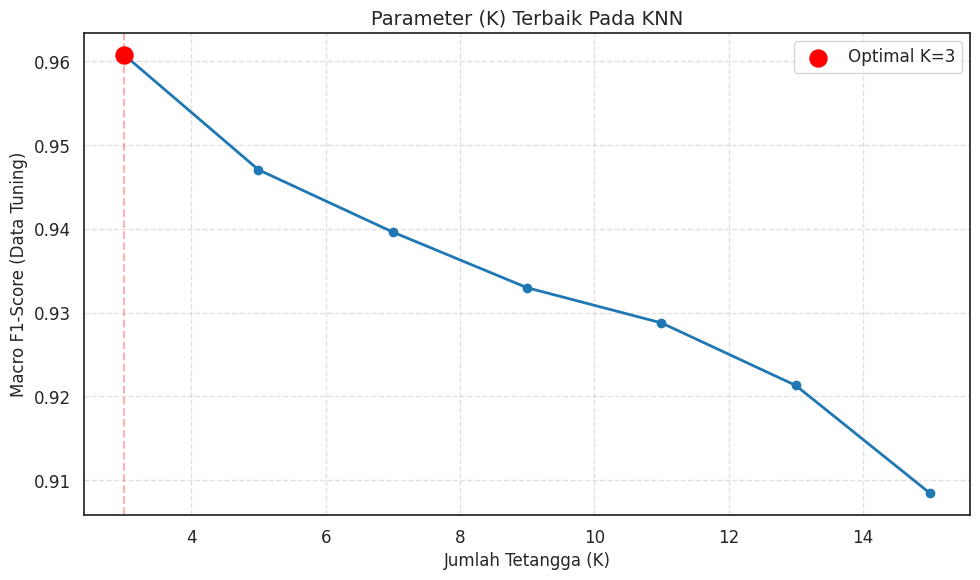

[INFO] Variabel 'final_k_knn' telah diset ke 3.
       Siap lanjut ke Tahap Evaluasi Akhir & Perbandingan Model.


In [19]:
import time
import matplotlib.pyplot as plt
import cupy as cp
from cuml.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
print("HYPERPARAMETER TUNING - KNN (METODE: UNIFORM VOTING)")
# 1. KONFIGURASI PENCARIAN HYPERPARAMETER TERBAIK
k_values = [3, 5, 7, 9, 11, 13, 15]
# Parameter Tetap
FIXED_METRIC = 'euclidean'
FIXED_WEIGHTS = 'uniform' 
print(f"-> Mencari Nilai K Terbaik Dari : {k_values}")
print(f"-> Metric Jarak   : {FIXED_METRIC}")
print(f"-> Pembobotan     : {FIXED_WEIGHTS} (Majority Voting)")
print(f"{'K':<5} | {'Macro F1-Score':<20} | {'Waktu (s)':<10}")
f1_scores = []
best_score = 0.0
best_k = k_values[0]
# 2. LOOPING EKSPERIMEN (GRID SEARCH)
for k in k_values:
    start_time = time.time()
    # A. Inisialisasi Model (Langsung pakai library, aman & cepat)
    knn = KNeighborsClassifier(n_neighbors=k, 
                               metric=FIXED_METRIC, 
                               weights=FIXED_WEIGHTS)
    # B. Training (Data Latih)
    knn.fit(X_train_gpu, y_train_gpu)
    # C. Validasi (Data Tuning)
    y_pred_gpu = knn.predict(X_tuning_gpu)
    # D. Hitung Score (Evaluasi di CPU)
    # Menggunakan Macro F1-Score karena data Imbalance
    y_true_cpu = cp.asnumpy(y_tuning_gpu)
    y_pred_cpu = cp.asnumpy(y_pred_gpu)
    score = f1_score(y_true_cpu, y_pred_cpu, average='macro')
    duration = time.time() - start_time
    f1_scores.append(score)
    print(f"{k:<5} | {score:.4f} ({score*100:.2f}%) | {duration:.4f}s")
    # Cek Rekor Terbaik
    if score > best_score:
        best_score = score
        best_k = k
print("-" * 80)
print(f"HASIL OPTIMAL: K = {best_k}")
print(f"   (Macro F1-Score: {best_score:.4f})")
print("="*80)

# 3. VISUALISASI HASIL
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='#1f77b4', linewidth=2)

# Tandai titik terbaik
plt.scatter(best_k, best_score, s=150, c='red', zorder=5, label=f'Optimal K={best_k}')
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.3)

plt.title(f'Parameter (K) Terbaik Pada KNN', fontsize=14)
plt.xlabel('Jumlah Tetangga (K)', fontsize=12)
plt.ylabel('Macro F1-Score (Data Tuning)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Simpan grafik
plt.savefig('Hasil_Tuning_KNN_Uniform.png', dpi=300)
plt.show()

# 4. SIMPAN PARAMETER FINAL
# Variabel ini akan otomatis dipakai di Step selanjutnya
final_k_knn = best_k
print(f"[INFO] Variabel 'final_k_knn' telah diset ke {final_k_knn}.")
print("       Siap lanjut ke Tahap Evaluasi Akhir & Perbandingan Model.")

## Data Latih

RETRAINING 80% DATA (TRAIN + TUNING) & SELF-EVALUATION
[INFO] Total data untuk retraining: 225389 sampel

[PROCESS] Melatih ulang model KNN dengan 80% data...
       -> Training Selesai dalam 0.0031 detik.
[PROCESS] Melakukan Prediksi pada Data Latih...

[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...
       -> First 10 Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
       -> Last 10 Classes : ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71']

--- Visualisasi 1: Confusion Matrix Data Latih ---


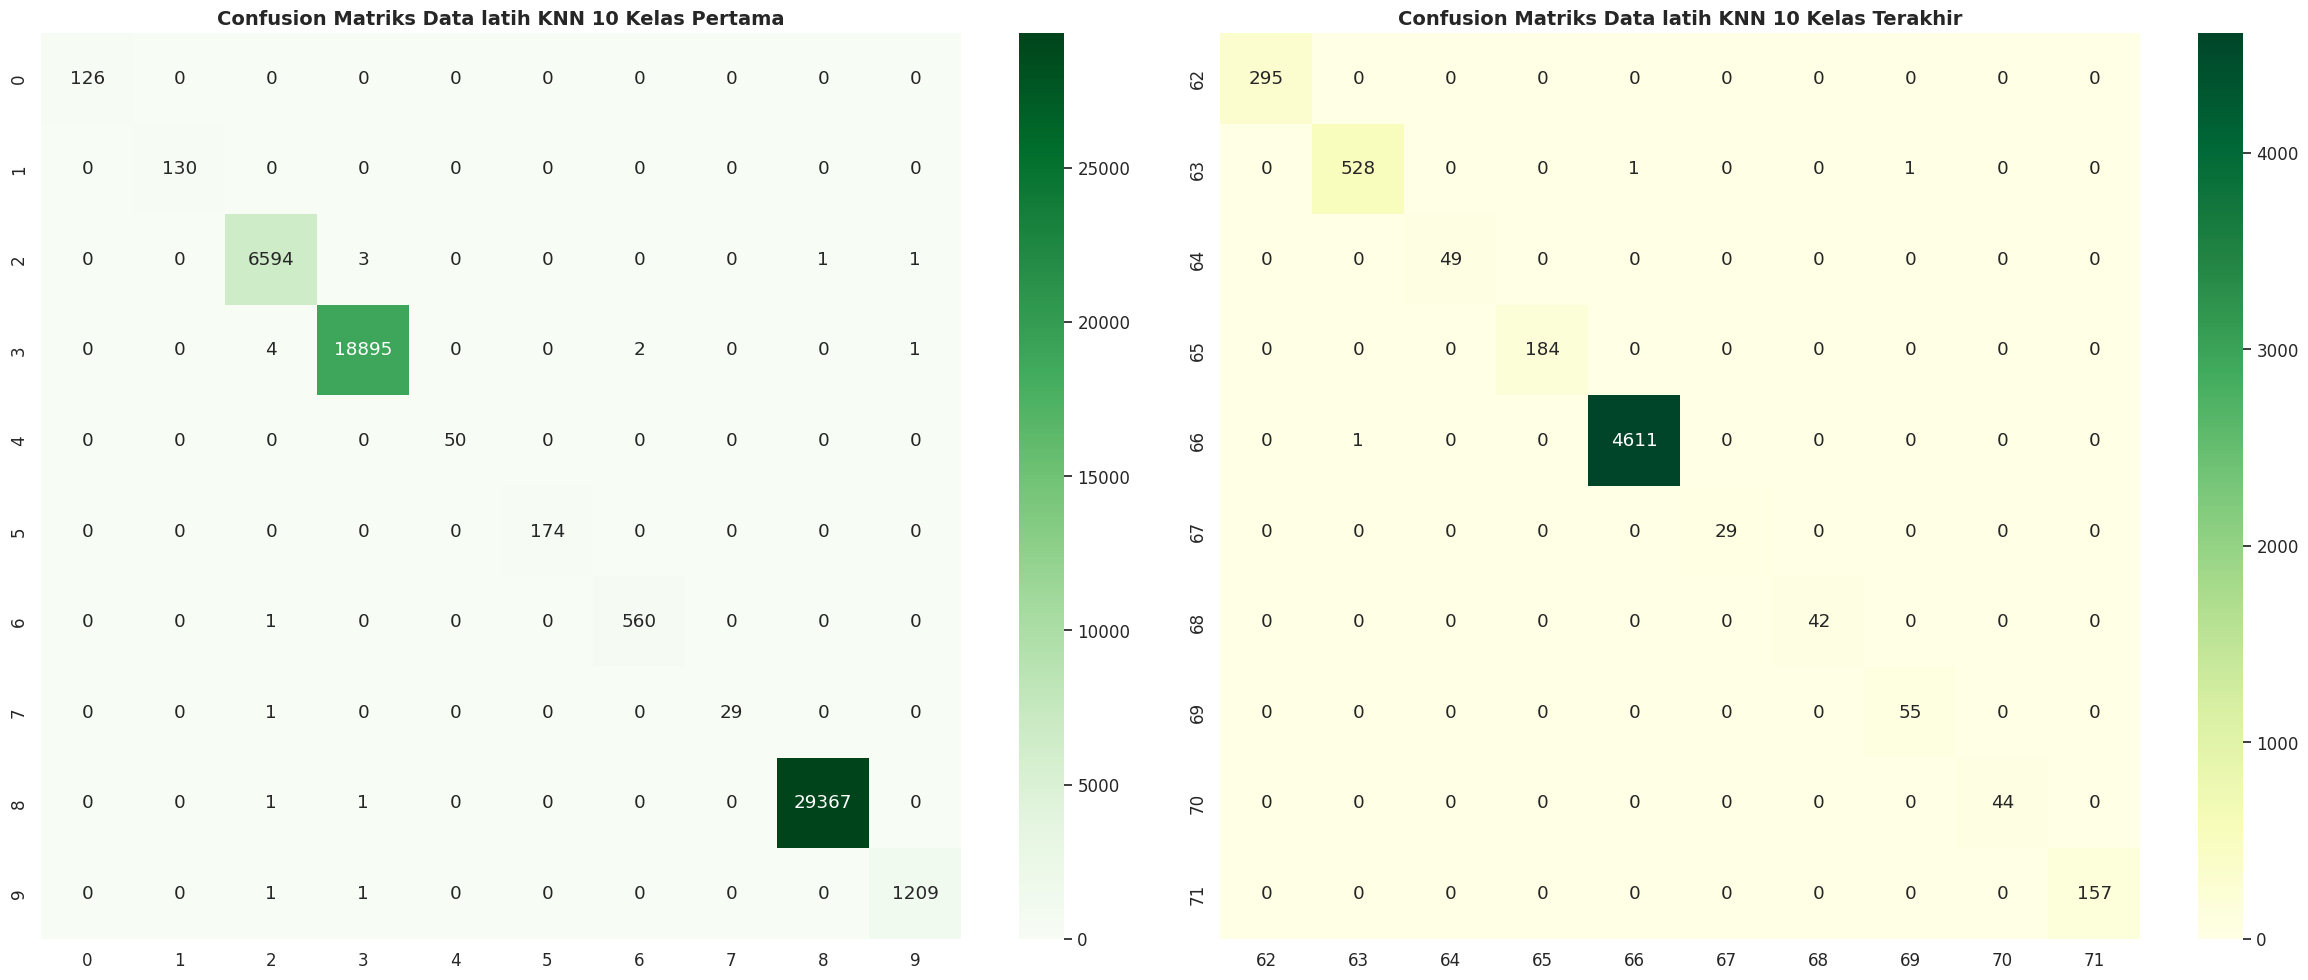


--- Visualisasi 2: ROC Curves Data Latih ---


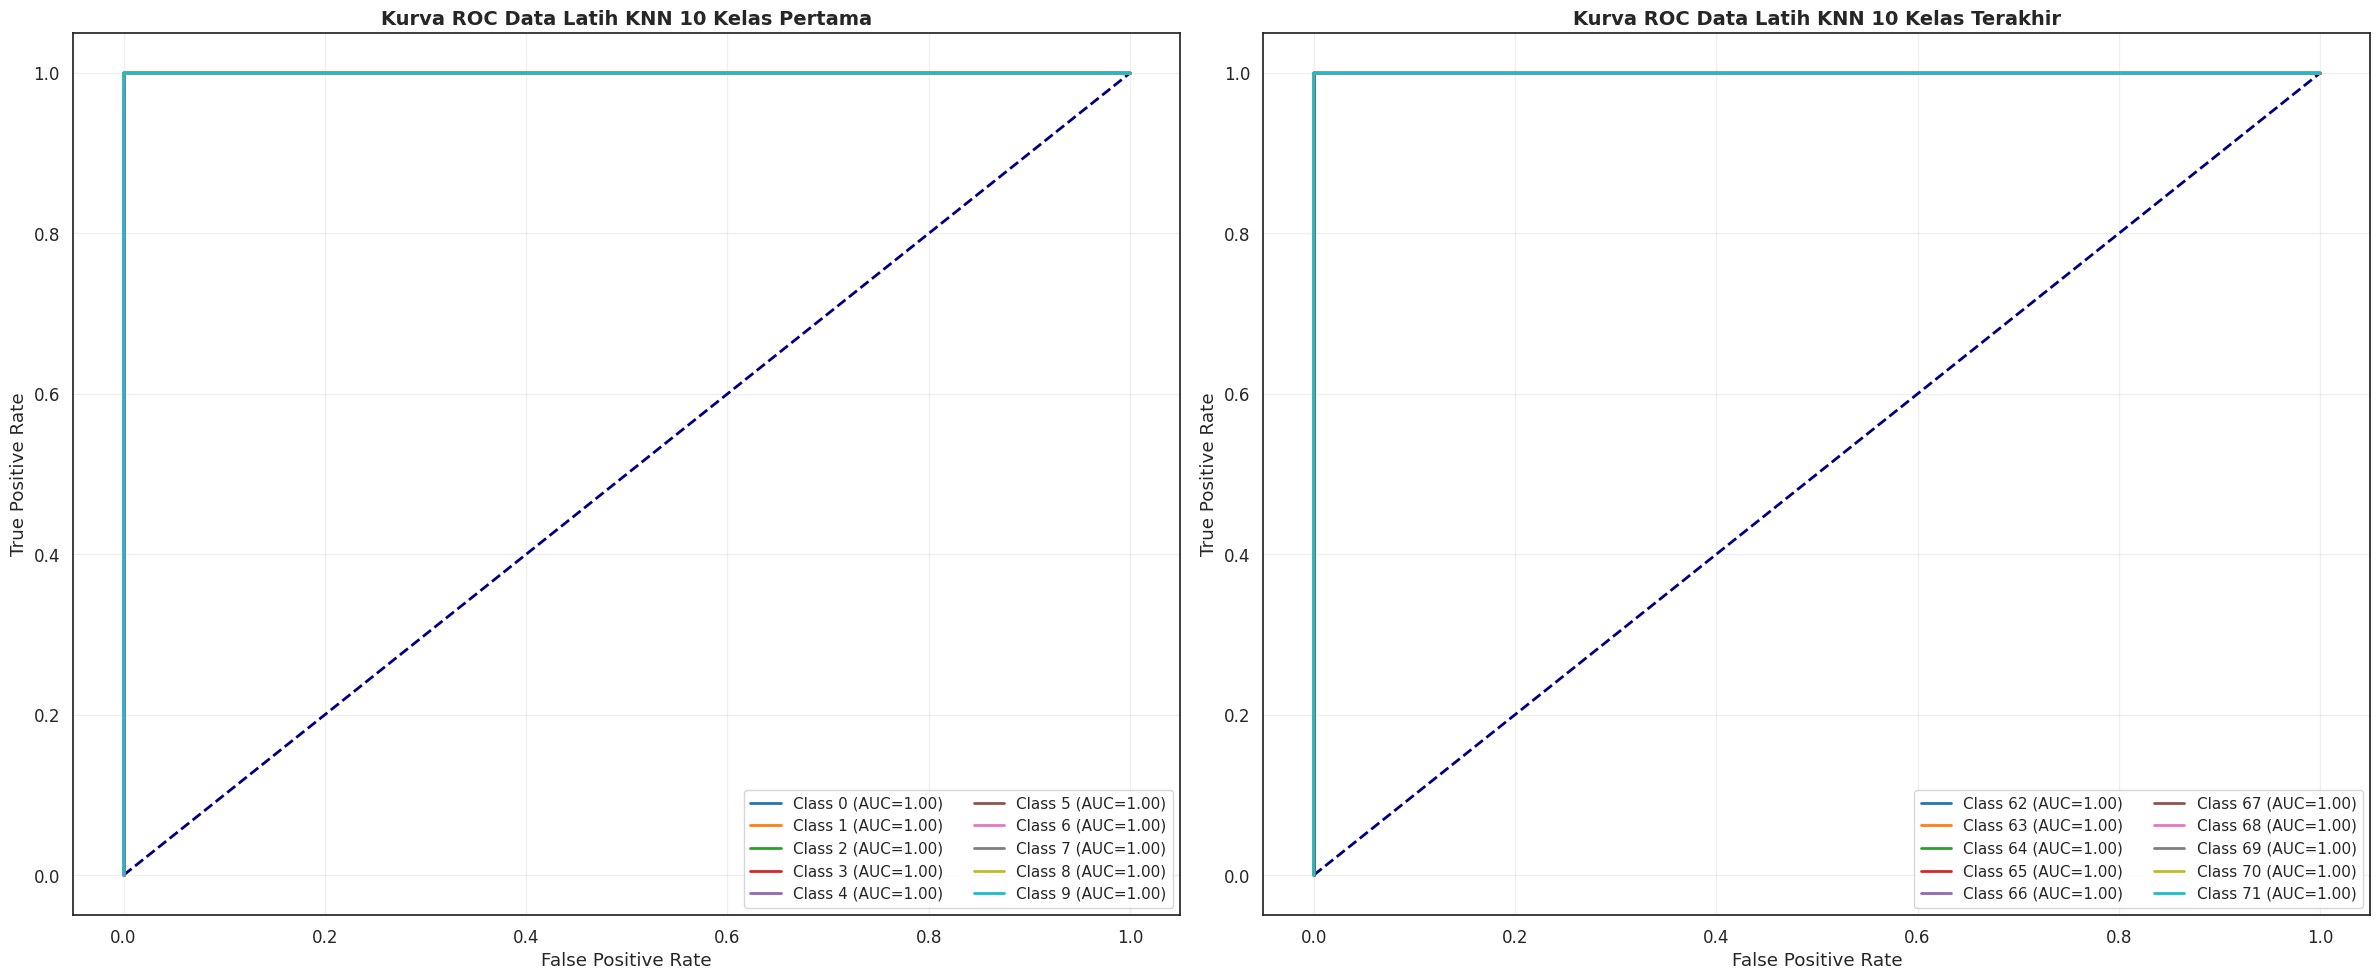


[PROCESS] Menghitung Final Metrics & Menyimpan Parameter...
RINGKASAN PERFORMA INTERNAL (80% DATA LATIH)
accuracy            : 99.66%
balanced_accuracy   : 97.31%
f1_macro            : 97.95%
auc_macro           : 100.00%
computation_time    : 0.0031 detik
Parameter 'results_knn_train' telah tersimpan.


In [20]:
import os
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cuml.neighbors import KNeighborsClassifier
from cupyx.scipy.sparse import vstack as sparse_vstack
from cupyx.scipy.sparse import issparse
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, balanced_accuracy_score, 
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# 1. PERSIAPAN FOLDER
os.makedirs('plots_knn_train', exist_ok=True)
print("RETRAINING 80% DATA (TRAIN + TUNING) & SELF-EVALUATION")

# 2. PENGGABUNGAN DATA menggunakan vstack 
if issparse(X_train_gpu):
    X_final_train = sparse_vstack([X_train_gpu, X_tuning_gpu])
else:
    X_final_train = cp.concatenate([X_train_gpu, X_tuning_gpu], axis=0)

y_final_train = cp.concatenate([y_train_gpu, y_tuning_gpu], axis=0)

print(f"[INFO] Total data untuk retraining: {X_final_train.shape[0]} sampel")

# 3. PROSES RETRAINING & PENCATATAN WAKTU
print("\n[PROCESS] Melatih ulang model KNN dengan 80% data...")
# Catat waktu mulai training
start_train_time = time.time()
knn_final = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric='euclidean', 
    weights='uniform'
)
knn_final.fit(X_final_train, y_final_train)
# Catat durasi training
train_duration = time.time() - start_train_time
print(f"       -> Training Selesai dalam {train_duration:.4f} detik.")

# 4. PREDIKSI DATA LATIH (SELF EVALUATION)
print("[PROCESS] Melakukan Prediksi pada Data Latih...")
y_pred_train_gpu = knn_final.predict(X_final_train)
y_proba_train_gpu = knn_final.predict_proba(X_final_train)

# Pindah ke CPU untuk Evaluasi
y_train_true_cpu = cp.asnumpy(y_final_train)
y_train_pred_cpu = cp.asnumpy(y_pred_train_gpu)
y_train_proba_cpu = cp.asnumpy(y_proba_train_gpu)

# 5. DATA PREPARATION (URUTAN NUMERIK)
print("\n[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...")
# Ambil semua nama kelas unik
unique_classes = np.unique(y_train_true_cpu)
class_names = [str(c) for c in unique_classes]
# URUTKAN SECARA ANGKA (NUMERIK) 0, 1, 2, ... N
all_classes_sorted = sorted(class_names, key=lambda x: int(x))
# AMBIL 10 PERTAMA & 10 TERAKHIR
first_10_list = all_classes_sorted[:10]   # Index 0 s/d 9
last_10_list = all_classes_sorted[-10:]   # 10 Index terakhir
print(f"       -> First 10 Classes: {first_10_list}")
print(f"       -> Last 10 Classes : {last_10_list}")

# VISUALISASI CONFUSION MATRIX
def plot_and_save_cm_train(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Kiri: First 10
    indices_a = [i for i, label in enumerate(y_train_true_cpu) if str(label) in list_a]
    if indices_a:
        cm_a = confusion_matrix(y_train_true_cpu[indices_a], y_train_pred_cpu[indices_a], labels=[int(c) for c in list_a])
        sns.heatmap(cm_a, annot=True, fmt='d', cmap='Greens', ax=axes[0], xticklabels=list_a, yticklabels=list_a)
    axes[0].set_title('Confusion Matriks Data latih KNN 10 Kelas Pertama', fontsize=14, fontweight='bold')

    # Kanan: Last 10
    indices_b = [i for i, label in enumerate(y_train_true_cpu) if str(label) in list_b]
    if indices_b:
        cm_b = confusion_matrix(y_train_true_cpu[indices_b], y_train_pred_cpu[indices_b], labels=[int(c) for c in list_b])
        sns.heatmap(cm_b, annot=True, fmt='d', cmap='YlGn', ax=axes[1], xticklabels=list_b, yticklabels=list_b)
    axes[1].set_title('Confusion Matriks Data latih KNN 10 Kelas Terakhir', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('plots_knn_train/confusion_matrix_train.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 1: Confusion Matrix Data Latih ---")
plot_and_save_cm_train(first_10_list, last_10_list)

# VISUALISASI ROC CURVES
# Definisi y_train_bin di scope global agar bisa dipakai fungsi ROC
y_train_bin = label_binarize(y_train_true_cpu, classes=unique_classes)
model_classes_cpu = cp.asnumpy(knn_final.classes_)

def plot_and_save_roc_train(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    def plot_on_axis(class_list, ax, title):
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        for cls_str in class_list:
            try:
                cls_idx = int(cls_str)
                # Cari index kolom probabilitas yang sesuai dengan kelas ini
                col_indices = np.where(model_classes_cpu == cls_idx)[0]
                if len(col_indices) == 0: continue
                col_idx = col_indices[0]
                
                # Plot hanya jika ada sampel positif
                if np.sum(y_train_bin[:, col_idx]) > 0:
                    fpr, tpr, _ = roc_curve(y_train_bin[:, col_idx], y_train_proba_cpu[:, col_idx])
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, lw=2, label=f'Class {cls_str} (AUC={roc_auc:.2f})')
            except Exception as e: 
                continue
                
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc="lower right", fontsize='small', ncol=2)
        ax.grid(alpha=0.3)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    plot_on_axis(list_a, axes[0], "Kurva ROC Data Latih KNN 10 Kelas Pertama")
    plot_on_axis(list_b, axes[1], "Kurva ROC Data Latih KNN 10 Kelas Terakhir")
    
    plt.tight_layout()
    plt.savefig('plots_knn_train/roc_curve_train.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 2: ROC Curves Data Latih ---")
plot_and_save_roc_train(first_10_list, last_10_list)

# SIMPAN HASIL KE PARAMETER GLOBAL
print("\n[PROCESS] Menghitung Final Metrics & Menyimpan Parameter...")
try:
    auc_macro_train = roc_auc_score(y_train_bin, y_train_proba_cpu, multi_class='ovr', average='macro')
except Exception as e:
    print(f"[WARNING] Gagal menghitung AUC: {e}")
    auc_macro_train = 0.0

# Simpan semua parameter ke dalam dictionary
results_knn_train = {
    'accuracy': accuracy_score(y_train_true_cpu, y_train_pred_cpu),
    'balanced_accuracy': balanced_accuracy_score(y_train_true_cpu, y_train_pred_cpu),
    'f1_macro': f1_score(y_train_true_cpu, y_train_pred_cpu, average='macro'),
    'auc_macro': auc_macro_train,
    'computation_time': train_duration # Waktu komputasi (Training Time)
}

print("RINGKASAN PERFORMA INTERNAL (80% DATA LATIH)")
for metric, value in results_knn_train.items():
    if metric == 'computation_time':
        print(f"{metric:<20}: {value:.4f} detik")
    else:
        print(f"{metric:<20}: {value*100:.2f}%")
print("Parameter 'results_knn_train' telah tersimpan.")

## Data Uji KNN

EVALUASI DATA UJI

Melakukan Prediksi pada Data Uji (X_test)...
       -> Prediksi Selesai dalam 166.4556 detik.

 Menyiapkan Daftar Kelas untuk Visualisasi...
       -> First 10 Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
       -> Last 10 Classes : ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71']

--- Visualisasi 1: Confusion Matrix Data Uji (Tersimpan) ---


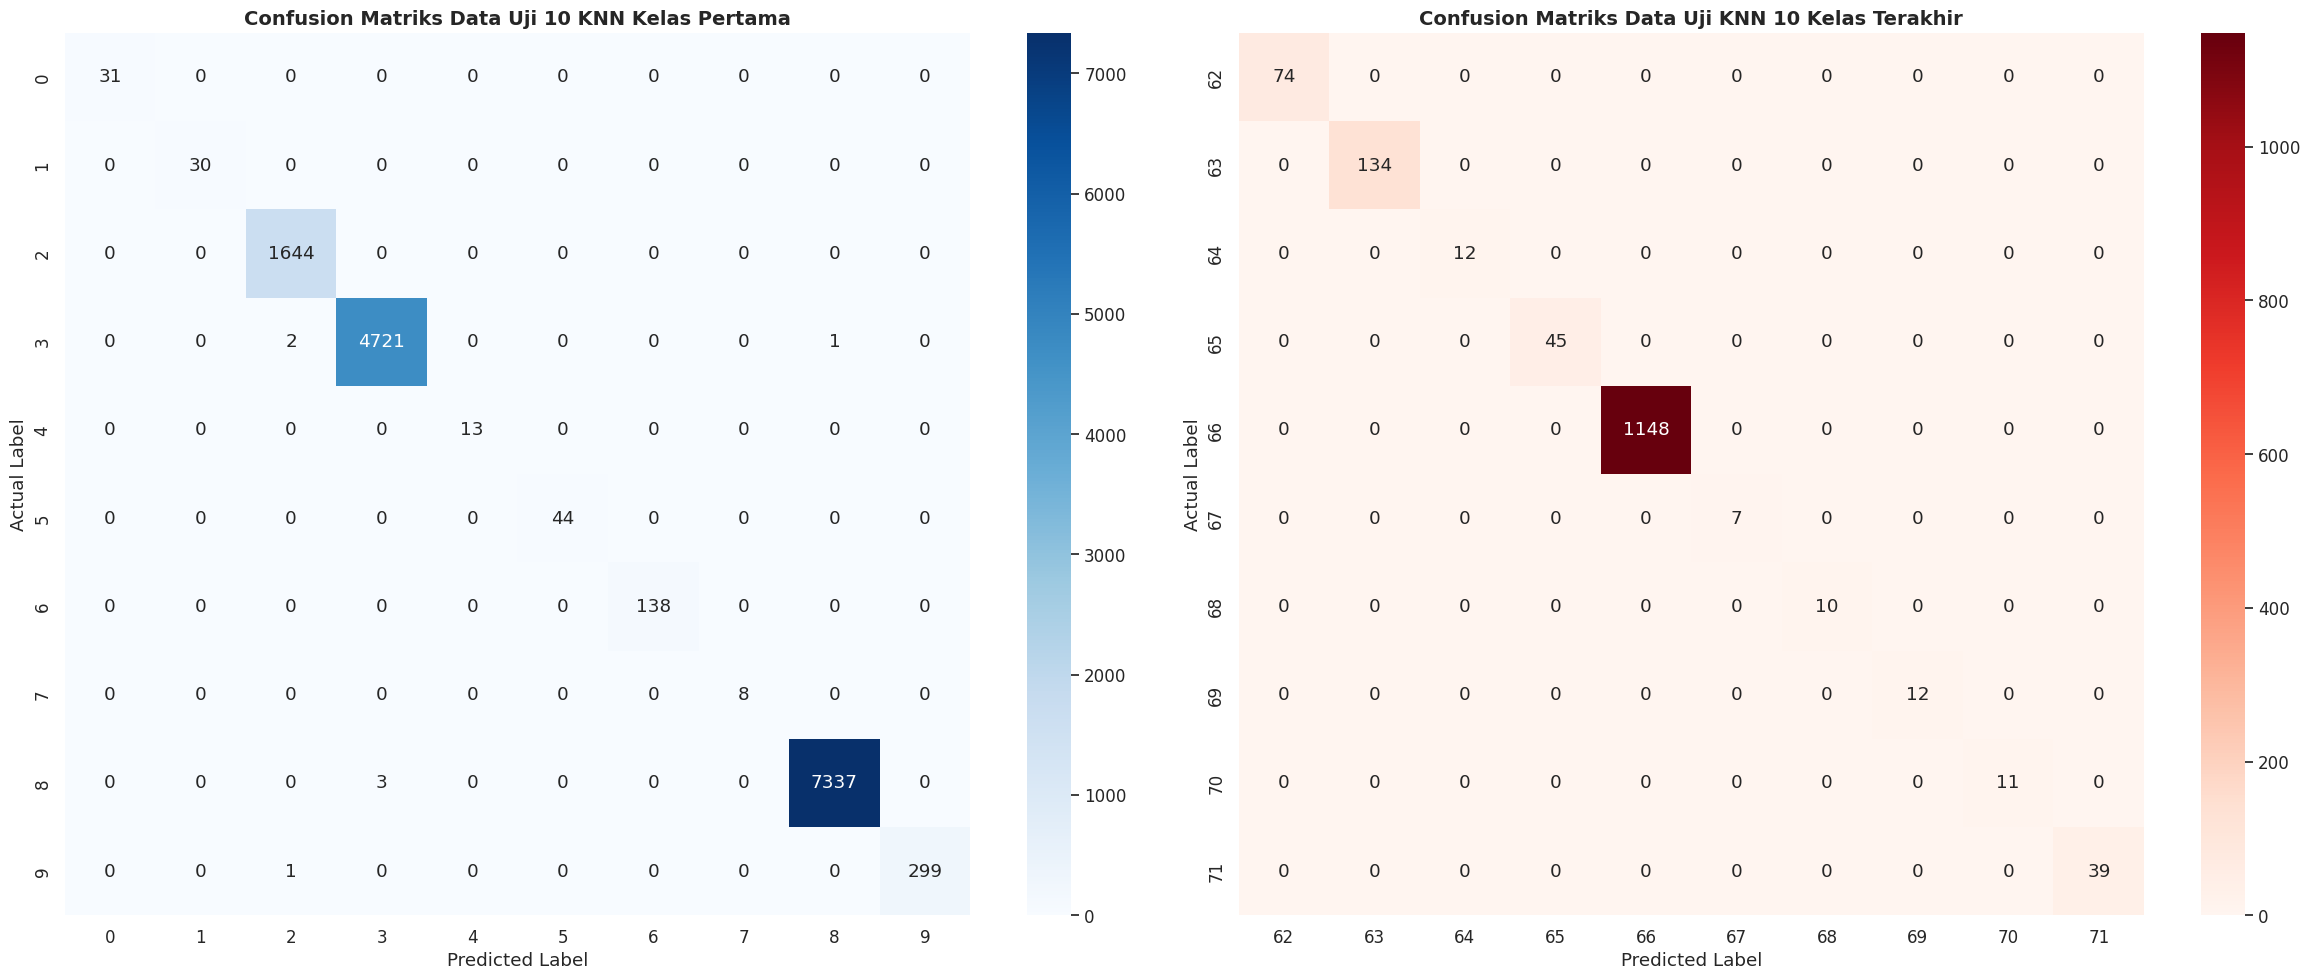


--- Visualisasi 2: ROC Curves Data Uji (Tersimpan) ---


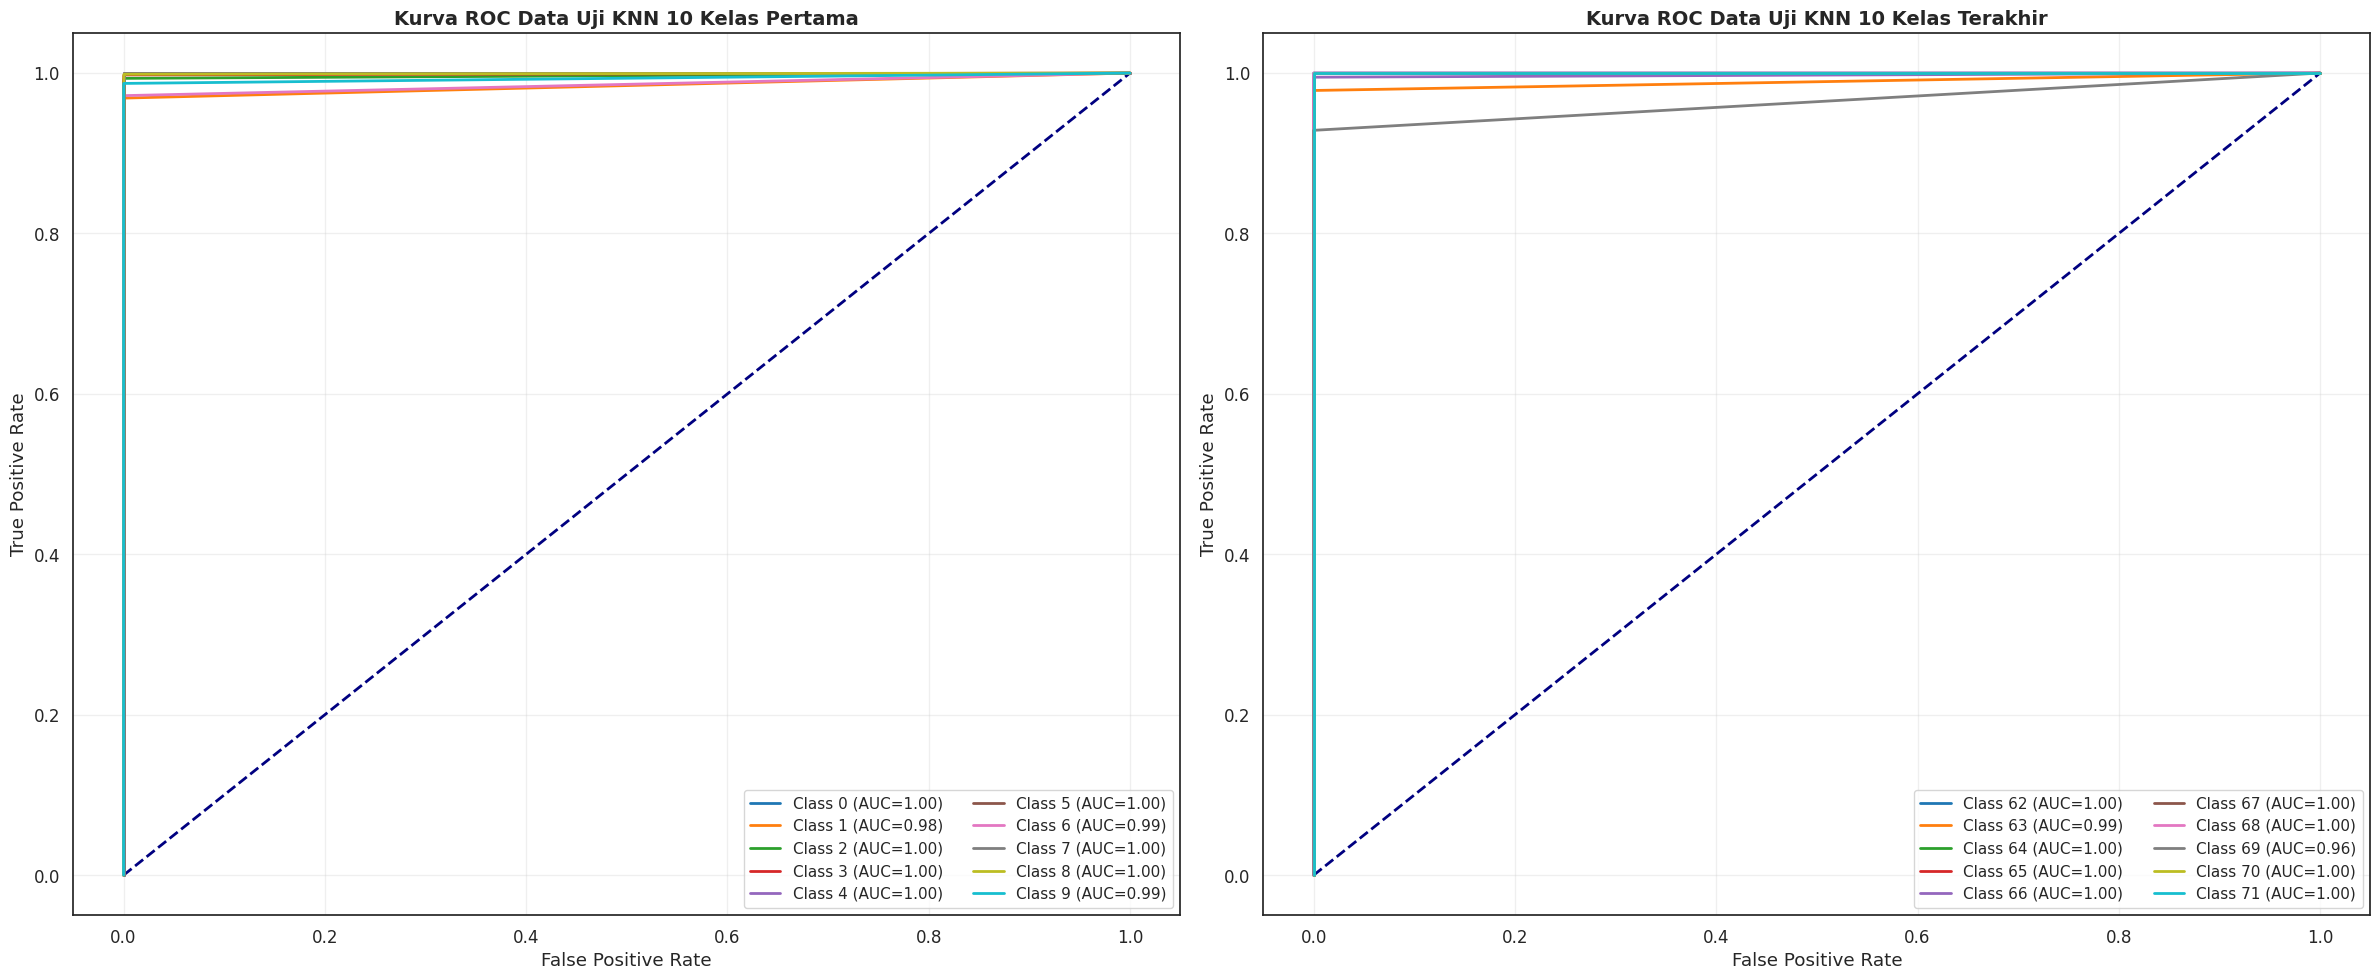


[PROCESS] Menghitung Final Metrics untuk Data Uji...
RINGKASAN PERFORMA FINAL PADA DATA UJI (20%)
accuracy            : 99.47%
balanced_accuracy   : 95.18%
f1_macro            : 96.46%
auc_macro           : 98.98%
computation_time    : 166.4556 detik
[INFO] Parameter 'results_knn_test' telah tersimpan.
       Langkah KNN Selesai! Siap lanjut ke Naive Bayes.


In [21]:
import os
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, balanced_accuracy_score, 
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# 1. PERSIAPAN FOLDER
os.makedirs('plots_knn_test', exist_ok=True)

print("EVALUASI DATA UJI")

# 2. PROSES PREDIKSI DATA UJI & PENCATATAN WAKTU
print("\nMelakukan Prediksi pada Data Uji (X_test)...")

# Catat waktu mulai testing
start_test_time = time.time()

# Prediksi Kelas & Probabilitas
y_pred_test_gpu = knn_final.predict(X_test_gpu)
y_proba_test_gpu = knn_final.predict_proba(X_test_gpu)

# Catat durasi testing
test_duration = time.time() - start_test_time
print(f"       -> Prediksi Selesai dalam {test_duration:.4f} detik.")

# Pindah ke CPU untuk Evaluasi & Visualisasi
y_test_true_cpu = cp.asnumpy(y_test_gpu)
y_test_pred_cpu = cp.asnumpy(y_pred_test_gpu)
y_test_proba_cpu = cp.asnumpy(y_proba_test_gpu)

# 3. DATA PREPARATION (URUTAN NUMERIK)
print("\n Menyiapkan Daftar Kelas untuk Visualisasi...")

# Ambil semua nama kelas unik yang ada di Data Uji
unique_classes_test = np.unique(y_test_true_cpu)
class_names_test = [str(c) for c in unique_classes_test]
# URUTKAN SECARA ANGKA (NUMERIK) 0, 1, 2, ... N
all_classes_sorted_test = sorted(class_names_test, key=lambda x: int(x))
# AMBIL 10 PERTAMA & 10 TERAKHIR
first_10_test = all_classes_sorted_test[:10]   # Index 0 s/d 9
last_10_test = all_classes_sorted_test[-10:]   # 10 Index terakhir
print(f"       -> First 10 Classes: {first_10_test}")
print(f"       -> Last 10 Classes : {last_10_test}")

# VISUALISASI CONFUSION MATRIX (TEST DATA)
def plot_and_save_cm_test(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Kiri: First 10
    indices_a = [i for i, label in enumerate(y_test_true_cpu) if str(label) in list_a]
    if indices_a:
        cm_a = confusion_matrix(y_test_true_cpu[indices_a], y_test_pred_cpu[indices_a], labels=[int(c) for c in list_a])
        sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=list_a, yticklabels=list_a)
    axes[0].set_title('Confusion Matriks Data Uji 10 KNN Kelas Pertama', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('Actual Label')

    # Kanan: Last 10
    indices_b = [i for i, label in enumerate(y_test_true_cpu) if str(label) in list_b]
    if indices_b:
        cm_b = confusion_matrix(y_test_true_cpu[indices_b], y_test_pred_cpu[indices_b], labels=[int(c) for c in list_b])
        sns.heatmap(cm_b, annot=True, fmt='d', cmap='Reds', ax=axes[1], xticklabels=list_b, yticklabels=list_b)
    axes[1].set_title('Confusion Matriks Data Uji KNN 10 Kelas Terakhir', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('Actual Label')

    plt.tight_layout()
    plt.savefig('plots_knn_test/confusion_matrix_test.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 1: Confusion Matrix Data Uji (Tersimpan) ---")
plot_and_save_cm_test(first_10_test, last_10_test)

# VISUALISASI Kurva ROC Data Uji
# Definisi Binarize Label Test untuk ROC
# PENTING: Gunakan knn_final.classes_ sebagai referensi agar index kolom probabilitas cocok
model_classes_cpu = cp.asnumpy(knn_final.classes_)
y_test_bin = label_binarize(y_test_true_cpu, classes=model_classes_cpu)

def plot_and_save_roc_test(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    def plot_on_axis(class_list, ax, title):
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        for cls_str in class_list:
            try:
                cls_idx = int(cls_str)
                # Cari index kolom probabilitas yg sesuai dengan kelas ini di model
                col_indices = np.where(model_classes_cpu == cls_idx)[0]
                if len(col_indices) == 0: continue
                col_idx = col_indices[0]
                
                # Cek apakah kelas ini ada di data uji saat ini
                if np.sum(y_test_bin[:, col_idx]) > 0:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, col_idx], y_test_proba_cpu[:, col_idx])
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, lw=2, label=f'Class {cls_str} (AUC={roc_auc:.2f})')
            except Exception as e:
                continue
                
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc="lower right", fontsize='small', ncol=2)
        ax.grid(alpha=0.3)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    plot_on_axis(list_a, axes[0], "Kurva ROC Data Uji KNN 10 Kelas Pertama")
    plot_on_axis(list_b, axes[1], "Kurva ROC Data Uji KNN 10 Kelas Terakhir")
    
    plt.tight_layout()
    plt.savefig('plots_knn_test/roc_curve_test.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 2: ROC Curves Data Uji (Tersimpan) ---")
plot_and_save_roc_test(first_10_test, last_10_test)

# SIMPAN HASIL UJI KE PARAMETER GLOBAL
print("\n[PROCESS] Menghitung Final Metrics untuk Data Uji...")
try:
    # Menggunakan y_test_bin yang sudah didefinisikan di atas
    auc_macro_test = roc_auc_score(y_test_bin, y_test_proba_cpu, multi_class='ovr', average='macro')
except Exception as e:
    print(f"[WARNING] Gagal menghitung AUC Test: {e}")
    auc_macro_test = 0.0

# Simpan semua parameter ke dalam dictionary KHUSUS TEST
results_knn_test = {
    'accuracy': accuracy_score(y_test_true_cpu, y_test_pred_cpu),
    'balanced_accuracy': balanced_accuracy_score(y_test_true_cpu, y_test_pred_cpu),
    'f1_macro': f1_score(y_test_true_cpu, y_test_pred_cpu, average='macro'),
    'auc_macro': auc_macro_test,
    'computation_time': test_duration  # Waktu komputasi (Testing Time)
}

print("RINGKASAN PERFORMA FINAL PADA DATA UJI (20%)")
for metric, value in results_knn_test.items():
    if metric == 'computation_time':
        print(f"{metric:<20}: {value:.4f} detik")
    else:
        print(f"{metric:<20}: {value*100:.2f}%")
print("[INFO] Parameter 'results_knn_test' telah tersimpan.")
print("       Langkah KNN Selesai! Siap lanjut ke Naive Bayes.")

# Naive Bayes

## Data Validasi

HYPERPARAMETER TUNING - NAIVE BAYES (PARAMETER: ALPHA)
-> Mencari Nilai Alpha Terbaik Dari : [1e-06, 0.0001, 0.01, 0.1, 0.5, 1.0, 2.0]
-> Tipe Model         : Multinomial Naive Bayes
Alpha      | Macro F1-Score       | Waktu (s) 
1e-06      | 0.8408 (84.08%) | 4.2313s
0.0001     | 0.8426 (84.26%) | 0.1676s
0.01       | 0.8416 (84.16%) | 0.1436s
0.1        | 0.8411 (84.11%) | 0.1430s
0.5        | 0.8394 (83.94%) | 0.1403s
1.0        | 0.8368 (83.68%) | 0.1400s
2.0        | 0.8265 (82.65%) | 0.1393s
HASIL OPTIMAL: Alpha = 0.0001
   (Macro F1-Score: 0.8426)


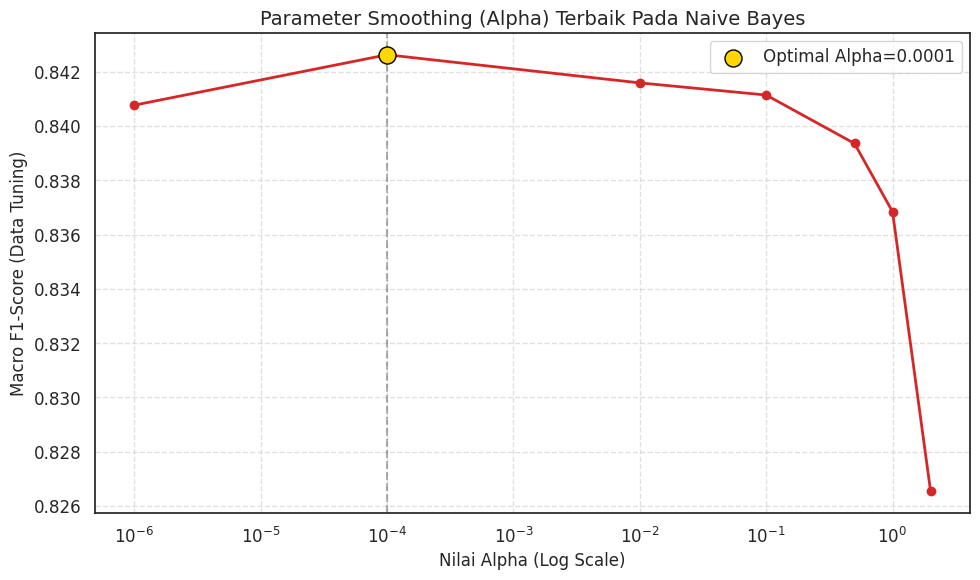

[INFO] Variabel 'final_alpha_nb' telah diset ke 0.0001.


In [22]:
import time
import matplotlib.pyplot as plt
import cupy as cp
from cuml.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

print("HYPERPARAMETER TUNING - NAIVE BAYES (PARAMETER: ALPHA)")
# 1. KONFIGURASI PENCARIAN HYPERPARAMETER TERBAIK
# Alpha (Smoothing): Semakin kecil (mendekati 0) semakin sensitif, semakin besar semakin umum.
alpha_values = [0.000001, 0.0001, 0.01, 0.1, 0.5, 1.0, 2.0]

print(f"-> Mencari Nilai Alpha Terbaik Dari : {alpha_values}")
print(f"-> Tipe Model         : Multinomial Naive Bayes")
print(f"{'Alpha':<10} | {'Macro F1-Score':<20} | {'Waktu (s)':<10}")

f1_scores_nb = []
best_score_nb = 0.0
best_alpha = alpha_values[0]

# 2. LOOPING EKSPERIMEN (GRID SEARCH)
for alpha in alpha_values:
    start_time = time.time()
    
    # A. Inisialisasi Model
    # cuml.naive_bayes.MultinomialNB di GPU
    nb_model = MultinomialNB(alpha=alpha)  
    
    # B. Training (Data Latih - GPU)
    nb_model.fit(X_train_gpu, y_train_gpu)
    
    # C. Validasi (Data Tuning - GPU)
    y_pred_gpu = nb_model.predict(X_tuning_gpu)
    
    # D. Hitung Score (Evaluasi di CPU)
    y_true_cpu = cp.asnumpy(y_tuning_gpu)
    y_pred_cpu = cp.asnumpy(y_pred_gpu)
    
    score = f1_score(y_true_cpu, y_pred_cpu, average='macro')
    duration = time.time() - start_time
    
    f1_scores_nb.append(score)
    
    print(f"{alpha:<10} | {score:.4f} ({score*100:.2f}%) | {duration:.4f}s")
    
    # Cek Rekor Terbaik
    if score > best_score_nb:
        best_score_nb = score
        best_alpha = alpha

print(f"HASIL OPTIMAL: Alpha = {best_alpha}")
print(f"   (Macro F1-Score: {best_score_nb:.4f})")

# 3. VISUALISASI HASIL
plt.figure(figsize=(10, 6))
# Kita gunakan skala logaritmik untuk sumbu X karena rentang alpha cukup lebar (0.001 s/d 10)
plt.semilogx(alpha_values, f1_scores_nb, marker='o', linestyle='-', color='#d62728', linewidth=2) 

# Tandai titik terbaik
plt.scatter(best_alpha, best_score_nb, s=150, c='gold', edgecolors='black', zorder=5, label=f'Optimal Alpha={best_alpha}')
plt.axvline(x=best_alpha, color='black', linestyle='--', alpha=0.3)

plt.title(f'Parameter Smoothing (Alpha) Terbaik Pada Naive Bayes', fontsize=14)
plt.xlabel('Nilai Alpha (Log Scale)', fontsize=12)
plt.ylabel('Macro F1-Score (Data Tuning)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Simpan grafik
plt.savefig('Hasil_Tuning_NaiveBayes.png', dpi=300)
plt.show()

# 4. SIMPAN PARAMETER FINAL
# Variabel ini akan otomatis dipakai di tahap Retraining & Final Evaluation Naive Bayes
final_alpha_nb = best_alpha
print(f"[INFO] Variabel 'final_alpha_nb' telah diset ke {final_alpha_nb}.")

## Data Latih Naive Bayes 80% Data

RETRAINING 80% DATA NAIVE BAYES (TRAIN + TUNING) & SELF-EVALUATION
[INFO] Total data untuk retraining: 225389 sampel

[PROCESS] Melatih ulang model Naive Bayes dengan 80% data...
       -> Training NB Selesai dalam 0.0173 detik.
[PROCESS] Melakukan Prediksi Internal (Self-Check)...

[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...
       -> First 10 Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
       -> Last 10 Classes : ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71']

--- Visualisasi 1: Confusion Matrix NB Data Latih ---


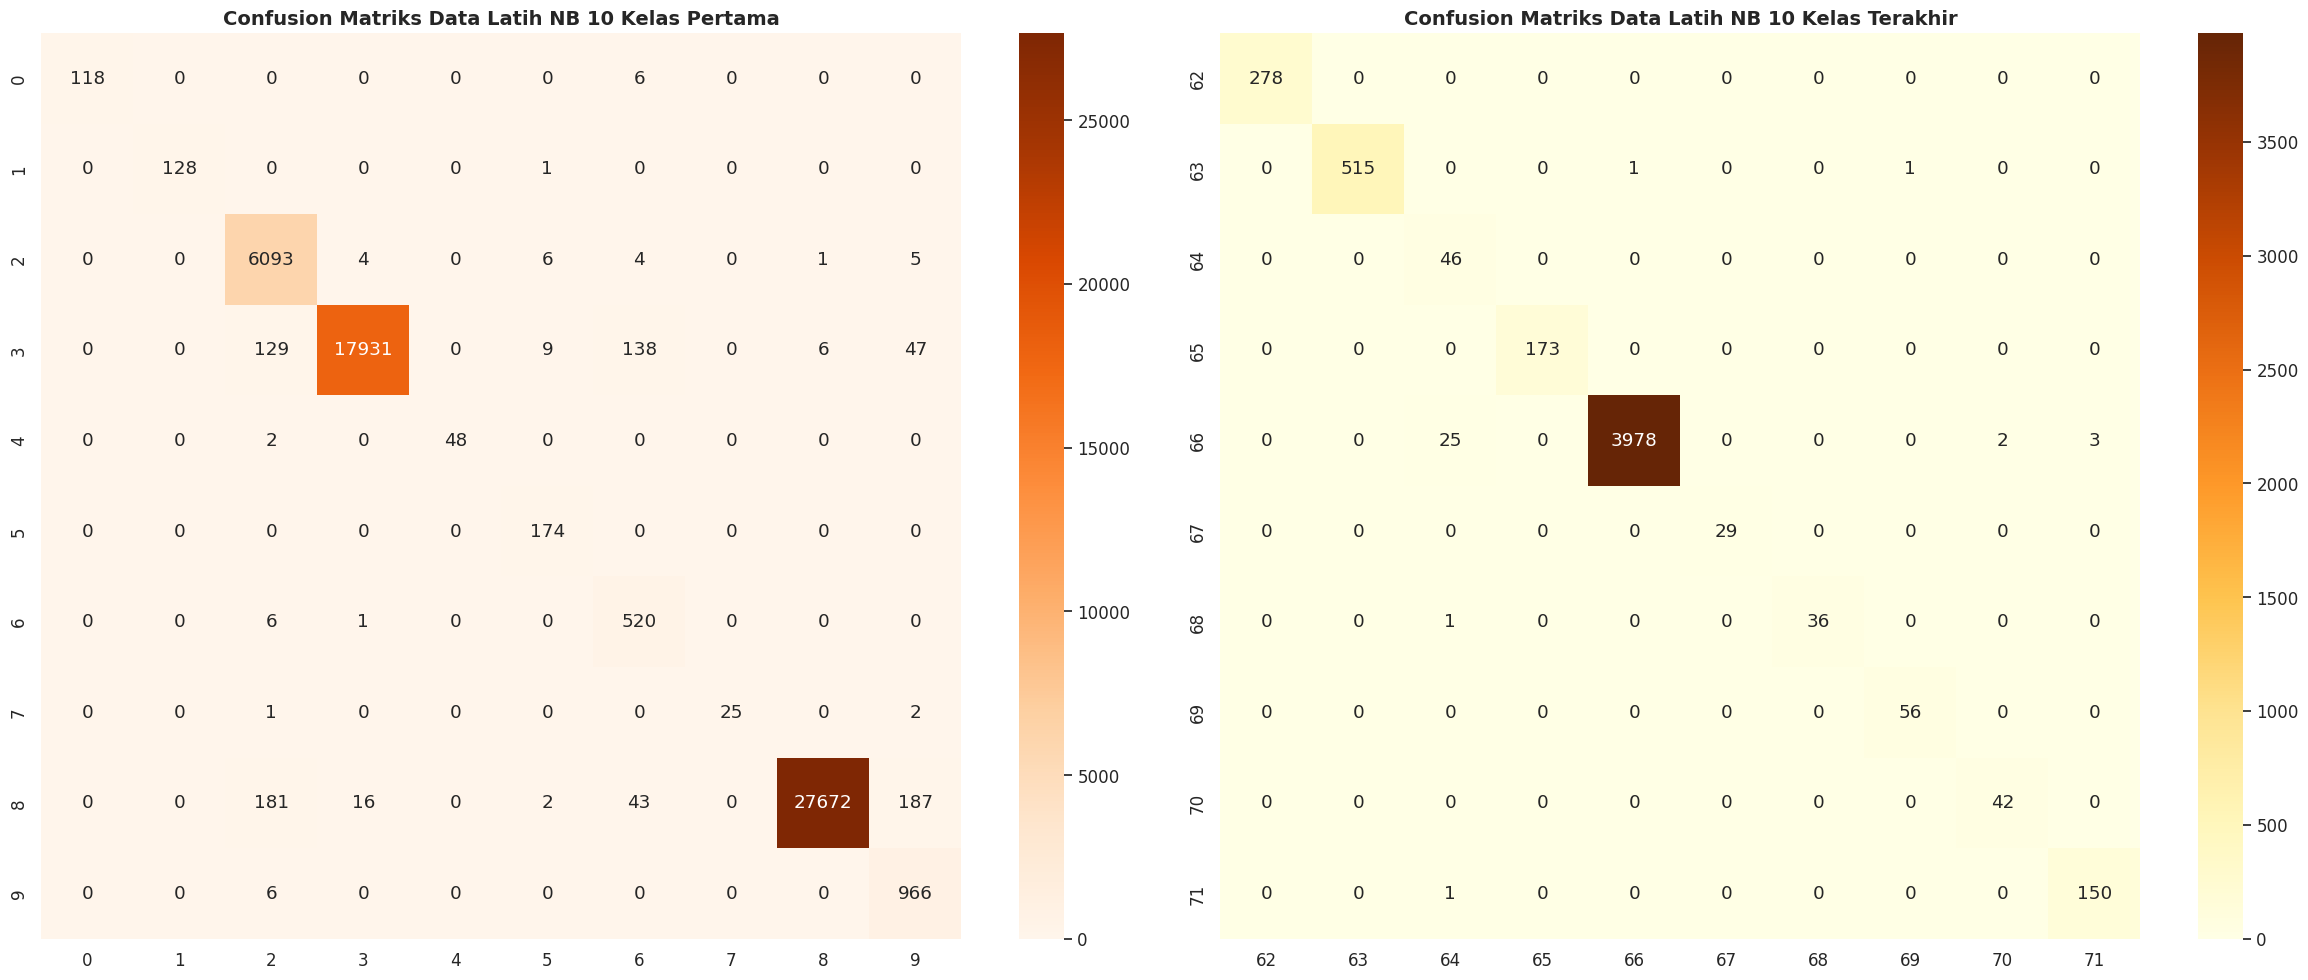


--- Visualisasi 2: ROC Curves NB Data Latih ---


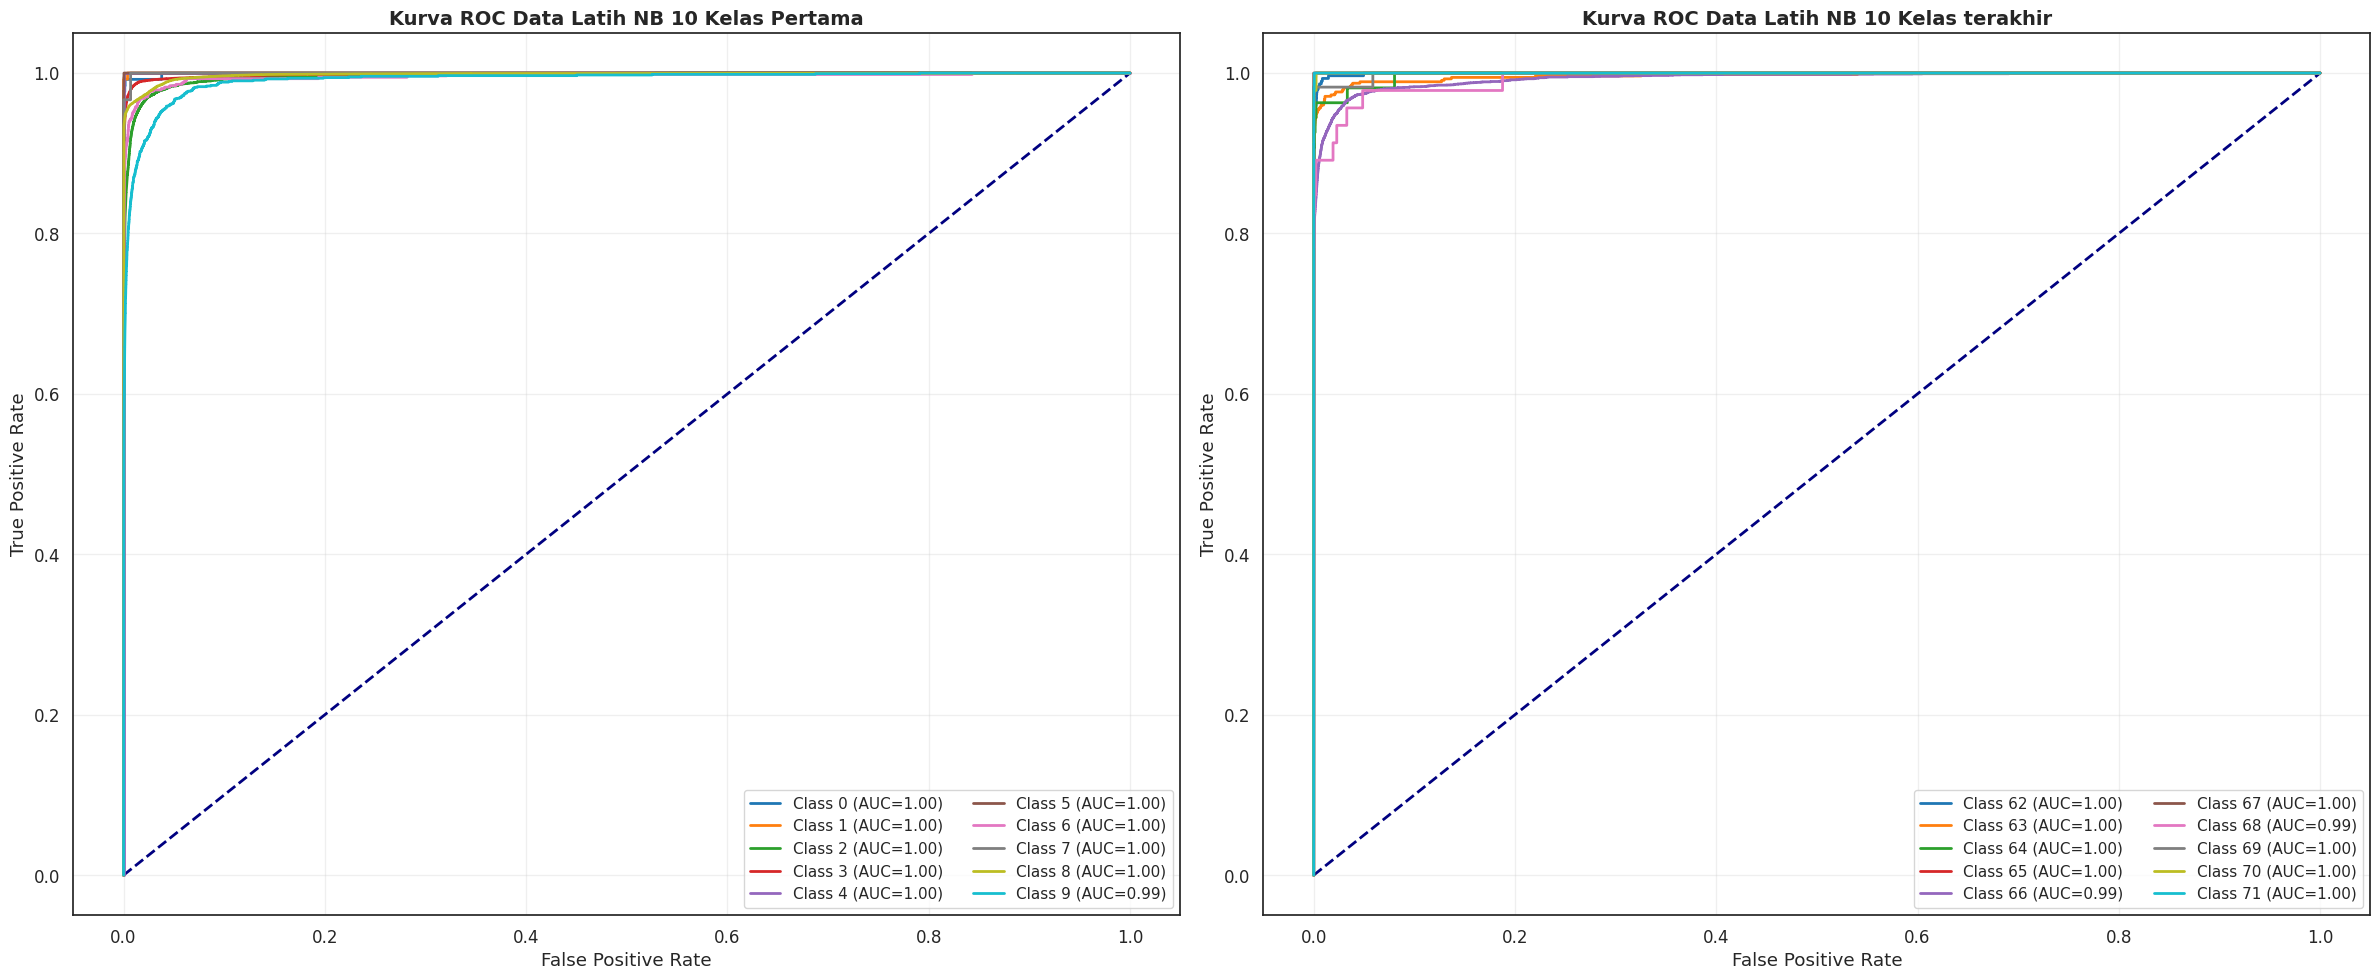


[PROCESS] Menyimpan Hasil Evaluasi Internal Naive Bayes...
RINGKASAN PERFORMA INTERNAL NAIVE BAYES (80% DATA)
accuracy            : 93.55%
balanced_accuracy   : 91.61%
f1_macro            : 84.77%
auc_macro           : 99.78%
computation_time    : 0.0173 detik


In [23]:
import os
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cuml.naive_bayes import MultinomialNB  # Menggunakan Naive Bayes
from cupyx.scipy.sparse import vstack as sparse_vstack
from cupyx.scipy.sparse import issparse
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, balanced_accuracy_score, 
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# 1. PERSIAPAN FOLDER KHUSUS NAIVE BAYES
os.makedirs('plots_nb_train', exist_ok=True)
print("RETRAINING 80% DATA NAIVE BAYES (TRAIN + TUNING) & SELF-EVALUATION")

# 2. PENGGABUNGAN DATA Menggunakan Vstack concat
if issparse(X_train_gpu):
    X_final_train = sparse_vstack([X_train_gpu, X_tuning_gpu])
else:
    X_final_train = cp.concatenate([X_train_gpu, X_tuning_gpu], axis=0)
    
y_final_train = cp.concatenate([y_train_gpu, y_tuning_gpu], axis=0)

print(f"[INFO] Total data untuk retraining: {X_final_train.shape[0]} sampel")

# 3. PROSES RETRAINING NAIVE BAYES
print("\n[PROCESS] Melatih ulang model Naive Bayes dengan 80% data...")
# Catat waktu mulai training
start_train_time = time.time()

nb_final = MultinomialNB(alpha=final_alpha_nb)
nb_final.fit(X_final_train, y_final_train)

# Catat durasi training
train_duration = time.time() - start_train_time
print(f"       -> Training NB Selesai dalam {train_duration:.4f} detik.")

# 4. PREDIKSI DATA LATIH (SELF Evaluation)
print("[PROCESS] Melakukan Prediksi Internal (Self-Check)...")
y_pred_train_gpu = nb_final.predict(X_final_train)
y_proba_train_gpu = nb_final.predict_proba(X_final_train)

# Pindah ke CPU untuk Evaluasi
y_train_true_cpu = cp.asnumpy(y_final_train)
y_train_pred_cpu = cp.asnumpy(y_pred_train_gpu)
y_train_proba_cpu = cp.asnumpy(y_proba_train_gpu)

# 5. DATA PREPARATION
print("\n[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...")
unique_classes = np.unique(y_train_true_cpu)
class_names = [str(c) for c in unique_classes]
all_classes_sorted = sorted(class_names, key=lambda x: int(x))

first_10_list = all_classes_sorted[:10]
last_10_list = all_classes_sorted[-10:]

print(f"       -> First 10 Classes: {first_10_list}")
print(f"       -> Last 10 Classes : {last_10_list}")

# VISUALISASI CONFUSION MATRIX (NAIVE BAYES Data Latih)
def plot_and_save_cm_nb_train(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Kiri: First 10
    indices_a = [i for i, label in enumerate(y_train_true_cpu) if str(label) in list_a]
    if indices_a:
        cm_a = confusion_matrix(y_train_true_cpu[indices_a], y_train_pred_cpu[indices_a], labels=[int(c) for c in list_a])
        sns.heatmap(cm_a, annot=True, fmt='d', cmap='Oranges', ax=axes[0], xticklabels=list_a, yticklabels=list_a)
    axes[0].set_title('Confusion Matriks Data Latih NB 10 Kelas Pertama', fontsize=14, fontweight='bold')

    # Kanan: Last 10
    indices_b = [i for i, label in enumerate(y_train_true_cpu) if str(label) in list_b]
    if indices_b:
        cm_b = confusion_matrix(y_train_true_cpu[indices_b], y_train_pred_cpu[indices_b], labels=[int(c) for c in list_b])
        sns.heatmap(cm_b, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1], xticklabels=list_b, yticklabels=list_b)
    axes[1].set_title('Confusion Matriks Data Latih NB 10 Kelas Terakhir', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots_nb_train/nb_confusion_matrix_train.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 1: Confusion Matrix NB Data Latih ---")
plot_and_save_cm_nb_train(first_10_list, last_10_list)

# BAGIAN B: VISUALISASI Kurva ROC (NAIVE BAYES Data Latih)
y_train_bin = label_binarize(y_train_true_cpu, classes=unique_classes)
model_classes_cpu = cp.asnumpy(nb_final.classes_)

def plot_and_save_roc_nb_train(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    def plot_on_axis(class_list, ax, title):
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        for cls_str in class_list:
            try:
                cls_idx = int(cls_str)
                col_indices = np.where(model_classes_cpu == cls_idx)[0]
                if len(col_indices) == 0: continue
                col_idx = col_indices[0]
                
                if np.sum(y_train_bin[:, col_idx]) > 0:
                    fpr, tpr, _ = roc_curve(y_train_bin[:, col_idx], y_train_proba_cpu[:, col_idx])
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, lw=2, label=f'Class {cls_str} (AUC={roc_auc:.2f})')
            except Exception as e: continue
                
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc="lower right", fontsize='small', ncol=2)
        ax.grid(alpha=0.3)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    plot_on_axis(list_a, axes[0], "Kurva ROC Data Latih NB 10 Kelas Pertama")
    plot_on_axis(list_b, axes[1], "Kurva ROC Data Latih NB 10 Kelas terakhir")
    
    plt.tight_layout()
    plt.savefig('plots_nb_train/nb_roc_curve_train.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 2: ROC Curves NB Data Latih ---")
plot_and_save_roc_nb_train(first_10_list, last_10_list)

# BAGIAN C: SIMPAN PARAMETER GLOBAL (NAIVE BAYES)
print("\n[PROCESS] Menyimpan Hasil Evaluasi Internal Naive Bayes...")
try:
    auc_macro_train = roc_auc_score(y_train_bin, y_train_proba_cpu, multi_class='ovr', average='macro')
except Exception as e:
    auc_macro_train = 0.0

# Simpan ke variabel 'results_nb_train'
results_nb_train = {
    'accuracy': accuracy_score(y_train_true_cpu, y_train_pred_cpu),
    'balanced_accuracy': balanced_accuracy_score(y_train_true_cpu, y_train_pred_cpu),
    'f1_macro': f1_score(y_train_true_cpu, y_train_pred_cpu, average='macro'),
    'auc_macro': auc_macro_train,
    'computation_time': train_duration
}

print("RINGKASAN PERFORMA INTERNAL NAIVE BAYES (80% DATA)")
for metric, value in results_nb_train.items():
    if metric == 'computation_time':
        print(f"{metric:<20}: {value:.4f} detik")
    else:
        print(f"{metric:<20}: {value*100:.2f}%")

## Data Uji Naive Bayes

EVALUASI FINAL NAIVE BAYES PADA DATA UJI

[PROCESS] Melakukan Prediksi Naive Bayes pada Data Uji...
       -> Prediksi NB Selesai dalam 0.5654 detik.

[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...
       -> First 10 Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
       -> Last 10 Classes : ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71']

--- Visualisasi 1: Confusion Matrix NB Data Uji (Tersimpan) ---


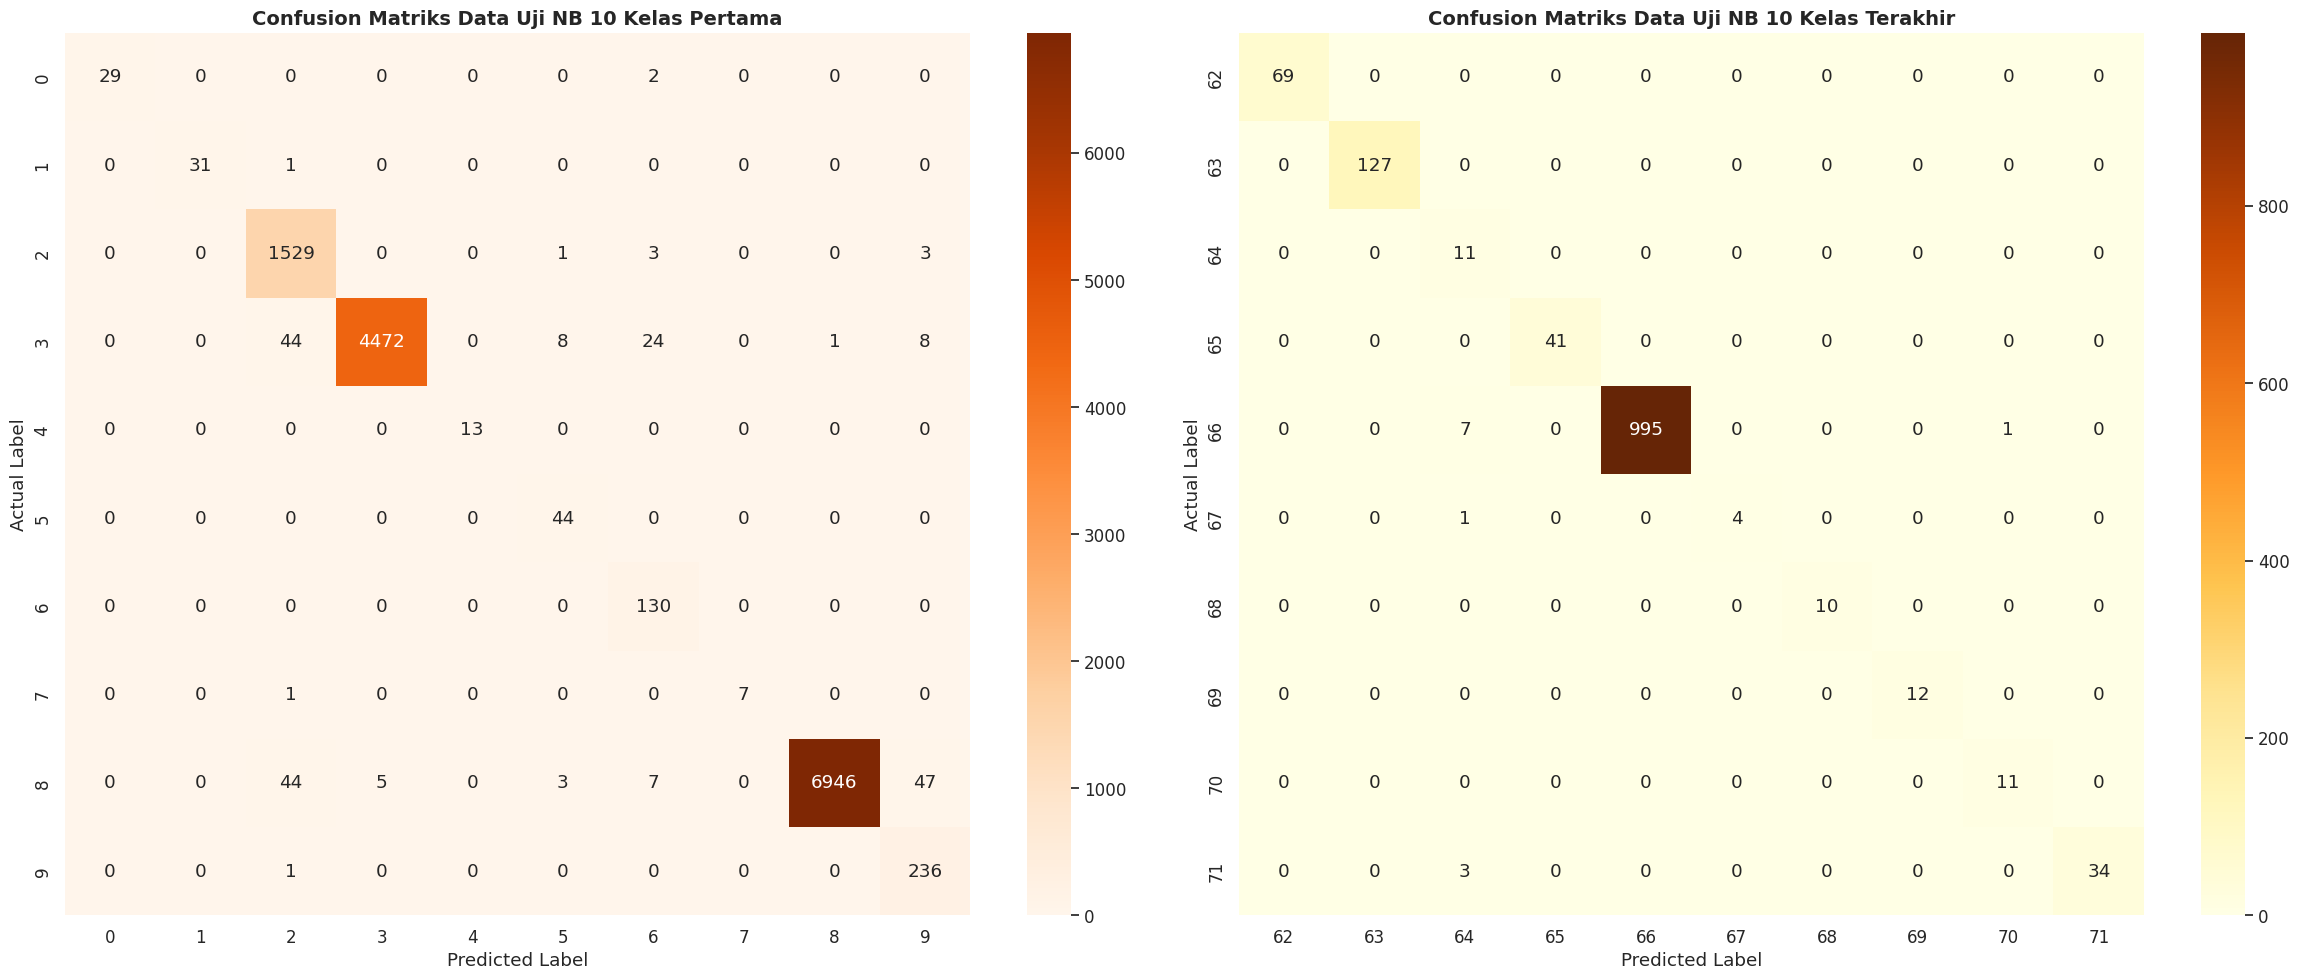


--- Visualisasi 2: ROC Curves NB Data Uji (Tersimpan) ---


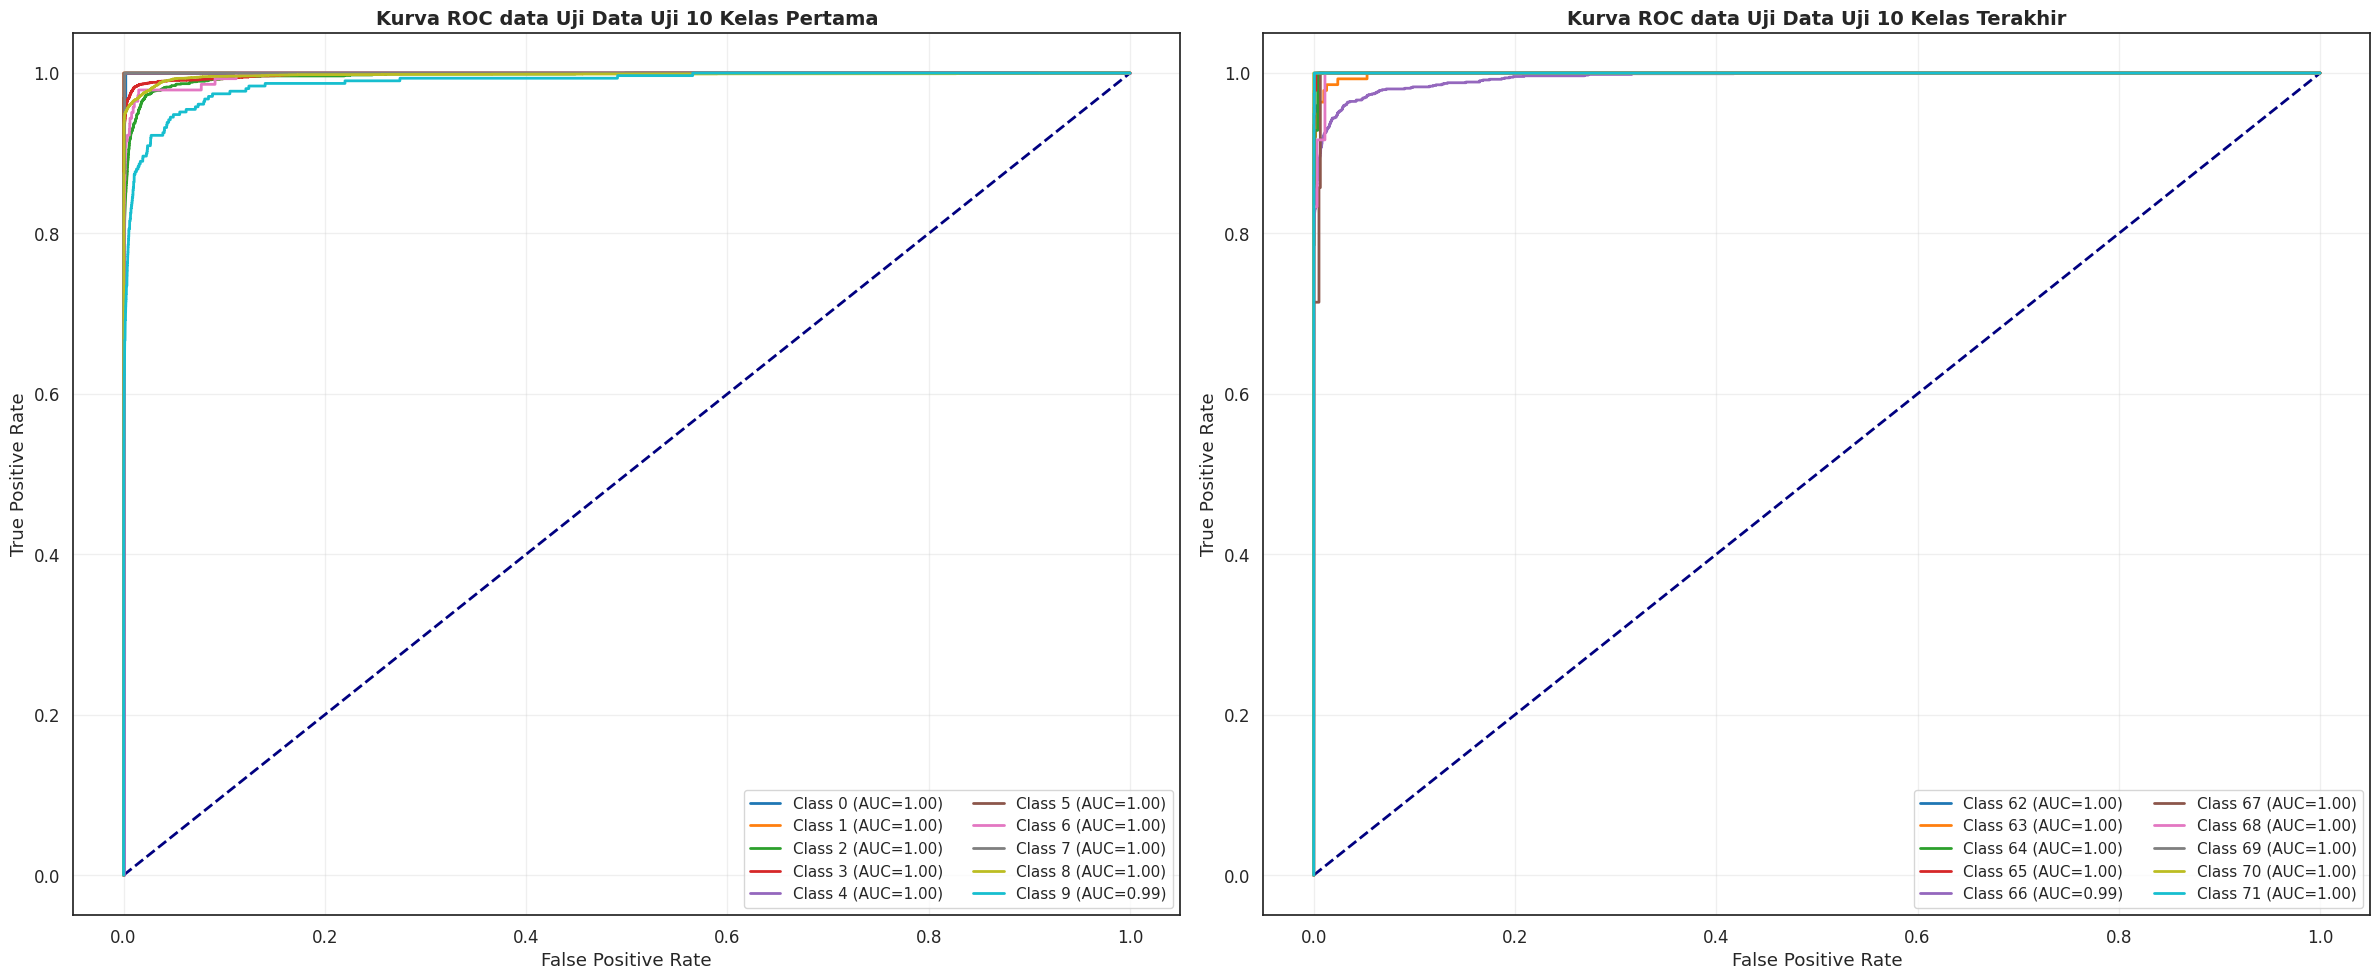


[PROCESS] Menghitung Final Metrics NB untuk Perbandingan Akhir...
RINGKASAN PERFORMA FINAL NAIVE BAYES (DATA UJI 20%)
accuracy            : 93.34%
balanced_accuracy   : 88.23%
f1_macro            : 82.46%
auc_macro           : 99.73%
computation_time    : 0.5654 detik
[Parameter 'results_nb_test' tersimpan.


In [24]:
import os
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, balanced_accuracy_score, 
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# 1. PERSIAPAN FOLDER KHUSUS NAIVE BAYES TEST
os.makedirs('plots_nb_test', exist_ok=True)

print("EVALUASI FINAL NAIVE BAYES PADA DATA UJI")

# 2. PROSES PREDIKSI DATA UJI & PENCATATAN WAKTU
print("\n[PROCESS] Melakukan Prediksi Naive Bayes pada Data Uji...")

# Catat waktu mulai testing
start_test_time = time.time()

# Prediksi Kelas & Probabilitas
y_pred_test_gpu = nb_final.predict(X_test_gpu)
y_proba_test_gpu = nb_final.predict_proba(X_test_gpu)

# Catat durasi testing
test_duration = time.time() - start_test_time
print(f"       -> Prediksi NB Selesai dalam {test_duration:.4f} detik.")

# Pindah ke CPU untuk Evaluasi & Visualisasi
y_test_true_cpu = cp.asnumpy(y_test_gpu)
y_test_pred_cpu = cp.asnumpy(y_pred_test_gpu)
y_test_proba_cpu = cp.asnumpy(y_proba_test_gpu)

# 3. DATA PREPARATION
print("\n[PROCESS] Menyiapkan Daftar Kelas untuk Visualisasi...")

unique_classes_test = np.unique(y_test_true_cpu)
class_names_test = [str(c) for c in unique_classes_test]

# URUTKAN SECARA ANGKA (NUMERIK)
all_classes_sorted_test = sorted(class_names_test, key=lambda x: int(x))

first_10_test = all_classes_sorted_test[:10]
last_10_test = all_classes_sorted_test[-10:]

print(f"       -> First 10 Classes: {first_10_test}")
print(f"       -> Last 10 Classes : {last_10_test}")

# BAGIAN A: VISUALISASI CONFUSION MATRIX (NB Data Uji)
def plot_and_save_cm_nb_test(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Kiri: First 10
    indices_a = [i for i, label in enumerate(y_test_true_cpu) if str(label) in list_a]
    if indices_a:
        cm_a = confusion_matrix(y_test_true_cpu[indices_a], y_test_pred_cpu[indices_a], labels=[int(c) for c in list_a])
        # Gunakan colormap 'Oranges' agar beda dengan KNN
        sns.heatmap(cm_a, annot=True, fmt='d', cmap='Oranges', ax=axes[0], xticklabels=list_a, yticklabels=list_a)
    axes[0].set_title('Confusion Matriks Data Uji NB 10 Kelas Pertama', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('Actual Label')

    # Kanan: Last 10
    indices_b = [i for i, label in enumerate(y_test_true_cpu) if str(label) in list_b]
    if indices_b:
        cm_b = confusion_matrix(y_test_true_cpu[indices_b], y_test_pred_cpu[indices_b], labels=[int(c) for c in list_b])
        sns.heatmap(cm_b, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1], xticklabels=list_b, yticklabels=list_b)
    axes[1].set_title('Confusion Matriks Data Uji NB 10 Kelas Terakhir', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('Actual Label')

    plt.tight_layout()
    plt.savefig('plots_nb_test/nb_confusion_matrix_test.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 1: Confusion Matrix NB Data Uji (Tersimpan) ---")
plot_and_save_cm_nb_test(first_10_test, last_10_test)

# VISUALISASI Kurva ROC (NB Data Uji)
model_classes_cpu = cp.asnumpy(nb_final.classes_)
y_test_bin = label_binarize(y_test_true_cpu, classes=model_classes_cpu)

def plot_and_save_roc_nb_test(list_a, list_b):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    def plot_on_axis(class_list, ax, title):
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        for cls_str in class_list:
            try:
                cls_idx = int(cls_str)
                col_indices = np.where(model_classes_cpu == cls_idx)[0]
                if len(col_indices) == 0: continue
                col_idx = col_indices[0]
                
                if np.sum(y_test_bin[:, col_idx]) > 0:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, col_idx], y_test_proba_cpu[:, col_idx])
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, lw=2, label=f'Class {cls_str} (AUC={roc_auc:.2f})')
            except Exception as e: continue
                
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc="lower right", fontsize='small', ncol=2)
        ax.grid(alpha=0.3)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')

    plot_on_axis(list_a, axes[0], "Kurva ROC data Uji Data Uji 10 Kelas Pertama")
    plot_on_axis(list_b, axes[1], "Kurva ROC data Uji Data Uji 10 Kelas Terakhir")
    
    plt.tight_layout()
    plt.savefig('plots_nb_test/nb_roc_curve_test.png', dpi=300)
    plt.show()

print("\n--- Visualisasi 2: ROC Curves NB Data Uji (Tersimpan) ---")
plot_and_save_roc_nb_test(first_10_test, last_10_test)

# SIMPAN HASIL UJI KE PARAMETER GLOBAL
print("\n[PROCESS] Menghitung Final Metrics NB untuk Perbandingan Akhir...")
try:
    auc_macro_test = roc_auc_score(y_test_bin, y_test_proba_cpu, multi_class='ovr', average='macro')
except Exception as e:
    auc_macro_test = 0.0
# Simpan ke variabel 'results_nb_test'
results_nb_test = {
    'accuracy': accuracy_score(y_test_true_cpu, y_test_pred_cpu),
    'balanced_accuracy': balanced_accuracy_score(y_test_true_cpu, y_test_pred_cpu),
    'f1_macro': f1_score(y_test_true_cpu, y_test_pred_cpu, average='macro'),
    'auc_macro': auc_macro_test,
    'computation_time': test_duration
}

print("RINGKASAN PERFORMA FINAL NAIVE BAYES (DATA UJI 20%)")
for metric, value in results_nb_test.items():
    if metric == 'computation_time':
        print(f"{metric:<20}: {value:.4f} detik")
    else:
        print(f"{metric:<20}: {value*100:.2f}%")
print("[Parameter 'results_nb_test' tersimpan.")

# Nilai Evaluasi matriks standar Naive Bayes dan KNN

In [25]:
from sklearn.metrics import classification_report
import cupy as cp
print("LAPORAN KLASIFIKASI STANDAR (CLASSIFICATION REPORT)")

# 1. LAPORAN KNN
print("A. ALGORITMA K-NEAREST NEIGHBOR (KNN)")
# Data Latih KNN
print("\n[KNN - DATA LATIH]")
y_pred_knn_train = knn_final.predict(X_final_train) # Prediksi ulang
print(classification_report(cp.asnumpy(y_final_train), 
                            cp.asnumpy(y_pred_knn_train), 
                            digits=2))

# Data Uji KNN
print("\n[KNN - DATA UJI]")
y_pred_knn_test = knn_final.predict(X_test_gpu) # Prediksi ulang
print(classification_report(cp.asnumpy(y_test_gpu), 
                            cp.asnumpy(y_pred_knn_test), 
                            digits=2))

# 2. LAPORAN NAIVE BAYES
print("B. ALGORITMA NAIVE BAYES (NB)")
# Data Latih NB
print("\n[NAIVE BAYES - DATA LATIH]")
y_pred_nb_train = nb_final.predict(X_final_train)
print(classification_report(cp.asnumpy(y_final_train), 
                            cp.asnumpy(y_pred_nb_train), 
                            digits=2))

# Data Uji NB
print("\n[NAIVE BAYES - DATA UJI]")
y_pred_nb_test = nb_final.predict(X_test_gpu)
print(classification_report(cp.asnumpy(y_test_gpu), 
                            cp.asnumpy(y_pred_nb_test), 
                            digits=2))

LAPORAN KLASIFIKASI STANDAR (CLASSIFICATION REPORT)
A. ALGORITMA K-NEAREST NEIGHBOR (KNN)

[KNN - DATA LATIH]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       127
           1       1.00      1.00      1.00       130
           2       0.99      0.99      0.99      6642
           3       1.00      1.00      1.00     18937
           4       1.00      1.00      1.00        50
           5       0.99      1.00      0.99       174
           6       0.98      0.98      0.98       569
           7       0.97      0.97      0.97        30
           8       1.00      1.00      1.00     29408
           9       1.00      0.98      0.99      1236
          10       0.99      1.00      1.00       258
          11       0.97      0.96      0.97        74
          12       0.99      0.94      0.96        78
          13       1.00      0.99      0.99      2306
          14       0.99      1.00      0.99      6346
          15       1.00  

# Visualisasi Perbandingan Naive Bayes dan KNN

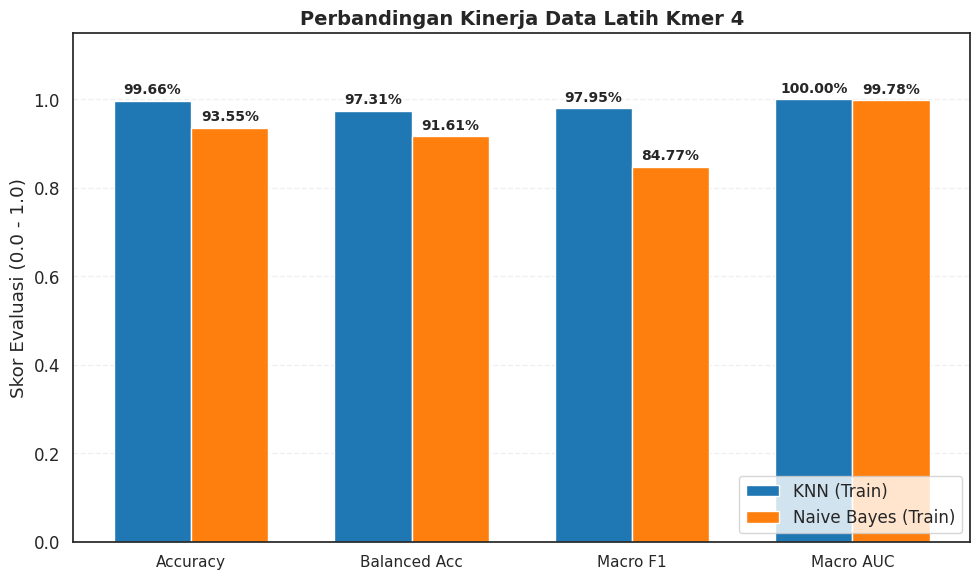

[Grafik Data Latih tersimpan sebagai 'Comparison_Train_Only.png'


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 1. SIAPKAN DATA TRAIN
metrics = ['Accuracy', 'Balanced Acc', 'Macro F1', 'Macro AUC']
knn_train = [
    results_knn_train['accuracy'], 
    results_knn_train['balanced_accuracy'], 
    results_knn_train['f1_macro'], 
    results_knn_train['auc_macro']
]
nb_train = [
    results_nb_train['accuracy'], 
    results_nb_train['balanced_accuracy'], 
    results_nb_train['f1_macro'], 
    results_nb_train['auc_macro']
]

# 2. SETUP PLOT
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Batang KNN (Biru) & NB (Oranye)
rects1 = ax.bar(x - width/2, knn_train, width, label='KNN (Train)', color='#1f77b4', edgecolor='white')
rects2 = ax.bar(x + width/2, nb_train, width, label='Naive Bayes (Train)', color='#ff7f0e', edgecolor='white')

# 3. PERCANTIK GRAFIK
ax.set_ylabel('Skor Evaluasi (0.0 - 1.0)')
ax.set_title('Perbandingan Kinerja Data Latih Kmer 4', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 1.15)
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 4. LABEL ANGKA DI ATAS BATANG
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.savefig('Comparison_Train_Only.png', dpi=300)
plt.show()
print("[Grafik Data Latih tersimpan sebagai 'Comparison_Train_Only.png'")

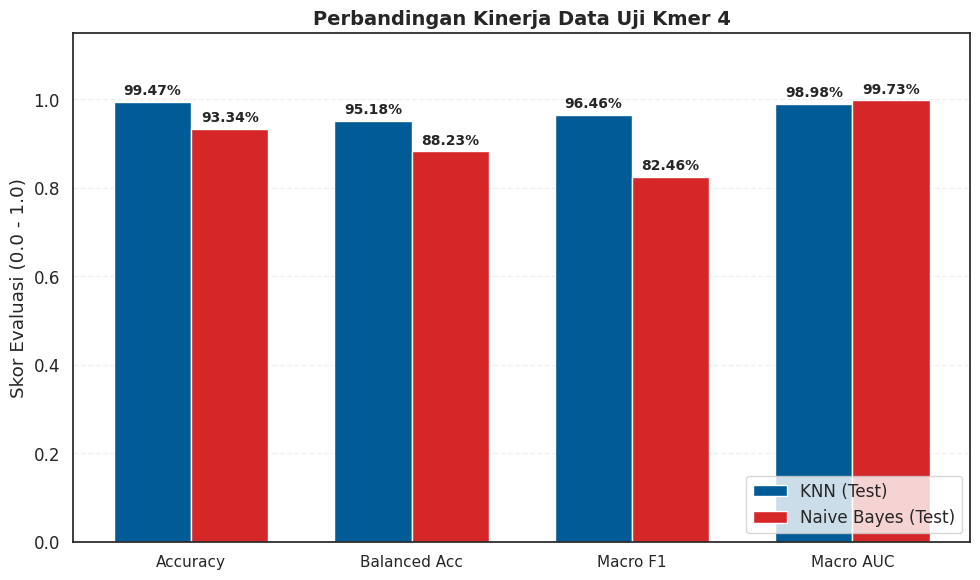

Grafik Data Uji tersimpan sebagai 'Comparison_Test_Only.png'


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 1. SIAPKAN DATA TEST
metrics = ['Accuracy', 'Balanced Acc', 'Macro F1', 'Macro AUC']
knn_test = [
    results_knn_test['accuracy'], 
    results_knn_test['balanced_accuracy'], 
    results_knn_test['f1_macro'], 
    results_knn_test['auc_macro']
]
nb_test = [
    results_nb_test['accuracy'], 
    results_nb_test['balanced_accuracy'], 
    results_nb_test['f1_macro'], 
    results_nb_test['auc_macro']
]

# 2. SETUP PLOT
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Batang KNN (Biru Tua) & NB (Merah Bata) - Warna sedikit dibedakan agar tegas
rects1 = ax.bar(x - width/2, knn_test, width, label='KNN (Test)', color='#005b96', edgecolor='white')
rects2 = ax.bar(x + width/2, nb_test, width, label='Naive Bayes (Test)', color='#d62728', edgecolor='white')

# 3. PERCANTIK GRAFIK
ax.set_ylabel('Skor Evaluasi (0.0 - 1.0)')
ax.set_title('Perbandingan Kinerja Data Uji Kmer 4', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 1.15)
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 4. LABEL ANGKA DI ATAS BATANG
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('Comparison_Test_Only.png', dpi=300)
plt.show()
print("Grafik Data Uji tersimpan sebagai 'Comparison_Test_Only.png'")

Membuat Grafik Perbandingan Waktu Komputasi...


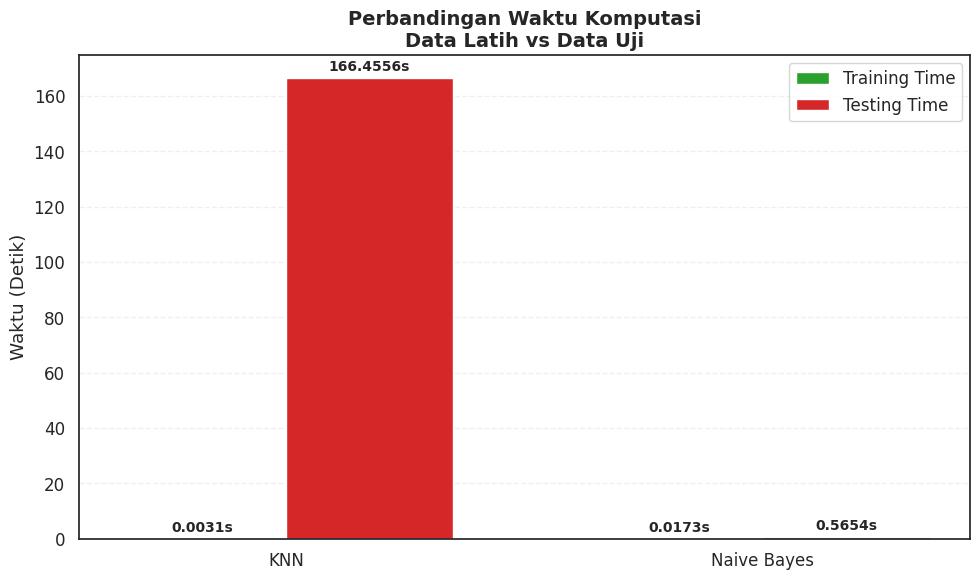


[PROCESS] Membuat Spider Plot Final (Rotated & Anti-Overlap)...


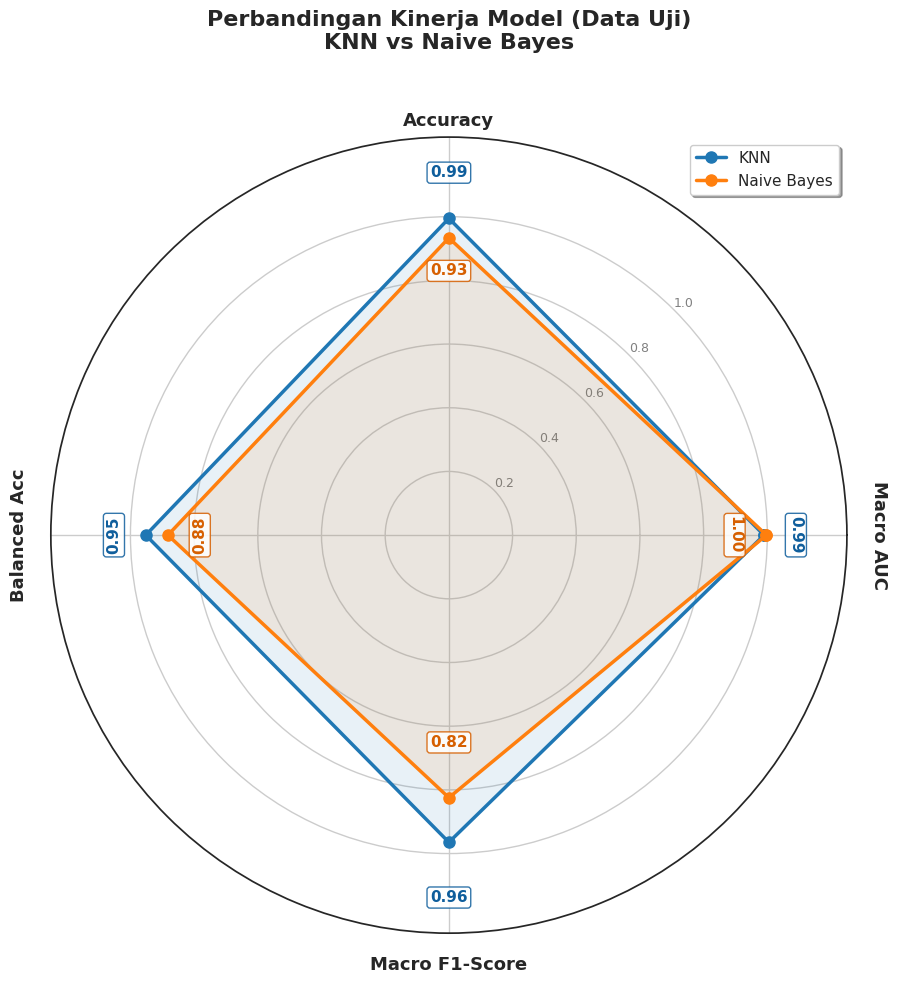

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi

# 1. VISUALISASI WAKTU KOMPUTASI
print("Membuat Grafik Perbandingan Waktu Komputasi...")

# Menyiapkan Data
models = ['KNN', 'Naive Bayes']
train_times = [results_knn_train['computation_time'], results_nb_train['computation_time']]
test_times  = [results_knn_test['computation_time'], results_nb_test['computation_time']]

x = np.arange(len(models))  # Lokasi label
width = 0.35  # Lebar batang

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_times, width, label='Training Time', color='#2ca02c') # Hijau
rects2 = ax.bar(x + width/2, test_times, width, label='Testing Time', color='#d62728')   # Merah

# Labeling
ax.set_ylabel('Waktu (Detik)')
ax.set_title('Perbandingan Waktu Komputasi\nData Latih vs Data Uji', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Fungsi untuk menaruh angka di atas batang
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}s',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('Final_Comparison_Time.png', dpi=300)
plt.show()

# 2. VISUALISASI SPIDER PLOT
print("\n[PROCESS] Membuat Spider Plot Final (Rotated & Anti-Overlap)...")

# 1. PERSIAPAN DATA & LABEL
# Menggunakan 'Accuracy' (Inggris) sesuai permintaan
categories = ['Macro AUC', 'Accuracy', 'Balanced Acc', 'Macro F1-Score']
N = len(categories)

values_knn = [
    results_knn_test['auc_macro'],         # Kanan
    results_knn_test['accuracy'],          # Atas
    results_knn_test['balanced_accuracy'], # Kiri
    results_knn_test['f1_macro']           # Bawah
]

values_nb = [
    results_nb_test['auc_macro'],
    results_nb_test['accuracy'],
    results_nb_test['balanced_accuracy'],
    results_nb_test['f1_macro']
]

# Menyiapkan Sudut (Angles)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] # Menutup loop agar grafik nyambung

# Menutup loop data nilai juga
values_knn += values_knn[:1]
values_nb += values_nb[:1]

# 2. PLOTTING
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# --- GAMBAR GARIS & AREA ---
ax.plot(angles, values_knn, linewidth=2.5, linestyle='solid', label='KNN', color='#1f77b4', marker='o', markersize=8)
ax.fill(angles, values_knn, '#1f77b4', alpha=0.1)

ax.plot(angles, values_nb, linewidth=2.5, linestyle='solid', label='Naive Bayes', color='#ff7f0e', marker='o', markersize=8)
ax.fill(angles, values_nb, '#ff7f0e', alpha=0.1)

# 3. LABEL SUMBU (KATEGORI) DENGAN ROTASI
ax.set_xticks(angles[:-1])
xtick_labels = ax.set_xticklabels(categories, fontsize=13, fontweight='bold', color='black')

# Loop memutar label kategori secara manual
for label, angle in zip(xtick_labels, angles[:-1]):
    degrees = np.degrees(angle)
    
    # Logika Rotasi Label Kategori
    if degrees < 10 or degrees > 350: # KANAN (Macro AUC)
        label.set_visible(False) # Sembunyikan label asli
        ax.text(angle, 1.35, categories[0], ha='center', va='center', rotation=-90, fontsize=13, fontweight='bold')

    elif 170 < degrees < 190:         # KIRI (Balanced Acc)
        label.set_visible(False)
        ax.text(angle, 1.35, categories[2], ha='center', va='center', rotation=90, fontsize=13, fontweight='bold')

    elif 80 < degrees < 100:          # ATAS (Accuracy) 
        label.set_visible(False)
        ax.text(angle, 1.3, categories[1], ha='center', va='center', rotation=0, fontsize=13, fontweight='bold')

    elif 260 < degrees < 280:         # BAWAH (Macro F1)
        label.set_visible(False)
        ax.text(angle, 1.35, categories[3], ha='center', va='center', rotation=0, fontsize=13, fontweight='bold')


# 4. LABEL ANGKA (VALUES) DENGAN ROTASI
def add_rotated_value_labels(angles, values, color, model_name):
    for angle, val in zip(angles[:-1], values[:-1]):
        degrees = np.degrees(angle)
        
        # Default settings
        dist_shift = 0
        va_pos = 'center'
        ha_pos = 'center'
        rot_angle = 0
        
        # 1. KANAN (Macro AUC)
        if (degrees < 10 or degrees > 350):
            rot_angle = -90
            if model_name == 'KNN': dist_shift = 0.1
            else: dist_shift = -0.1

        # 2. KIRI (Balanced Acc)
        elif (170 < degrees < 190):
            rot_angle = 90
            if model_name == 'KNN': dist_shift = 0.1
            else: dist_shift = -0.1
        
        # 3. ATAS (Accuracy)
        elif 80 < degrees < 100:
            rot_angle = 0
            if model_name == 'KNN': dist_shift = 0.12; va_pos = 'bottom'
            else: dist_shift = -0.08; va_pos = 'top'
                
        # 4. BAWAH (Macro F1) 
        elif 260 < degrees < 280:
            rot_angle = 0
            if model_name == 'KNN': dist_shift = 0.15; va_pos = 'top'
            else: dist_shift = -0.15; va_pos = 'bottom'

        # Render Label
        ax.text(angle, val + dist_shift, 
                f"{val:.2f}", 
                color=color, size=11, fontweight='bold', 
                ha=ha_pos, va=va_pos, rotation=rot_angle, rotation_mode='anchor',
                bbox=dict(facecolor='white', edgecolor=color, alpha=0.85, boxstyle='round,pad=0.2'))

# Panggil Fungsi Label Angka
add_rotated_value_labels(angles, values_knn, '#0f5e9c', model_name='KNN')
add_rotated_value_labels(angles, values_nb, '#d65f00', model_name='Naive Bayes')

# 5. FINISHING TOUCHES
# Label Grid Y (Lingkaran dalam)
ax.set_rlabel_position(45) 
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=9)
plt.ylim(0, 1.25)

# Judul & Legenda
plt.title('Perbandingan Kinerja Model (Data Uji)\nKNN vs Naive Bayes', size=16, fontweight='bold', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('Final_Comparison_Radar_Corrected.png', dpi=300)
plt.show()